<a href="https://colab.research.google.com/github/ladrianx/proyectos/blob/main/rsna2024_scs_model_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

rsna_2024_lumbar_spine_degenerative_classification_path = kagglehub.competition_download('rsna-2024-lumbar-spine-degenerative-classification')
lamp1979_model_scs_test_path = kagglehub.dataset_download('lamp1979/model-scs-test')

print('Data source import complete.')


# RSNA 2024 Lumbar Spine Degenerative Classification

# 1. Introduction

To have a general overview of medical conditions you can consult this notebook:

https://www.kaggle.com/code/abhinavsuri/anatomy-image-visualization-overview-rsna-raidshttps://www.kaggle.com/code/abhinavsuri/anatomy-image-visualization-overview-rsna-raids

The following proposal consists of training a model by images to be able to estimate the probability of *pain* at each intervertebral *level* and for each of the following *conditions*:

spinal_canal_stenosis_l1_l2                 
spinal_canal_stenosis_l2_l3                 
spinal_canal_stenosis_l3_l4                 
spinal_canal_stenosis_l4_l5                 
spinal_canal_stenosis_l5_s1                 
left_neural_foraminal_narrowing_l1_l2       
left_neural_foraminal_narrowing_l2_l3       
left_neural_foraminal_narrowing_l3_l4       
left_neural_foraminal_narrowing_l4_l5       
left_neural_foraminal_narrowing_l5_s1       
right_neural_foraminal_narrowing_l1_l2      
right_neural_foraminal_narrowing_l2_l3      
right_neural_foraminal_narrowing_l3_l4      
right_neural_foraminal_narrowing_l4_l5      
right_neural_foraminal_narrowing_l5_s1      
left_subarticular_stenosis_l1_l2          
left_subarticular_stenosis_l2_l3          
left_subarticular_stenosis_l3_l4          
left_subarticular_stenosis_l4_l5          
left_subarticular_stenosis_l5_s1           
right_subarticular_stenosis_l1_l2         
right_subarticular_stenosis_l2_l3          
right_subarticular_stenosis_l3_l4           
right_subarticular_stenosis_l4_l5           
right_subarticular_stenosis_l5_s1           
       
The general strategy is to group all intervertebral levels by medical condition and train five individual Neural Models (NM)

$\mathcal{M}_1$: spinal_canal_stenosis

$\mathcal{M}_2$: left_neural_foraminal_narrowing

$\mathcal{M}_3$: right_neural_foraminal_narrowing

$\mathcal{M}_4$: left_subarticular_stenosis

$\mathcal{M}_5$: right_subarticular_stenosis

The first step is to explore the databases and image files. We have to perform several tasks such as identifying the type of data, verifying the order and consistency of the records, identifying if there is incorrect, missing or mislabeled data.

The next step was to debug and clean the database. In the process, we recognized the correlations between the data that have allowed us to define a structure to address the objective of this project, which consists of training an image machine learning model to estimate the level of pain for each medical condition and for each level intervertebral.   



# 2. $\mathcal{M}_1$: spinal_canal_stenosis

The first step is to explore the set of data referring to this first condition. As we will see below, there are missing and mislabeled data as well as misclassified images.

In particular, we need coordinates of some intervertebral levels for which we have a diagnosis and the series of images for them. The need then arises to train a model that can help us estimate these coordinates so that we can integrate these into the training of the submodels. Since we have a small amount of training data we think it is important not to ignore them. To train the model we have derived a database with images from the **Sagittal T2/STIR** series that have the coordinates of all intervertebral levels of interest and we have also eliminated images that have labeling errors. This model will later allow us to label the coordinates that we need and correct those that are mislabeled and finally will allow us to estimate the coordinates of our prediction images. This is particularly useful because we train a neural model ($\mathcal{M}_{scs}$) to predict the condition **Spinal Canal Stenosis** that takes as a basis the coordinates of the intervertebral levels to segment the images.

We developed four models to detect the coordinates of the intervertebral levels using: ResNet18, ViT, ResNet50 and YOLO. By comparing the results we obtain that ResNet50 has the best results. In general, we will use ResNet50 for the remaining models.

Once we have the model to predict the coordinates of the intervertebral levels, we design the $\mathcal{M}_{scs}$ model to be able to predict the pain of all intervertebral levels [Normal/Mild, Moderate, Severe]. To develop this neural model we use two types of models: a local model $(\mathcal{M}_{scs}^L)$ that predicts the pain of each intervertebral level and that is trained with the images segmented in a neighborhood of the coordinates; and a general model $(\mathcal{M}_{scs}^G)$ that is trained with the segmented images coming from all the local models and that predicts pain with respect to all levels and that is based on the assumption that pain at all intervertebral levels is related in some way or another. In order to segment the images for training, prediction and imputation of missing or mislabeled coordinates we designed a model $(\mathcal{M}_{scs}^V)$ to predict the coordinates of all intervertebral levels.

In conclusion, the first model $\mathcal{M}_{scs}$ takes an image of the *Sagittal T2/STIR* series and predicts the coordinates $(\mathcal{M}_{scs}^V)$ of the five levels intervertebral, then segments the images and makes five local predictions $(\mathcal{M}_{scs}^L)$ then makes another 5 predictions with the general model $(\mathcal{M}_{scs}^G)$ with which it carries out a weighting to estimate the pain of each intervertebral level of the spinal canal stenosis condition.

In symbolic terms, given an image $\bf{z}$ of the Sagittal T2/STIR series we predict the coordinates of the 5 intervertebral levels $\mathcal{M}_{scs}^V(\bf{z}) = \{z_1,z_2,z_3,z_4, z_5\}$. Then we form the prediction matrix that has the form

$$
\mathcal{M}_{scs}(\bf{z}) =  \begin{pmatrix}
\mathcal{M}_{scs}^L(z_1) & \mathcal{M}_{scs}^G(z_1)\\
\mathcal{M}_{scs}^L(z_2) & \mathcal{M}_{scs}^G(z_2)\\
\mathcal{M}_{scs}^L(z_3) & \mathcal{M}_{scs}^G(z_3)\\
\mathcal{M}_{scs}^L(z_4) & \mathcal{M}_{scs}^G(z_4)\\
\mathcal{M}_{scs}^L(z_5) & \mathcal{M}_{scs}^G(z_5)\\
\end{pmatrix}
\begin{pmatrix}
a \\
b
\end{pmatrix} =
\begin{pmatrix}
a\cdot\mathcal{M}_{scs}^L(z_1) + b\cdot\mathcal{M}_{scs}^G(z_1)\\
a\cdot\mathcal{M}_{scs}^L(z_2) + b\cdot\mathcal{M}_{scs}^G(z_2)\\
a\cdot\mathcal{M}_{scs}^L(z_3) + b\cdot\mathcal{M}_{scs}^G(z_3)\\
a\cdot\mathcal{M}_{scs}^L(z_4) + b\cdot\mathcal{M}_{scs}^G(z_4)\\
a\cdot\mathcal{M}_{scs}^L(z_5) + b\cdot\mathcal{M}_{scs}^G(z_5)\\
\end{pmatrix}
$$

In this case, $a$ and $b$ must be optimized, for $a,b \in \mathbb{R}$.


## 2.1 Afirmations

Throughout the development of this notebook we will demonstrate the following statements:

#### 🟡 **Afirmation 1**:
Data is missing on the *train*

#### 🟡 **Afirmation 2**:
*'study_id = '3008676218'* is present in *train* and *train_series_descriptions* but not in *train_label_coordinates*. Therefore, we eliminates this entrie in train and *train_label_coordinates*.

#### 🟡 **Afirmation 3**:
*'Sagittal T2/STIR'* is used to diagnose all levels the condition *'Spinal Canal Stenosis'* except in case *'study_id = '3637444890'*. Therefore, we can exclude the *'study_id='3637444890'* in the case of *'Spinal Canal Stenosis'* and use *train_merge_T2* for our analysis.

#### 🟡 **Afirmation 4**:
Generally there are three *'series_id'* which implies that there are three subdirectories. However, there are *'study_id'* that have more than three directories associated with them.

#### 🟡 **Afirmation 5**:
When we look at the *'level'* in *train_label_descriptions* for *Spinal Canal Stenosis* we have *'study_id'* cases that exist in *train* and *train_series_descriptions* but not in *train_label_coordinates*. In other words, there is the *pain level* (*'Normal/Mild', 'Moderate', 'Severe'*) in *'train'* in relation to *'Spinal Canal Stenosis'* and we have the * 'series_descriptions'* (*' Sagittal T2/STIR'*) but there are no records in *'train_label_coordinates'*. For example: a) there are 70 cases in *'spinal_canal_stenosis_l1_l2'*, b) 30 cases in *'spinal_canal_stenosis_l2_l3'*, and 2, 3 and 5 in the other cases.

#### 🟡 **Afirmation 6**:
Exists cases where the coordinates are bad labeled.

#### 🟡 **Afirmation 7**:
With 20 epochs of ResNet50 model predicts much better than ResNet18, ViT and ResNet18.

#### 🟡 **Afirmation 8**:
The case *study_id = 3637444890* has an incorrect label with respect to *series_id = 3892989905*.

The case *study_id = 2905025904* and *series_id = 816381378* is mislabeled with respect to coordinates.

The case *study_id = 1438760543* and *series_id = 737753815* is mislabeled with respect to coordinates.

#### 🟡 **Afirmation 9**:

The databases *df_scs_l1_l2, df_scs_l2_l3,df_scs_l3_l4,df_scs_l4_l5,df_scs_l5_s1 * that combine the referring data by intervertebral level are purified and imputed.

#### 🟡 **Afirmation 10**:
El modelo ResNet_scs_



## 2.2 Import libraries and datasets

In general, we need the following libraries. However, in each model the necessary libraries are imported again to avoid compilation errors due to unexecuted cells.

In [ ]:
#!pip install transformers torch torchvision torchaudio torchtext accelerate -U
import os
import cv2
import shutil
import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image, ImageOps
from ipywidgets import interact, IntSlider
from tqdm import tqdm
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset, Dataset
from torchvision import transforms
from transformers import ViTConfig, ViTForImageClassification
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder

In [ ]:
train = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_label_coordinates = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_series_descriptions = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

## 2.3 Explore the datasets

#### 🟡 **Afirmation 1**:
Data is missing on the *train*

**Proof:**

In [ ]:
train.isna().sum()

study_id                                    0
spinal_canal_stenosis_l1_l2                 1
spinal_canal_stenosis_l2_l3                 1
spinal_canal_stenosis_l3_l4                 1
spinal_canal_stenosis_l4_l5                 1
spinal_canal_stenosis_l5_s1                 1
left_neural_foraminal_narrowing_l1_l2       2
left_neural_foraminal_narrowing_l2_l3       2
left_neural_foraminal_narrowing_l3_l4       2
left_neural_foraminal_narrowing_l4_l5       2
left_neural_foraminal_narrowing_l5_s1       2
right_neural_foraminal_narrowing_l1_l2      8
right_neural_foraminal_narrowing_l2_l3      8
right_neural_foraminal_narrowing_l3_l4      8
right_neural_foraminal_narrowing_l4_l5      8
right_neural_foraminal_narrowing_l5_s1      8
left_subarticular_stenosis_l1_l2          164
left_subarticular_stenosis_l2_l3           82
left_subarticular_stenosis_l3_l4            3
left_subarticular_stenosis_l4_l5            3
left_subarticular_stenosis_l5_s1           11
right_subarticular_stenosis_l1_l2 

*train_label_coordinates* and *train_series_descriptions* don´t have missing data

In [ ]:
train_label_coordinates.isna().sum()

study_id           0
series_id          0
instance_number    0
condition          0
level              0
x                  0
y                  0
dtype: int64

In [ ]:
train_series_descriptions.isna().sum()

study_id              0
series_id             0
series_description    0
dtype: int64

This demostrate **Afirmation 1** 🟨

#### 🟡 **Afirmation 2**:
*'study_id = '3008676218'* is present in *train* and *train_series_descriptions* but not in *train_label_coordinates*.

**Proof:**

Now we compare the datasets if have the same entries with respect to the column *study_id*,

In [ ]:
def compare_column(dataframe1, dataframe2, column_name):

    column1 = dataframe1[column_name]
    column2 = dataframe2[column_name]

    set1 = set(column1)
    set2 = set(column2)

    unique_to_dataframe1 = set1 - set2
    unique_to_dataframe2 = set2 - set1

    return unique_to_dataframe1, unique_to_dataframe2

In [ ]:
print(compare_column(train,train_label_coordinates,'study_id'))
print(compare_column(train_label_coordinates,train_series_descriptions,'study_id'))
print(compare_column(train,train_series_descriptions,'study_id'))

({3008676218}, set())
(set(), {3008676218})
(set(), set())


In [ ]:
print(train[train.study_id == 3008676218].T)
print(train_series_descriptions[train_series_descriptions.study_id == 3008676218])

                                               1378
study_id                                 3008676218
spinal_canal_stenosis_l1_l2                     NaN
spinal_canal_stenosis_l2_l3                     NaN
spinal_canal_stenosis_l3_l4                     NaN
spinal_canal_stenosis_l4_l5                     NaN
spinal_canal_stenosis_l5_s1                     NaN
left_neural_foraminal_narrowing_l1_l2   Normal/Mild
left_neural_foraminal_narrowing_l2_l3        Severe
left_neural_foraminal_narrowing_l3_l4      Moderate
left_neural_foraminal_narrowing_l4_l5      Moderate
left_neural_foraminal_narrowing_l5_s1        Severe
right_neural_foraminal_narrowing_l1_l2  Normal/Mild
right_neural_foraminal_narrowing_l2_l3     Moderate
right_neural_foraminal_narrowing_l3_l4       Severe
right_neural_foraminal_narrowing_l4_l5     Moderate
right_neural_foraminal_narrowing_l5_s1     Moderate
left_subarticular_stenosis_l1_l2        Normal/Mild
left_subarticular_stenosis_l2_l3           Moderate
left_subarti

This implies that there are no images to diagnose the condition 'Spinal Canal Stenosis'. Therefore, we eliminates this entrie in *train* and *train_label_coordinates*

In [ ]:
train.drop(1378,inplace=True)
train_series_descriptions.drop(4398, inplace = True)
train_series_descriptions.drop(4397, inplace = True)

This demostrate **Afirmation 2** 🟨

#### 🟡 **Afirmation 3**:
*'Sagittal T2/STIR'* is used to diagnose all levels the condition *'Spinal Canal Stenosis'* except in case *'study_id = '3637444890'*

**Proof:**

Now combine the datasets *train_label_coordinates* and *train_series_descriptions* to show there is an unique case where the condition 'Spinal Canal Stenosis' use other 'series_descriptions' diferent to *'Sagittal T2/STIR'*

In [ ]:
train_merge = pd.merge(left=train_label_coordinates,right=train_series_descriptions,how='left',on=['study_id','series_id']).reset_index(drop = True)
train_merge.head()

,study_id,series_id,instance_number,condition,level,x,y,series_description
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Sagittal T2/STIR
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Sagittal T2/STIR
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Sagittal T2/STIR
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Sagittal T2/STIR
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Sagittal T2/STIR


In [ ]:
train_merge_T2 = train_merge[train_merge.series_description == 'Sagittal T2/STIR']
train_merge_T2.head()

,study_id,series_id,instance_number,condition,level,x,y,series_description
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Sagittal T2/STIR
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Sagittal T2/STIR
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Sagittal T2/STIR
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Sagittal T2/STIR
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Sagittal T2/STIR


In [ ]:
train_merge_scs = train_merge[train_merge.condition == 'Spinal Canal Stenosis']
train_merge_scs.head()

,study_id,series_id,instance_number,condition,level,x,y,series_description
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Sagittal T2/STIR
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Sagittal T2/STIR
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Sagittal T2/STIR
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Sagittal T2/STIR
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Sagittal T2/STIR


In [ ]:
compare_column(train_merge_scs,train_merge_T2,'study_id')

({3637444890}, set())

In [ ]:
train_merge_scs[train_merge_scs.study_id == 3637444890]

,study_id,series_id,instance_number,condition,level,x,y,series_description
41259,3637444890,3951475160,8,Spinal Canal Stenosis,L1/L2,214.852201,109.703066,Sagittal T1
41260,3637444890,3951475160,8,Spinal Canal Stenosis,L2/L3,204.388986,150.468734,Sagittal T1
41261,3637444890,3951475160,8,Spinal Canal Stenosis,L3/L4,201.250021,194.466270,Sagittal T1
41262,3637444890,3951475160,8,Spinal Canal Stenosis,L4/L5,205.435307,233.520513,Sagittal T1
41263,3637444890,3951475160,8,Spinal Canal Stenosis,L5/S1,216.944844,265.956480,Sagittal T1


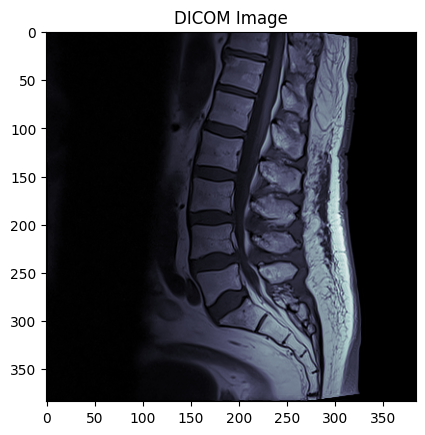

In [ ]:
def visualize_dicom_image(file_path):
    dicom_data = pydicom.dcmread(file_path)
    pixel_array = dicom_data.pixel_array

    plt.imshow(pixel_array, cmap=plt.cm.bone)
    plt.title('DICOM Image')
    plt.axis('on')
    plt.show()

dicom_file_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3637444890/3951475160/8.dcm'
visualize_dicom_image(dicom_file_path)

Note in this case exists four directories and have a problem with the images of *'Sagittal T2/STIR'*

In [ ]:
def get_subdir(path,my_study):
    directorio = os.path.join(path, str(my_study))
    for ruta, dirs, archivos in os.walk(directorio):
        for dir in dirs:
            print(f"{ruta}/{dir}")

In [ ]:
path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'
my_study = 3637444890
get_subdir(path,my_study)

/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3637444890/1590743005
/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3637444890/3951475160
/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3637444890/3892989905
/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3637444890/3671685092


In [ ]:
train_merge_scs[train_merge_scs.study_id == 3637444890]

,study_id,series_id,instance_number,condition,level,x,y,series_description
41259,3637444890,3951475160,8,Spinal Canal Stenosis,L1/L2,214.852201,109.703066,Sagittal T1
41260,3637444890,3951475160,8,Spinal Canal Stenosis,L2/L3,204.388986,150.468734,Sagittal T1
41261,3637444890,3951475160,8,Spinal Canal Stenosis,L3/L4,201.250021,194.466270,Sagittal T1
41262,3637444890,3951475160,8,Spinal Canal Stenosis,L4/L5,205.435307,233.520513,Sagittal T1
41263,3637444890,3951475160,8,Spinal Canal Stenosis,L5/S1,216.944844,265.956480,Sagittal T1


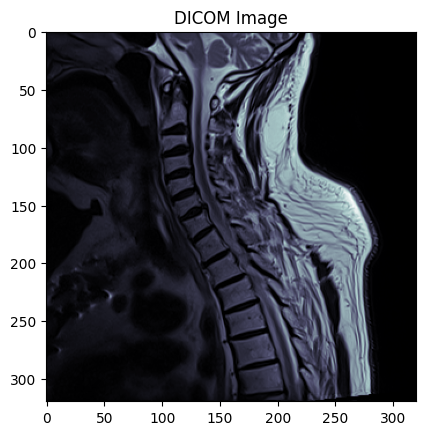

In [ ]:
dicom_file_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3637444890/3892989905/9.dcm'

visualize_dicom_image(dicom_file_path)

In [ ]:
for f in ['series_description']:
    print(train_merge_scs[f].value_counts())
print(" ")
for f in ['series_description']:
    print(train_merge_T2[f].value_counts())

series_description
Sagittal T2/STIR    9748
Sagittal T1            5
Name: count, dtype: int64
 
series_description
Sagittal T2/STIR    9748
Name: count, dtype: int64


Therefore, we can exclude the *'study_id='3637444890'* in the case of *'Spinal Canal Stenosis'* and use *train_merge_T2* for our analysis.

This demostrate **Afirmation 3** 🟨

#### 🟡 **Afirmation 4**:
Generally there are three *'series_id'* which implies that there are three subdirectories. However, there are *'study_id'* that have more than three directories associated with them.

**Proof:**

Let's count the total number of directories *'train_images'* has.

In [ ]:
def count_subdirectories(path):
    entries = os.listdir(path)
    directories = [entry for entry in entries if os.path.isdir(os.path.join(path, entry))]
    subdir_counts = []
    for directory in directories:
        dir_path = os.path.join(path, directory)
        subdirs = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
        subdir_count = len(subdirs)
        subdir_counts.append((directory, subdir_count))
    df = pd.DataFrame(subdir_counts, columns=['study_id', 'number_series_id'])
    return df

path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'
subdir_df = count_subdirectories(path)
subdir_df.head()

,study_id,number_series_id
0,1737682527,3
1,1972129014,3
2,2676098721,3
3,1176954132,4
4,3004806533,3


Now we can view the frecuency of this classes

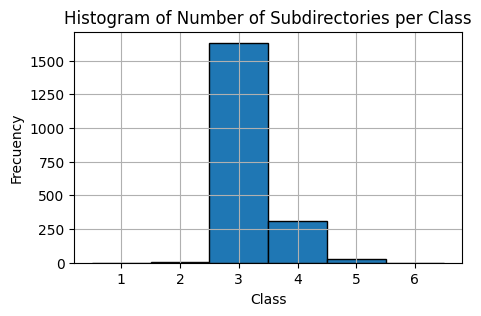

In [ ]:
import matplotlib.pyplot as plt

subdir_df['number_series_id'] = subdir_df['number_series_id'].replace([np.inf, -np.inf], np.nan)
subdir_df = subdir_df.dropna(subset=['number_series_id'])

bins = np.arange(0.5, 7.5, 1)
labels = ['1', '2', '3', '4', '5', '6']

plt.figure(figsize=(5, 3))
plt.hist(subdir_df['number_series_id'], bins=bins, edgecolor='black')

plt.xticks(ticks=np.arange(1, 7), labels=labels)

plt.xlabel('Class')
plt.ylabel('Frecuency')
plt.title('Histogram of Number of Subdirectories per Class')
plt.grid(True)
plt.show()

This implies that for most 'series_id' we have three directories. Below we can compare with the classes present in 'train_series_descriptions' and conclude that in general we have three directories corresponding to 'Axial T2', 'Sagittal T1' and 'Sagittal T2/STIR'

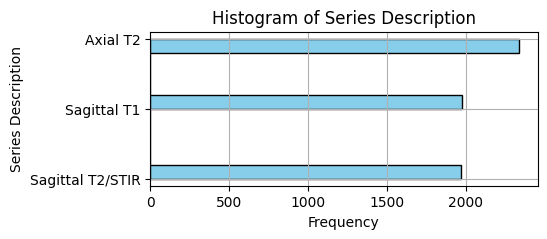

In [ ]:
plt.figure(figsize=(5, 2))
plt.hist(train_series_descriptions['series_description'], color='skyblue', edgecolor='black', orientation='horizontal')
plt.title('Histogram of Series Description')
plt.xlabel('Frequency')
plt.ylabel('Series Description')
plt.grid(True)
plt.show()

We have repetitions of *'Axial T2'* because exists *'study_id'* that uses diferents *'series_id'* asociated to this class.

In [ ]:
print("Cases with 4 subdirectories:")
print(subdir_df[subdir_df.number_series_id == 4].count())
print("Cases with 5 subdirectories:")
print(subdir_df[subdir_df.number_series_id == 5].count())
print("Cases with 6 subdirectories:")
print(subdir_df[subdir_df.number_series_id == 6].count())

Cases with 4 subdirectories:
study_id            309
number_series_id    309
dtype: int64
Cases with 5 subdirectories:
study_id            30
number_series_id    30
dtype: int64
Cases with 6 subdirectories:
study_id            1
number_series_id    1
dtype: int64


Show the case *'study_id'* asociates to six subdirectories

In [ ]:
subdir_df[subdir_df.number_series_id == 6].iloc[0,0]

'4096820034'

In [ ]:
path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'
my_study = subdir_df[subdir_df.number_series_id == 6].iloc[0,0]
get_subdir(path,my_study)

/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4096820034/2097107888
/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4096820034/300517765
/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4096820034/2602265508
/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4096820034/3236751045
/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4096820034/2679683906
/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4096820034/3114813181


In [ ]:
train_series_descriptions

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1
...,...,...,...
6289,4287160193,1507070277,Sagittal T2/STIR
6290,4287160193,1820446240,Axial T2
6291,4290709089,3274612423,Sagittal T2/STIR
6292,4290709089,3390218084,Axial T2


In [ ]:
train_series_descriptions[train_series_descriptions.study_id == 3637444890]

,study_id,series_id,series_description
5330,3637444890,1590743005,Axial T2
5331,3637444890,3671685092,Axial T2
5332,3637444890,3892989905,Sagittal T2/STIR
5333,3637444890,3951475160,Sagittal T1


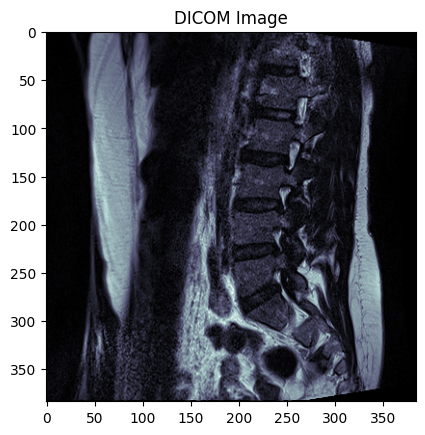

,study_id,series_id,series_description
5997,4096820034,300517765,Axial T2
5998,4096820034,2097107888,Axial T2
5999,4096820034,2602265508,Sagittal T2/STIR
6000,4096820034,2679683906,Axial T2
6001,4096820034,3114813181,Axial T2
6002,4096820034,3236751045,Sagittal T1


In [ ]:
dicom_file_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4096820034/2602265508/10.dcm'

visualize_dicom_image(dicom_file_path)

train_series_descriptions[train_series_descriptions.study_id == 4096820034 ]

In [ ]:
train_label_coordinates[train_label_coordinates.study_id == 4096820034]

,study_id,series_id,instance_number,condition,level,x,y
46392,4096820034,300517765,5,Right Subarticular Stenosis,L4/L5,305.500000,372.444444
46393,4096820034,300517765,11,Right Subarticular Stenosis,L5/S1,298.388889,358.222222
46394,4096820034,2097107888,10,Left Subarticular Stenosis,L1/L2,348.379062,378.070442
46395,4096820034,2097107888,16,Left Subarticular Stenosis,L2/L3,344.193491,369.699299
46396,4096820034,2097107888,22,Left Subarticular Stenosis,L3/L4,342.100705,359.235371
46397,4096820034,2602265508,7,Spinal Canal Stenosis,L1/L2,268.706316,88.525822
46398,4096820034,2602265508,7,Spinal Canal Stenosis,L2/L3,257.288476,135.399061
46399,4096820034,2602265508,7,Spinal Canal Stenosis,L3/L4,247.673452,180.469484
46400,4096820034,2602265508,7,Spinal Canal Stenosis,L4/L5,244.668757,220.732394
46401,4096820034,2602265508,7,Spinal Canal Stenosis,L5/S1,253.081903,260.394366


This demostrate **Afirmation 4** 🟨

#### 🟡 **Afirmation 5**:
When we look at the *'level'* in *train_label_descriptions* for *Spinal Canal Stenosis* we have *'study_id'* cases that exist in *train* and *train_series_descriptions* but not in *train_label_coordinates*. In other words, there is the *pain level* (*'Normal/Mild', 'Moderate', 'Severe'*) in *'train'* in relation to *'Spinal Canal Stenosis'* and we have the * 'series_descriptions'* (*' Sagittal T2/STIR'*) but there are no records in *'train_label_coordinates'*. For example: a) there are 70 cases in *'spinal_canal_stenosis_l1_l2'*, b) 30 cases in *'spinal_canal_stenosis_l2_l3'*, and 2, 3 and 5 in the other cases.

**Proof:**

Now to compare *train['spinal_canal_stenosis_l1_l2']* with *train_merge_T2[train_merge_T2.level=='L1/L2'] and the others cases to observe that exists some diferences

In [ ]:
print("scs_l1_l2 :",compare_column(train.loc[:, ['study_id', 'spinal_canal_stenosis_l1_l2']],train_merge_T2[train_merge_T2.level == 'L1/L2'],'study_id'))
print(" ")
print("scs_l2_l3 :",compare_column(train.loc[:, ['study_id', 'spinal_canal_stenosis_l2_l3']],train_merge_T2[train_merge_T2.level == 'L2/L3'],'study_id'))
print(" ")
print("scs_l3_l4 :",compare_column(train.loc[:, ['study_id', 'spinal_canal_stenosis_l3_l4']],train_merge_T2[train_merge_T2.level == 'L3/L4'],'study_id'))
print(" ")
print("scs_l4_l5 :",compare_column(train.loc[:, ['study_id', 'spinal_canal_stenosis_l4_l5']],train_merge_T2[train_merge_T2.level == 'L4/L5'],'study_id'))
print(" ")
print("scs_l5_s1 :",compare_column(train.loc[:, ['study_id', 'spinal_canal_stenosis_l5_s1']],train_merge_T2[train_merge_T2.level == 'L5/S1'],'study_id'))

scs_l1_l2 : ({3906279426, 2232794498, 1133158151, 267842058, 3428426893, 1868615696, 344297746, 2256339732, 2548543893, 1292979992, 3151371929, 3637444890, 3515641631, 4072455711, 979209761, 2297295777, 1143209760, 893250212, 1722539301, 2279142182, 434488359, 2336516775, 4127969449, 693432872, 1745732011, 998688940, 3189076268, 267989673, 4137194670, 2839003053, 390498354, 74782131, 4232806580, 1567179188, 934686772, 2615694902, 1047914296, 2239199413, 3221995449, 3084269121, 2966999234, 3284652867, 3537214277, 3973705542, 953218250, 1681401548, 3966998094, 376723024, 1187463765, 4146959702, 1452830936, 3674744025, 1613634521, 296083289, 2213304029, 1395773918, 3850173026, 1557387235, 2566719718, 597329259, 305152236, 293713262, 2907745008, 2040217841, 3167888497, 3936691827, 2397650165, 1431195383, 3711891194, 1400326269, 3824720894}, set())
 
scs_l2_l3 : ({2232794498, 1133158151, 1868615696, 2256339732, 2548543893, 1292979992, 3637444890, 4072455711, 2297295777, 893250212, 172253930

This demostrate **Afirmation 4** 🟨

## 2.4 Prepare the data

We build the database with the coordinates of each vertebra

In [ ]:
def pivot_dataframe(df):

    df_pivot = df.pivot_table(index=['study_id', 'series_id', 'instance_number'], columns='level', values=['x', 'y']).reset_index()

    df_pivot.columns = ['study_id', 'series_id', 'instance_number', 'L12x', 'L23x', 'L34x', 'L45x', 'L51x',
                        'L12y', 'L23y', 'L34y', 'L45y', 'L51y']

    df_pivot = df_pivot[['study_id', 'series_id', 'instance_number', 'L12x', 'L12y',
                         'L23x', 'L23y', 'L34x', 'L34y', 'L45x', 'L45y', 'L51x', 'L51y']]

    return df_pivot

pivoted_df = pivot_dataframe(train_merge_T2)
pivoted_df.head()

,study_id,series_id,instance_number,L12x,L12y,L23x,L23y,L34x,L34y,L45x,L45y,L51x,L51y
0,4003253,702807833,8,322.831858,227.964602,320.571429,295.714286,323.030303,371.818182,335.292035,427.327434,353.415929,483.964602
1,4646740,3666319702,9,NaN,NaN,NaN,NaN,233.036940,271.684492,NaN,NaN,NaN,NaN
2,4646740,3666319702,10,241.700041,156.176471,236.887207,222.593583,NaN,NaN,241.700041,324.625668,NaN,NaN
3,4646740,3666319702,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259.026244,370.828877
4,7143189,132939515,9,177.938468,93.727402,172.153502,130.264034,166.763096,165.349566,165.837348,199.602218,175.094822,228.917551


Eliminate the cases where there isn´t all coordinates

In [ ]:
pivoted_df = pivoted_df.dropna()
pivoted_df.reset_index(drop=True)

,study_id,series_id,instance_number,L12x,L12y,L23x,L23y,L34x,L34y,L45x,L45y,L51x,L51y
0,4003253,702807833,8,322.831858,227.964602,320.571429,295.714286,323.030303,371.818182,335.292035,427.327434,353.415929,483.964602
1,7143189,132939515,9,177.938468,93.727402,172.153502,130.264034,166.763096,165.349566,165.837348,199.602218,175.094822,228.917551
2,8785691,481125819,8,181.935484,96.487455,172.186380,128.602151,165.878136,158.996416,161.863799,191.111111,170.465950,215.197133
3,10728036,3491739931,11,297.420479,148.915033,296.305011,213.612200,278.457516,277.193900,272.880174,337.429194,295.189542,387.625272
4,11340341,3543553307,10,250.392110,124.624586,235.669106,183.516605,229.359247,240.305337,234.968010,295.691878,234.968010,352.480611
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,4279958262,2753156679,11,210.038610,95.876448,210.532819,157.652510,194.223938,210.532819,187.799228,261.930502,189.281853,301.961390
1470,4282019580,1547999333,11,217.588235,104.823529,202.305085,151.864407,196.411765,193.764706,203.470588,241.058824,214.058824,274.235294
1471,4283570761,453728183,9,252.096578,148.066797,239.788300,209.608186,232.427696,265.899924,235.546307,315.797706,254.013013,364.807609
1472,4287160193,1507070277,8,391.235190,235.644570,369.435472,321.805360,373.587800,391.356841,397.463681,456.755994,427.568054,516.964739


#### 🟡 **Afirmation 5**:

Exists cases where the coordinates are bad labeled.

**Proof:**

In [ ]:
columns_to_check = ['L12x', 'L12y', 'L23x', 'L23y', 'L34x', 'L34y', 'L45x', 'L45y', 'L51x', 'L51y']
indices_to_drop = pivoted_df[pivoted_df[columns_to_check].lt(43).any(axis=1)].index
pivoted_df.loc[indices_to_drop]

,study_id,series_id,instance_number,L12x,L12y,L23x,L23y,L34x,L34y,L45x,L45y,L51x,L51y
17,38281420,880361156,9,201.911765,69.705882,192.693032,108.474576,184.264706,148.529412,180.147059,182.647059,5.000000,5.000000
140,211314658,931347240,9,148.004386,39.157895,144.960526,74.526316,138.223684,109.894737,132.609649,144.701754,135.416667,164.350877
840,1438760543,737753815,9,5.000042,4.999993,227.246377,207.971014,224.811594,257.478261,239.420290,304.550725,262.956522,339.449275
878,1510451897,1488857550,9,186.029412,67.352941,180.640301,108.474576,176.617647,155.588235,5.000000,4.999982,179.558824,232.058824
1061,1820866003,131094096,7,285.499044,115.518164,5.000000,2.063098,271.793499,240.826004,271.793499,297.606119,282.562141,338.722753
1098,1880970480,3736941525,8,276.008016,190.589178,258.565130,249.074148,248.304609,315.767535,248.304609,370.148297,5.000000,5.000000
1233,2151467507,3086719329,8,323.058824,144.470588,304.451977,206.342750,4.058824,5.000000,286.352941,325.176471,300.470588,364.705882
1234,2151509334,3072714332,9,312.910134,111.602294,305.078394,175.235182,300.183556,237.889101,5.978967,4.021033,297.246654,347.533461
1403,2444340715,3521409198,10,255.000000,146.470588,232.677966,189.468927,211.235294,234.705882,200.647059,270.705882,5.000029,4.999986
1421,2480600394,2969009171,12,190.058824,96.352941,41.039548,174.282486,192.176471,200.823529,208.411765,243.176471,230.294118,287.647059


We can eliminates this cases

In [ ]:
pivoted_df = pivoted_df.drop(indices_to_drop)
pivoted_df.reset_index(drop=True, inplace=True)

This demostrate **Afirmation 5** 🟨

## 2.5 Visualize and transform the images

Now we are going to transform all images to size $224x224$ and visualize the coordinates

In [ ]:
input_base_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'

def process_and_visualize_image(index):
    try:
        row = pivoted_df.iloc[index]
        study_id = int(row['study_id'])
        series_id = int(row['series_id'])
        instance_number = int(row['instance_number'])

        L12x, L12y = int(row['L12x']), int(row['L12y'])
        L23x, L23y = int(row['L23x']), int(row['L23y'])
        L34x, L34y = int(row['L34x']), int(row['L34y'])
        L45x, L45y = int(row['L45x']), int(row['L45y'])
        L51x, L51y = int(row['L51x']), int(row['L51y'])

        dicom_path = os.path.join(input_base_path, str(study_id), str(series_id), f'{instance_number}.dcm')
        ds = pydicom.dcmread(dicom_path)

        img = ds.pixel_array
        img_normalized = ((img - np.min(img)) / (np.max(img) - np.min(img))) * 255
        img_normalized = img_normalized.astype(np.uint8)
        img_resized = Image.fromarray(img_normalized).resize((224, 224), Image.LANCZOS)
        img_resized_np = np.array(img_resized)

        scale_x = 224 / img.shape[1]
        scale_y = 224 / img.shape[0]

        L12x_scaled, L12y_scaled = int(L12x * scale_x), int(L12y * scale_y)
        L23x_scaled, L23y_scaled = int(L23x * scale_x), int(L23y * scale_y)
        L34x_scaled, L34y_scaled = int(L34x * scale_x), int(L34y * scale_y)
        L45x_scaled, L45y_scaled = int(L45x * scale_x), int(L45y * scale_y)
        L51x_scaled, L51y_scaled = int(L51x * scale_x), int(L51y * scale_y)

        plt.figure(figsize=(8, 8))
        plt.subplot(2, 2, 1)
        plt.imshow(img, cmap=plt.cm.bone)
        plt.title(f'Original Image{study_id}_{series_id}_{instance_number}')
        plt.scatter([L12x, L51x], [L12y, L51y], c='red', marker='x')

        plt.subplot(2, 2, 2)
        plt.imshow(img_resized_np, cmap=plt.cm.bone)
        plt.title('Image Resized to 224x224')
        plt.scatter([L12x_scaled, L51x_scaled], [L12y_scaled, L51y_scaled], c='red', marker='x')

        # After a review we will make a cut using the minimums and maximums
        y_min = 0 # L12y_scaled - 15 # 30 # max(0,0) # L12y_scaled - 15)
        y_max = 224 # L51y_scaled + 25 #min(224,224)# L51y_scaled + 25)
        x_min = 0#min(L12x_scaled,L23x_scaled,L34x_scaled,L45x_scaled,L51x_scaled) - 50 # 30 #max(0, 0)# L12x_scaled - 60)
        x_max = 224#max(L12x_scaled,L23x_scaled,L34x_scaled,L45x_scaled,L51x_scaled) + 25 #min(224,224)# L51x_scaled + 20)

        img_cropped = img_resized_np[y_min:y_max, x_min:x_max]

        img_cropped_pil = Image.fromarray(img_cropped)
        padding_top_bottom = (224 - img_cropped.shape[0]) // 2
        padding_left_right = (224 - img_cropped.shape[1]) // 2
        img_padded = ImageOps.expand(img_cropped_pil,
                                     border=(padding_left_right, padding_top_bottom),
                                     fill=0)
        img_padded_np = np.array(img_padded)

        plt.subplot(2, 2, 3)
        plt.imshow(img_padded_np, cmap=plt.cm.bone)
        plt.title('Cropped Image with Padding')

        def adjust_coord(x, y, x_min, y_min):
            return (x - x_min + padding_left_right, y - y_min + padding_top_bottom)

        coords = [
            adjust_coord(L12x_scaled, L12y_scaled, x_min, y_min),
            adjust_coord(L23x_scaled, L23y_scaled, x_min, y_min),
            adjust_coord(L34x_scaled, L34y_scaled, x_min, y_min),
            adjust_coord(L45x_scaled, L45y_scaled, x_min, y_min),
            adjust_coord(L51x_scaled, L51y_scaled, x_min, y_min)
        ]

        plt.subplot(2, 2, 4)
        plt.imshow(img_padded_np, cmap=plt.cm.bone)
        plt.title('Cropped Image with Coordinates')
        for (x, y) in coords:
            plt.scatter(x, y, c='red', marker='p')
            plt.text(x, y, f'({x}, {y})', color='red')

        plt.show()
    except Exception as e:
        print(f"Error processing file {dicom_path}: {e}")

total_images = len(pivoted_df)
interact(process_and_visualize_image, index=IntSlider(min=0, max=total_images-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='index', max=1462), Output()), _dom_classes=('widget-inte…

<function __main__.process_and_visualize_image(index)>

Tranforms the images and save new coordinates in *m1_pivoted_df.csv*

In [ ]:
from tqdm import tqdm

input_base_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'
output_base_path = '/kaggle/working/train_ima_vert_m1'

if not os.path.exists(output_base_path):
    os.makedirs(output_base_path)

def process_image(row):
    study_id = int(row['study_id'])
    series_id = int(row['series_id'])
    instance_number = int(row['instance_number'])

    L12x, L12y = int(row['L12x']), int(row['L12y'])
    L23x, L23y = int(row['L23x']), int(row['L23y'])
    L34x, L34y = int(row['L34x']), int(row['L34y'])
    L45x, L45y = int(row['L45x']), int(row['L45y'])
    L51x, L51y = int(row['L51x']), int(row['L51y'])

    dicom_path = os.path.join(input_base_path, str(study_id), str(series_id), f'{instance_number}.dcm')
    ds = pydicom.dcmread(dicom_path)

    img = ds.pixel_array
    img_normalized = ((img - np.min(img)) / (np.max(img) - np.min(img))) * 255
    img_normalized = img_normalized.astype(np.uint8)
    img_resized = Image.fromarray(img_normalized).resize((224, 224), Image.LANCZOS)
    img_resized_np = np.array(img_resized)

    scale_x = 224 / img.shape[1]
    scale_y = 224 / img.shape[0]

    L12x_scaled, L12y_scaled = int(L12x * scale_x), int(L12y * scale_y)
    L23x_scaled, L23y_scaled = int(L23x * scale_x), int(L23y * scale_y)
    L34x_scaled, L34y_scaled = int(L34x * scale_x), int(L34y * scale_y)
    L45x_scaled, L45y_scaled = int(L45x * scale_x), int(L45y * scale_y)
    L51x_scaled, L51y_scaled = int(L51x * scale_x), int(L51y * scale_y)

     # After a review we will make a cut using the minimums and maximums
    y_min = 0 # L12y_scaled - 15 # 30 # max(0,0) # L12y_scaled - 15)
    y_max = 224 # L51y_scaled + 25 #min(224,224)# L51y_scaled + 25)
    x_min = 0#min(L12x_scaled,L23x_scaled,L34x_scaled,L45x_scaled,L51x_scaled) - 50 # 30 #max(0, 0)# L12x_scaled - 60)
    x_max = 224#max(L12x_scaled,L23x_scaled,L34x_scaled,L45x_scaled,L51x_scaled) + 25 #min(224,224)# L51x_scaled + 20)

    img_cropped = img_resized_np[y_min:y_max, x_min:x_max]

    img_cropped_pil = Image.fromarray(img_cropped)
    padding_top_bottom = (224 - img_cropped.shape[0]) // 2
    padding_left_right = (224 - img_cropped.shape[1]) // 2
    img_padded = ImageOps.expand(img_cropped_pil,
                                border=(padding_left_right, padding_top_bottom),
                                fill=0)
    img_padded_np = np.array(img_padded)

    def adjust_coord(x, y, x_min, y_min):
        return (x - x_min + padding_left_right, y - y_min + padding_top_bottom)

    new_coords = {
        'L12x': adjust_coord(L12x_scaled, L12y_scaled, x_min, y_min)[0],
        'L12y': adjust_coord(L12x_scaled, L12y_scaled, y_min, x_min)[1],
        'L23x': adjust_coord(L23x_scaled, L23y_scaled, x_min, y_min)[0],
        'L23y': adjust_coord(L23x_scaled, L23y_scaled, y_min, x_min)[1],
        'L34x': adjust_coord(L34x_scaled, L34y_scaled, x_min, y_min)[0],
        'L34y': adjust_coord(L34x_scaled, L34y_scaled, y_min, x_min)[1],
        'L45x': adjust_coord(L45x_scaled, L45y_scaled, x_min, y_min)[0],
        'L45y': adjust_coord(L45x_scaled, L45y_scaled, y_min, x_min)[1],
        'L51x': adjust_coord(L51x_scaled, L51y_scaled, x_min, y_min)[0],
        'L51y': adjust_coord(L51x_scaled, L51y_scaled, y_min, x_min)[1],
    }

    output_filename = f'{study_id}_{series_id}_{instance_number}.jpg'
    output_path = os.path.join(output_base_path, output_filename)
    img_padded.save(output_path)

    return new_coords, output_path

new_data = []
for idx, row in tqdm(pivoted_df.iterrows(), total=pivoted_df.shape[0], desc="Processing images"):
    new_coords, output_path = process_image(row)
    new_row = row.to_dict()
    new_row.update(new_coords)
    new_row['image_path'] = output_path
    new_data.append(new_row)

new_pivoted_df = pd.DataFrame(new_data)

new_pivoted_df.to_csv('/kaggle/working/m1_pivoted_df.csv', index=False)

print("Completed process. The transformed images have been saved and the new DataFrame has been created.")

Processing images: 100%|██████████| 1463/1463 [00:38<00:00, 37.84it/s]

Completed process. The transformed images have been saved and the new DataFrame has been created.


In [ ]:
m1_pivoted_df = pd.read_csv('/kaggle/working/m1_pivoted_df.csv')
m1_pivoted_df['study_id'] = m1_pivoted_df['study_id'].astype(int)
m1_pivoted_df['series_id'] = m1_pivoted_df['series_id'].astype(int)
m1_pivoted_df['instance_number'] = m1_pivoted_df['instance_number'].astype(int)
m1_pivoted_df = m1_pivoted_df.drop(['image_path'], axis=1)
m1_pivoted_df

,study_id,series_id,instance_number,L12x,L12y,L23x,L23y,L34x,L34y,L45x,L45y,L51x,L51y
0,4003253,702807833,8,112,79,112,103,113,129,117,149,123,169
1,7143189,132939515,9,123,65,120,91,116,115,115,139,122,159
2,8785691,481125819,8,126,67,120,89,115,110,112,133,118,150
3,10728036,3491739931,11,129,64,129,93,121,121,119,147,129,169
4,11340341,3543553307,10,125,62,117,91,114,120,117,147,117,176
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,4279958262,2753156679,11,122,55,122,91,113,122,109,152,110,175
1459,4282019580,1547999333,11,126,60,117,88,114,112,118,140,124,159
1460,4283570761,453728183,9,126,71,119,101,116,128,117,152,127,176
1461,4287160193,1507070277,8,119,71,112,97,113,119,120,138,129,157


Let's see what the maximum and minimum values are for the coordinates and do a second transformation to make the training more efficient. These values ​​will allow us later to have a limit for the size of the rectangle in which each intervertebral level will be segmented.

In [ ]:
columns_to_check_x = ['L12x', 'L23x', 'L34x', 'L45x', 'L51x']
columns_to_check_y = ['L12y', 'L23y', 'L34y', 'L45y', 'L51y']
minx = []
maxx = []
miny = []
maxy = []

for i in columns_to_check_x:
    min_x = min(m1_pivoted_df[i])
    max_x = max(m1_pivoted_df[i])
    minx.append(min_x)
    maxx.append(max_x)
print("min(x) =",min(minx), "y max(x) =",max(maxx))

for i in columns_to_check_y:
    min_y = min(m1_pivoted_df[i])
    max_y = max(m1_pivoted_df[i])
    miny.append(min_y)
    maxy.append(max_y)
print("min(y) =",min(miny), "y max(y) =",max(maxy))

min(x) = 31 y max(x) = 172
min(y) = 31 y max(y) = 198


## 2.6 Models to predict the intervertebral level

#### 🟡 **Afirmation 7**:
With 20 epochs of ResNet50 model predicts much better than ResNet18, ViT and ResNet18.

Now we are going to design four models. All models are trained with 20 epochs, we use data augmentation, we apply the Adam optimizer and we use MSE to calculate the loss, we use 70% of the data for training, 15% for validation and the remaining 15% for testing. These values will allow us later to have a limit for the size of the rectangle in which each intervertebral level will be segmented. Finally their results are compared to choose the best option as for the model that minimizes the mean square error most quickly. By doing some tests we can see the performance and accuracy of each model.

## 2.6.1. ResNet18

We save the model as *spinenet_model.pth*

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
import matplotlib.pyplot as plt

class SpineNet(nn.Module):
    def __init__(self, pretrained=True):
        super(SpineNet, self).__init__()
        self.backbone = resnet18(weights='DEFAULT' if pretrained else None)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 10)

    def forward(self, x):
        return self.backbone(x)

class SpineDataset(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.data = dataframe
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        study_id = int(row['study_id'])
        series_id = int(row['series_id'])
        instance_number = int(row['instance_number'])
        image_path = os.path.join(self.images_dir, f'{study_id}_{series_id}_{instance_number}.jpg')

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        coords = torch.tensor(
            [row[key] for key in ['L12x', 'L12y', 'L23x', 'L23y', 'L34x', 'L34y', 'L45x', 'L45y', 'L51x', 'L51y']],
            dtype=torch.float32)
        return image, coords

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if not batch:
        return torch.zeros((1, 3, 224, 224)), torch.zeros((1, 10))
    images, coords = zip(*batch)
    images = torch.stack(images)
    coords = torch.stack(coords)
    return images, coords

# Data augmentation transformations for the training images
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),    # Random vertical flip
    transforms.RandomRotation(30),      # Random rotation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Simple transformations for validation and testing
val_transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Update the image path
image_path = '/kaggle/working/train_ima_vert_m1'

# Create dataset
dataset = SpineDataset(m1_pivoted_df, images_dir=image_path, transform=None)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f'Number of images in training: {(train_size)}')
print(f'Number of images in validation: {(val_size)}')
print(f'Number of images under test: {(test_size)}')

# Assign transformations
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

model = SpineNet(pretrained=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cuda'):
    model.to(device)
    best_model_wts = model.state_dict()
    best_loss = float('inf')

    # Store losses for plotting
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0

            for inputs, labels in dataloader:
                if inputs is None or labels is None:
                    continue

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            # Print the results in a compact format
            if phase == 'val':
                print(f'Epoch {epoch + 1}/{num_epochs} | '
                      f'Train Loss: {train_losses[-1]:.4f} | '
                      f'Val Loss: {val_losses[-1]:.4f}')

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()

    print(f'Best val loss: {best_loss:4f}')
    model.load_state_dict(best_model_wts)

    # Plot the training and validation losses
    plt.figure(figsize=(5, 5))
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    return model

model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)

# Evaluate the model on the test dataset
def evaluate_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    model.to(device)
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

    test_loss = running_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

# Evaluate the trained model
evaluate_model(model, test_loader, criterion, device=device)

# Save the model to a file
model_save_path = '/kaggle/working/spinenet_model.pth'  # Define the save path
torch.save(model.state_dict(), model_save_path)  # Save the model
print(f"Model saved to {model_save_path}")


let's make some predictions using this model

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to load and preprocess DICOM image for prediction
def load_and_preprocess_dicom(image_path):
    try:
        ds = pydicom.dcmread(image_path)
        img = ds.pixel_array
        img = np.stack([img] * 3, axis=-1)  # Convert to RGB

        # Convert to float32 and normalize to [0, 1]
        img = img.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        # Convert to uint8 for compatibility with ToPILImage
        img = (img * 255).astype(np.uint8)

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        return transform(img)
    except pydicom.errors.InvalidDicomError:
        print(f"Invalid DICOM file: {image_path}")
        return None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Function to make a prediction
def predict(image_path, model, device):
    model.eval()
    image = load_and_preprocess_dicom(image_path)
    if image is None:
        print("Failed to load and preprocess the image.")
        return None

    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    try:
        with torch.no_grad():
            output = model(image)
        #print(f"Model output: {output}")
        return output.cpu().numpy().flatten()  # Flatten the output for easier access
    except Exception as e:
        print(f"Error during model prediction: {e}")
        return None

# Function to plot resized image and draw predicted rectangles
def plot_with_predictions(image_path, coordinates):
    # Load the image for display
    ds = pydicom.dcmread(image_path)
    img = ds.pixel_array
    img = np.stack([img] * 3, axis=-1)  # Convert to RGB

    # Convert to float32 and normalize for visualization
    img = img.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    img = img.astype(np.uint8)

    # Convert image to PIL and resize
    img_pil = Image.fromarray(img)
    img_resized = img_pil.resize((224, 224))

    fig, ax = plt.subplots(1, figsize=(5, 5))
    ax.imshow(img_resized)

    # Draw rectangles centered at each predicted coordinate
    for i in range(0, len(coordinates), 2):
        x_center = coordinates[i]
        y_center = coordinates[i + 1]
        rect_width = 35  # Width of the rectangle
        rect_height = 20  # Height of the rectangle
        rect = patches.Rectangle((x_center - rect_width / 2, y_center - rect_height / 2 + 5),
                                 rect_width, rect_height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('on')
    plt.show()

# Example usage
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1004726367/2526352865/9.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/3844393089/11.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/2092806862/8.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1004726367/2526352865/9.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1035170868/2727057862/9.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1004726367/2526352865/9.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1557387235/2143604834/8.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/3844393089/12.dcm'
image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1557387235/2143604834/8.dcm'

model_path = '/kaggle/working/spinenet_model.pth'

# Configure the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model
model = SpineNet(pretrained=False)
try:
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
except Exception as e:
    print(f"Error loading model: {e}")

# Get the predicted coordinates
predicted_coordinates = predict(image_path, model, device)
print(f'Predicted coordinates: {predicted_coordinates}')

# Plot the resized image with predicted rectangles
if predicted_coordinates is not None:
    plot_with_predictions(image_path, predicted_coordinates)
else:
    print("Prediction failed.")

## 2.6.2 VIT-Transformer

The model is saved as *spinevit_model.pth*

In [ ]:
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTModel
from torch.optim import AdamW as PyTorchAdamW
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Configure the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataFrame with the training data
data_train = m1_pivoted_df

# Divide the dataset into training, validation, and test sets
train_df, test_df = train_test_split(data_train, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

print(f'Number of images in training: {len(train_df)}')
print(f'Number of images in validation: {len(val_df)}')
print(f'Number of images under test: {len(test_df)}')

# Custom Dataset
class ST1VertebralDataset(Dataset):
    def __init__(self, images_dir, dataframe, transform=None):
        self.data = dataframe
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        study_id = int(row['study_id'])
        series_id = int(row['series_id'])
        instance_number = int(row['instance_number'])
        image_path = os.path.join(self.images_dir, f'{study_id}_{series_id}_{instance_number}.jpg')

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Obtain coordinates of the branches
        coordinates = row[['L12x', 'L12y', 'L23x', 'L23y', 'L34x', 'L34y', 'L45x', 'L45y', 'L51x', 'L51y']].values
        coordinates = coordinates.astype(np.float32)

        return image, coordinates

# Data augmentation transformations for the images
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),    # Random vertical flip
    transforms.RandomRotation(30),      # Random rotation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Color jitter
    transforms.Resize((224, 224)),      # Resize to the input size of ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom ViT model for regression
class ViTModelForRegression(nn.Module):
    def __init__(self, num_coords=10):
        super(ViTModelForRegression, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.regression_head = nn.Linear(self.vit.config.hidden_size, num_coords)

    def forward(self, x):
        outputs = self.vit(x)
        pooled_output = outputs.last_hidden_state[:, 0]
        coords = self.regression_head(pooled_output)
        return coords

def main():
    # Create the dataset and DataLoader
    images_dir = '/kaggle/working/train_ima_vert_m1'
    train_dataset = ST1VertebralDataset(images_dir=images_dir, dataframe=train_df, transform=transform)
    val_dataset = ST1VertebralDataset(images_dir=images_dir, dataframe=val_df, transform=transform)
    test_dataset = ST1VertebralDataset(images_dir=images_dir, dataframe=test_df, transform=transform)

    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)  # Set num_workers=0
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)    # Set num_workers=0
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)  # Set num_workers=0

    # Initialize the model, optimizer, and loss functions
    num_coords = 10  # Example: five key points with (x, y) coordinates
    model = ViTModelForRegression(num_coords)
    model.to(device)

    optimizer = PyTorchAdamW(model.parameters(), lr=1e-4)
    regression_loss_fn = nn.MSELoss()

    num_epochs = 20

    # Training function
    def train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs):
        train_losses = []
        val_losses = []
        for epoch in range(num_epochs):
            model.train()
            total_regression_loss = 0.0

            for images, coordinates in train_dataloader:#MODELtqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
                images = images.to(device)
                coordinates = coordinates.to(device)

                optimizer.zero_grad()

                predicted_coords = model(images)
                regression_loss = regression_loss_fn(predicted_coords, coordinates)

                regression_loss.backward()
                optimizer.step()

                total_regression_loss += regression_loss.item()

            avg_train_regression_loss = total_regression_loss / len(train_dataloader)
            train_losses.append(avg_train_regression_loss)

            # Evaluate the model on the validation set
            model.eval()
            val_regression_loss = 0.0
            with torch.no_grad():
                for images, coordinates in val_dataloader:
                    images = images.to(device)
                    coordinates = coordinates.to(device)

                    predicted_coords = model(images)
                    regression_loss = regression_loss_fn(predicted_coords, coordinates)

                    val_regression_loss += regression_loss.item()

            avg_val_regression_loss = val_regression_loss / len(val_dataloader)
            val_losses.append(avg_val_regression_loss)

            print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_regression_loss:.4f} | Val Loss: {avg_val_regression_loss:.4f}')
            #print(f'Epoch {epoch+1}/{num_epochs}, Validation Regression Loss: {avg_val_regression_loss:.4f}')

        return train_losses, val_losses

    # Train the model
    train_losses, val_losses = train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs)

    # Save the model
    model_save_path = '/kaggle/working/spinevit_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"Modelo guardado en: {model_save_path}")

    # Plot training and validation losses
    plt.figure(figsize=(5, 5))
    plt.plot(train_losses, label='Train Regression Loss')
    plt.plot(val_losses, label='Validation Regression Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Regression Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Evaluate the model on the test set
    def evaluate_model(model, dataloader, device):
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, coordinates in tqdm(dataloader, desc='Evaluating'):
                images = images.to(device)
                coordinates = coordinates.to(device)

                predicted_coords = model(images)
                all_preds.extend(predicted_coords.cpu().numpy())
                all_labels.extend(coordinates.cpu().numpy())

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        mse = np.mean((all_labels - all_preds) ** 2)
        return mse

    # Evaluate the model on the test set
    test_mse = evaluate_model(model, test_dataloader, device)
    print(f'Test Mean Squared Error: {test_mse:.4f}')

if __name__ == '__main__':
    main()


Now we make a predicctions with this model

In [ ]:
import os
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification, ViTConfig
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom
import cv2
from collections import OrderedDict

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the class labels
class_labels = {0: 'L1/L2', 1: 'L2/L3', 2: 'L3/L4', 3: 'L4/L5', 4: 'L5/S1'}

# Define transformations for the images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define your model class if not already defined
class ViTModelWithCoordRegression(ViTForImageClassification):
    def __init__(self, config):
        super().__init__(config)
        self.regressor = torch.nn.Linear(config.hidden_size, 10)  # 10 coordinates (5 points x 2 coordinates)
        self.classifier = nn.Identity()  # Do not use the classification head

    def forward(self, pixel_values, labels=None):
        outputs = self.vit(pixel_values)
        sequence_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        logits = self.regressor(sequence_output)

        loss = None
        if labels is not None:
            loss = torch.nn.MSELoss()(logits, labels)

        return (loss, logits) if loss is not None else logits

# Load the configuration and model
config = ViTConfig.from_pretrained('google/vit-base-patch16-224', num_labels=10)
model = ViTModelWithCoordRegression(config)
model.to(device)

# Load the trained model state
model_save_path = '/kaggle/working/spinevit_model.pth'
state_dict = torch.load(model_save_path, map_location=device, weights_only=True)

# Fix the state dict keys
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if 'regression_head' in k:
        new_key = k.replace('regression_head', 'regressor')
    elif 'classifier' in k:
        continue  # Skip the classifier keys
    else:
        new_key = k
    new_state_dict[new_key] = v

model.load_state_dict(new_state_dict, strict=False)
model.eval()

# Function to load and transform a DICOM image
def load_and_transform_dicom(image_path):
    ds = pydicom.dcmread(image_path)
    img = ds.pixel_array
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to RGB if necessary
    img = cv2.resize(img, (224, 224))
    img = cv2.convertScaleAbs(img, alpha=(255.0/65535.0))  # Convert to uint8
    img = transform(img)
    return img.unsqueeze(0)  # Add batch dimension

# Function to predict coordinates
def predict_coordinates(model, image_path):
    image = load_and_transform_dicom(image_path).to(device)
    print(f'Image shape after transformation: {image.shape}')
    print(" ")
    with torch.no_grad():
        outputs = model(image)
        print(f'Outputs from model: {outputs}')
        print(" ")
        coordinates = outputs.cpu().numpy().flatten()  # Get the predicted coordinates
        print(f'Predicted coordinates shape: {coordinates.shape}')
        print(" ")
    return coordinates

# Convert coordinates to readable format
def format_coordinates(coordinates):
    formatted_coordinates = {}
    for i in range(5):
        formatted_coordinates[f'L{i+1}'] = (coordinates[2*i], coordinates[2*i + 1])
    return formatted_coordinates

# Function to visualize image and coordinates
def visualize_image_with_coordinates(image_path, coordinates):
    ds = pydicom.dcmread(image_path)
    img = ds.pixel_array
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (224, 224))

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.scatter(
        [coordinates[f'L{i+1}'][0] for i in range(5)],
        [coordinates[f'L{i+1}'][1] for i in range(5)],
        color='red', marker='X'
    )

    # Draw rectangles centered at each predicted coordinate
    for i in range(5):
        x_center = coordinates[f'L{i+1}'][0]
        y_center = coordinates[f'L{i+1}'][1]
        rect_width = 35  # Width of the rectangle
        rect_height = 20  # Height of the rectangle
        rect = patches.Rectangle((x_center - rect_width / 2, y_center - rect_height / 2),
                                 rect_width, rect_height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Example prediction
# Example usage
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1004726367/2526352865/9.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/3844393089/11.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/2092806862/8.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1004726367/2526352865/9.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1035170868/2727057862/9.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1004726367/2526352865/9.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1557387235/2143604834/8.dcm'
image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1557387235/2143604834/8.dcm'

predicted_coordinates = predict_coordinates(model, image_path)
formatted_coordinates = format_coordinates(predicted_coordinates)
print(f'Predicted coordinates for {image_path}:')
print(" ")
print(formatted_coordinates)

# Visualize the image with predicted coordinates
visualize_image_with_coordinates(image_path, formatted_coordinates)


## 2.6.3 ResNet50

We save the model like *spinenet20_model.pth*

Number of images in training: 1024
Number of images in validation: 219
Number of images under test: 220


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s] 


Epoch 1/100 | Train Loss: 13694.9214 | Val Loss: 7369.9079
Epoch 2/100 | Train Loss: 7351.9281 | Val Loss: 5838.4325
Epoch 3/100 | Train Loss: 3534.5720 | Val Loss: 3785.2112
Epoch 4/100 | Train Loss: 1725.0162 | Val Loss: 1487.3053
Epoch 5/100 | Train Loss: 818.9191 | Val Loss: 604.7327
Epoch 6/100 | Train Loss: 388.9799 | Val Loss: 541.9472
Epoch 7/100 | Train Loss: 206.5512 | Val Loss: 147.3964
Epoch 8/100 | Train Loss: 131.1782 | Val Loss: 111.5447
Epoch 9/100 | Train Loss: 102.6679 | Val Loss: 126.9028
Epoch 10/100 | Train Loss: 92.6924 | Val Loss: 156.2082
Epoch 11/100 | Train Loss: 89.5222 | Val Loss: 97.1860
Epoch 12/100 | Train Loss: 84.9320 | Val Loss: 94.1306
Epoch 13/100 | Train Loss: 82.5451 | Val Loss: 89.9468
Epoch 14/100 | Train Loss: 80.4403 | Val Loss: 88.2794
Epoch 15/100 | Train Loss: 73.7981 | Val Loss: 73.2481
Epoch 16/100 | Train Loss: 64.5829 | Val Loss: 60.4243
Epoch 17/100 | Train Loss: 54.1135 | Val Loss: 80.9408
Epoch 18/100 | Train Loss: 49.7697 | Val Loss:

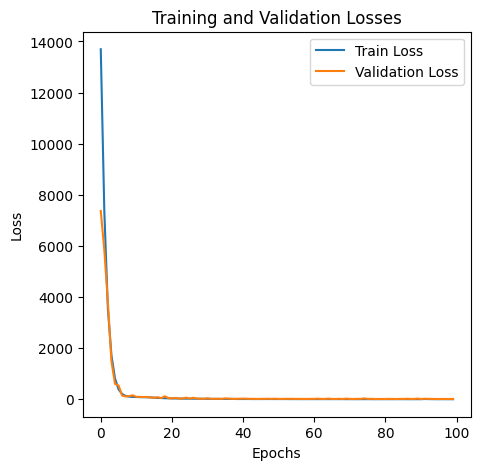

Model saved to /kaggle/working/spinenet20_model.pth
Test Loss: 12.1818


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
import matplotlib.pyplot as plt

class SpineNet(nn.Module):
    def __init__(self, pretrained=True):
        super(SpineNet, self).__init__()
        self.backbone = resnet50(weights='DEFAULT' if pretrained else None)  # Use resnet50
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 10)

    def forward(self, x):
        return self.backbone(x)

class SpineDataset(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.data = dataframe
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        study_id = int(row['study_id'])
        series_id = int(row['series_id'])
        instance_number = int(row['instance_number'])
        image_path = os.path.join(self.images_dir, f'{study_id}_{series_id}_{instance_number}.jpg')

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        coords = torch.tensor(
            [row[key] for key in ['L12x', 'L12y', 'L23x', 'L23y', 'L34x', 'L34y', 'L45x', 'L45y', 'L51x', 'L51y']],
            dtype=torch.float32)
        return image, coords

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if not batch:
        return torch.zeros((1, 3, 224, 224)), torch.zeros((1, 10))
    images, coords = zip(*batch)
    images = torch.stack(images)
    coords = torch.stack(coords)
    return images, coords

# Data augmentation transformations for the training images
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),    # Random vertical flip
    transforms.RandomRotation(30),      # Random rotation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Simple transformations for validation and testing
val_transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Update the image path
image_path = '/kaggle/working/train_ima_vert_m1'

# Create dataset
dataset = SpineDataset(m1_pivoted_df, images_dir=image_path, transform=None)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f'Number of images in training: {(train_size)}')
print(f'Number of images in validation: {(val_size)}')
print(f'Number of images under test: {(test_size)}')

# Assign transformations
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

model = SpineNet(pretrained=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cuda'):
    model.to(device)
    best_model_wts = model.state_dict()
    best_loss = float('inf')

    # Store losses for plotting
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0

            for inputs, labels in dataloader:
                if inputs is None or labels is None:
                    continue

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            # Print the results in a compact format
            if phase == 'val':
                print(f'Epoch {epoch + 1}/{num_epochs} | '
                      f'Train Loss: {train_losses[-1]:.4f} | '
                      f'Val Loss: {val_losses[-1]:.4f}')

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()

    print(f'Best val loss: {best_loss:4f}')
    model.load_state_dict(best_model_wts)

    # Plot the training and validation losses
    plt.figure(figsize=(5, 5))
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    return model

model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)

# Save the model to a file
model_save_path = '/kaggle/working/spinenet20_model.pth'  # Define the save path
torch.save(model.state_dict(), model_save_path)  # Save the model
print(f"Model saved to {model_save_path}")


# Evaluate the model on the test dataset
def evaluate_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    model.to(device)
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

    test_loss = running_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

# Evaluate the trained model
evaluate_model(model, test_loader, criterion, device=device)


Let's now make predictions from some images

Predicted coordinates: [139.60771   55.86853  131.47632   85.13749  127.664825 114.33114
 132.02055  141.43123  144.50276  161.5373  ]


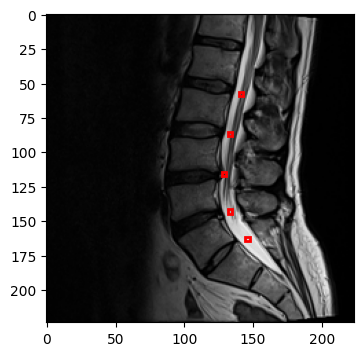

In [ ]:
import torch
from torch import nn
from torchvision.models import resnet50
from PIL import Image
import torchvision.transforms as transforms
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the SpineNet class using ResNet50
class SpineNet(nn.Module):
    def __init__(self, pretrained=True):
        super(SpineNet, self).__init__()
        self.backbone = resnet50(weights='DEFAULT' if pretrained else None)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 10)

    def forward(self, x):
        return self.backbone(x)

# Function to load and preprocess DICOM image for prediction
def load_and_preprocess_dicom(image_path):
    try:
        ds = pydicom.dcmread(image_path)
        img = ds.pixel_array
        img = np.stack([img] * 3, axis=-1)  # Convert to RGB

        # Convert to float32 and normalize to [0, 1]
        img = img.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        # Convert to uint8 for compatibility with ToPILImage
        img = (img * 255).astype(np.uint8)

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        return transform(img)
    except pydicom.errors.InvalidDicomError:
        print(f"Invalid DICOM file: {image_path}")
        return None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Function to make a prediction
def predict(image_path, model, device):
    model.eval()
    image = load_and_preprocess_dicom(image_path)
    if image is None:
        print("Failed to load and preprocess the image.")
        return None

    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    try:
        with torch.no_grad():
            output = model(image)
        #print(f"Model output: {output}")
        return output.cpu().numpy().flatten()  # Flatten the output for easier access
    except Exception as e:
        print(f"Error during model prediction: {e}")
        return None

# Function to plot resized image and draw predicted rectangles
def plot_with_predictions(image_path, coordinates):
    # Load the image for display
    ds = pydicom.dcmread(image_path)
    img = ds.pixel_array
    img = np.stack([img] * 3, axis=-1)  # Convert to RGB

    # Convert to float32 and normalize for visualization
    img = img.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    img = img.astype(np.uint8)

    # Convert image to PIL and resize
    img_pil = Image.fromarray(img)
    img_resized = img_pil.resize((224, 224))

    fig, ax = plt.subplots(1, figsize=(4, 4))
    ax.imshow(img_resized)

    # Draw rectangles centered at each predicted coordinate
    for i in range(0, len(coordinates), 2):
        x_center = coordinates[i]
        y_center = coordinates[i + 1]
        #rect_width = 40  # Width of the rectangle
        #rect_height = 25  # Height of the rectangle
        rect = patches.Rectangle((x_center , y_center ),
                                 3, 3, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('on')
    plt.show()

# Example usage
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1004726367/2526352865/9.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/3844393089/11.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/2092806862/8.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1004726367/2526352865/9.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1035170868/2727057862/9.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1004726367/2526352865/9.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1557387235/2143604834/8.dcm'
image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1557387235/2143604834/8.dcm'

model_path = '/kaggle/working/spinenet20_model.pth'

# Configure the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model
model = SpineNet(pretrained=False)
try:
    #model.load_state_dict(torch.load(model_path, map_location=device))
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
except Exception as e:
    print(f"Error loading model: {e}")

# Get the predicted coordinates
predicted_coordinates = predict(image_path, model, device)
print(f'Predicted coordinates: {predicted_coordinates}')

# Plot the resized image with predicted rectangles
if predicted_coordinates is not None:
    plot_with_predictions(image_path, predicted_coordinates)
else:
    print("Prediction failed.")

## 2.6.4 YOLO

Let's define the model to train

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.optim import AdamW
import matplotlib.pyplot as plt

# Configure the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataFrame with the training data
data_train = pd.read_csv('/kaggle/working/m1_pivoted_df.csv')

# Divide the dataset into training, validation, and test sets
train_df, test_df = train_test_split(data_train, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

print(f'Number of images in training: {len(train_df)}')
print(f'Number of images in validation: {len(val_df)}')
print(f'Number of images under test: {len(test_df)}')

class ST1VertebralDataset(Dataset):
    def __init__(self, images_dir, labels_df, transform=None):
        self.images_dir = images_dir
        self.labels_df = labels_df
        self.transform = transform
        self.image_filenames = self.labels_df['image_path'].tolist()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        image_path = os.path.join(self.images_dir, image_filename)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Read the tags corresponding to the current image from the DataFrame
        label_row = self.labels_df[self.labels_df['image_path'] == image_filename]
        labels = label_row[['L12x', 'L12y', 'L23x', 'L23y', 'L34x', 'L34y', 'L45x', 'L45y', 'L51x', 'L51y']].values[0]
        labels = torch.tensor(labels, dtype=torch.float32)  # Convert labels to tensor

        return image, labels

# Data augmentation transformations for the images
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# YOLO Head
class YOLOHead(nn.Module):
    def __init__(self, num_outputs):
        super(YOLOHead, self).__init__()
        self.conv1 = nn.Conv2d(2048, 512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.gelu = nn.GELU()
        self.conv2 = nn.Conv2d(512, num_outputs, kernel_size=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.conv2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Adjust output to have the same size [batch_size, num_outputs]
        return x

# YOLO Model
class YOLOModel(nn.Module):
    def __init__(self, num_outputs):
        super(YOLOModel, self).__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])  # Remove the last layers
        self.yolo_head = YOLOHead(num_outputs=num_outputs)

    def forward(self, x):
        x = self.backbone(x)
        outputs = self.yolo_head(x)
        return outputs

def main():
    # Create the dataset and DataLoader
    images_dir = '/kaggle/working/train_ima_vert_m1'

    train_dataset = ST1VertebralDataset(
        images_dir=images_dir,
        labels_df=train_df,
        transform=transform
    )

    val_dataset = ST1VertebralDataset(
        images_dir=images_dir,
        labels_df=val_df,
        transform=transform
    )

    test_dataset = ST1VertebralDataset(
        images_dir=images_dir,
        labels_df=test_df,
        transform=transform
    )

    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

    # Initialize the model, optimizer, and loss functions
    num_outputs = 10  # Number of coordinates expected in labels
    model = YOLOModel(num_outputs=num_outputs)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    num_epochs = 20
    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for batch in train_dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

    # Plot the training and validation losses
    plt.figure(figsize=(5, 5))
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    # Testing loop
    model.eval()
    with torch.no_grad():
        total_test_loss = 0
        for batch in test_dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = loss_fn(outputs, labels)
            total_test_loss += loss.item()

        print(f'Test Loss: {total_test_loss / len(test_dataloader)}')

    # Save the updated model
    up_model_save_path = '/kaggle/working/model_yolo.pt'
    torch.save(model.state_dict(), up_model_save_path)
    print(f"Model saved in: {up_model_save_path}")

if __name__ == '__main__':
    main()


Let's now make some predictions with the YOLO model


In [ ]:
import os
import torch
import pydicom
import numpy as np
from PIL import Image, ImageDraw
from torchvision import models, transforms
import matplotlib.pyplot as plt
import torch.nn as nn

# Configura el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define el modelo
class YOLOHead(nn.Module):
    def __init__(self, num_outputs):
        super(YOLOHead, self).__init__()
        self.conv1 = nn.Conv2d(2048, 512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.gelu = nn.GELU()
        #self.tanh = nn.Tanh()
        #self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        #self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(512, num_outputs, kernel_size=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu(x)
        #x = self.leaky_relu(x)
        #x = self.tanh(x)
        #x = self.relu(x)
        x = self.conv2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

class YOLOModel(nn.Module):
    def __init__(self, num_outputs):
        super(YOLOModel, self).__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])  # Remove the last layers
        self.yolo_head = YOLOHead(num_outputs=num_outputs)

    def forward(self, x):
        x = self.backbone(x)
        outputs = self.yolo_head(x)
        return outputs

# Cargar el modelo
model_path = '/kaggle/working/model_yolo.pt'
num_outputs = 10  # Número de coordenadas esperadas en los labels
model = YOLOModel(num_outputs=num_outputs)
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.to(device)
model.eval()

# Transformación para la imagen de entrada
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_dicom_image(image_path):
    """Carga y convierte una imagen DICOM a formato RGB"""
    dicom_image = pydicom.dcmread(image_path)
    image_array = dicom_image.pixel_array

    # Convertir la imagen a formato RGB
    if len(image_array.shape) == 2:  # Imagen en escala de grises
        image_array = np.stack([image_array] * 3, axis=-1)
    else:  # Imagen en color (si es necesario, ajusta según el caso)
        image_array = np.moveaxis(image_array, 0, -1)  # Convertir a formato [H, W, C]

    # Asegúrate de que el tipo de datos sea uint8
    if image_array.dtype != np.uint8:
        image_array = np.clip(image_array, 0, 255).astype(np.uint8)

    return image_array

def predict(image_path):
    image_array = load_dicom_image(image_path)
    image_pil = Image.fromarray(image_array)
    image_transformed = transform(image_pil).unsqueeze(0).to(device)  # Añadir dimensión de batch
    with torch.no_grad():
        outputs = model(image_transformed)
    return outputs

def visualize_prediction(image_path, outputs):
    # Cargar la imagen original y transformarla a 224x224
    image_array = load_dicom_image(image_path)
    image_pil = Image.fromarray(image_array).resize((224, 224))  # Redimensionar a 224x224

    # Ajustar según el formato de las predicciones
    output_array = outputs.cpu().numpy().reshape(-1, 2)  # Ajusta según la salida de tu modelo

    # Convertir la imagen a un formato que pueda ser modificado
    draw = ImageDraw.Draw(image_pil)

    # Colores para los rectángulos
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]

    # Dibujar las predicciones sobre la imagen
    for i, (x, y) in enumerate(output_array):
        x, y = int(x), int(y)  # Convertir coordenadas a enteros
        # Asegúrate de que las coordenadas estén dentro del rango de la imagen
        x = min(max(x, 0), 223)
        y = min(max(y, 0), 223)
        color = colors[i % len(colors)]  # Seleccionar el color para el rectángulo
        draw.rectangle((x - 25, y - 25, x + 25, y+5), fill=None, outline=color, width=2)

    # Mostrar la imagen
    plt.figure(figsize=(5, 5))
    plt.imshow(image_pil)
    plt.title("Predicción")
    plt.axis('on')
    plt.show()

# Ejemplo de uso
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1004726367/2526352865/9.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/3844393089/11.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/2092806862/8.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1004726367/2526352865/9.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1035170868/2727057862/9.dcm'
#image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1004726367/2526352865/9.dcm'
image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1557387235/2143604834/8.dcm'

outputs = predict(image_path)
print("Predicciones:", outputs)

# Visualizar la imagen con las predicciones
visualize_prediction(image_path, outputs)

By comparing the results obtained by each of the trained models we can conclude that the best model is *ResNet50*. Now let's use this model to estimate the missing and mislabeled coordinates.

From top to bottom in the following image we have the results of YOLO, ResNet50, ViT and ResNet18. In subsequent tests, with 35, 50 and 100 epochs, the performance of the ResNet model is the best in terms of loss and the speed with which it converges.

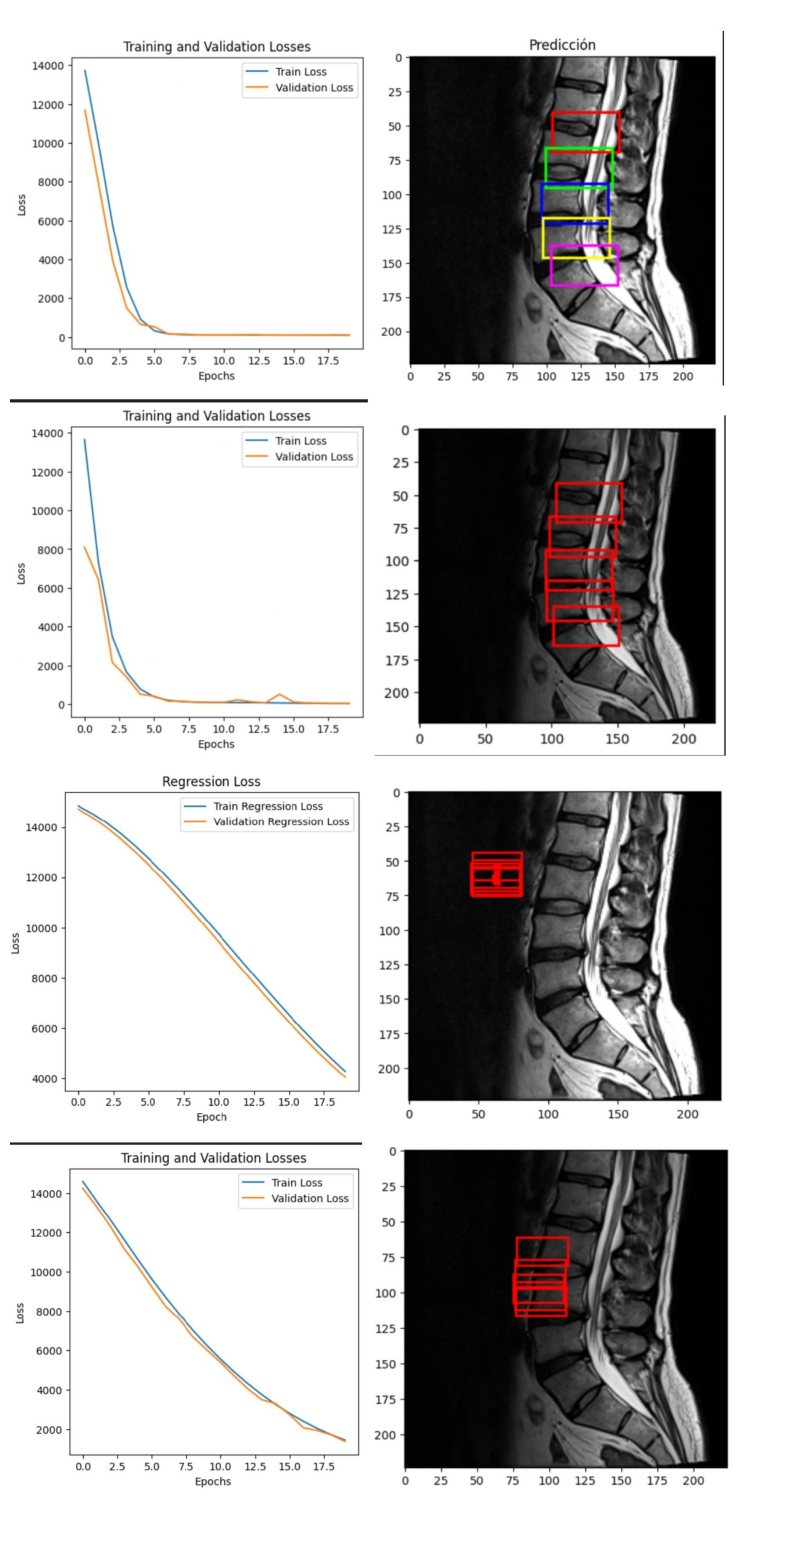

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Carga la imagen
img = mpimg.imread('/kaggle/input/model-scs-test/models_page-0001.jpg')
plt.figure(figsize=(10, 20))
# Muestra la imagen
plt.imshow(img)

plt.axis('off')  # Oculta los ejes
plt.show()

This demostrate **Afirmation 7** 🟨

We train a model using ResNet50 with 100 times

Number of images in training: 1024
Number of images in validation: 219
Number of images under test: 220


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 129MB/s] 


Epoch 1/100 | Train Loss: 13710.9949 | Val Loss: 7944.3476
Epoch 2/100 | Train Loss: 7392.3812 | Val Loss: 7798.0592
Epoch 3/100 | Train Loss: 3592.3953 | Val Loss: 2935.5105
Epoch 4/100 | Train Loss: 1764.4160 | Val Loss: 1620.9188
Epoch 5/100 | Train Loss: 845.4791 | Val Loss: 724.1446
Epoch 6/100 | Train Loss: 412.5813 | Val Loss: 511.2945
Epoch 7/100 | Train Loss: 232.2084 | Val Loss: 142.7218
Epoch 8/100 | Train Loss: 146.4791 | Val Loss: 162.9488
Epoch 9/100 | Train Loss: 107.8019 | Val Loss: 153.9234
Epoch 10/100 | Train Loss: 91.5815 | Val Loss: 164.6525
Epoch 11/100 | Train Loss: 84.8203 | Val Loss: 113.7272
Epoch 12/100 | Train Loss: 81.8490 | Val Loss: 159.4692
Epoch 13/100 | Train Loss: 80.7921 | Val Loss: 87.5786
Epoch 14/100 | Train Loss: 69.7166 | Val Loss: 81.9837
Epoch 15/100 | Train Loss: 64.4855 | Val Loss: 78.8067
Epoch 16/100 | Train Loss: 55.9805 | Val Loss: 131.2552
Epoch 17/100 | Train Loss: 53.1262 | Val Loss: 80.6469
Epoch 18/100 | Train Loss: 47.9079 | Val Lo

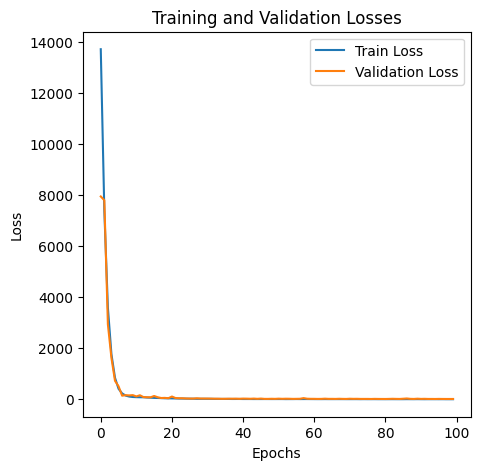

Model saved to /kaggle/working/spinenet_model.pth
Test Loss: 11.8941


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
import matplotlib.pyplot as plt

class SpineNet(nn.Module):
    def __init__(self, pretrained=True):
        super(SpineNet, self).__init__()
        self.backbone = resnet50(weights='DEFAULT' if pretrained else None)  # Use resnet50
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 10)

    def forward(self, x):
        return self.backbone(x)

class SpineDataset(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.data = dataframe
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        study_id = int(row['study_id'])
        series_id = int(row['series_id'])
        instance_number = int(row['instance_number'])
        image_path = os.path.join(self.images_dir, f'{study_id}_{series_id}_{instance_number}.jpg')

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        coords = torch.tensor(
            [row[key] for key in ['L12x', 'L12y', 'L23x', 'L23y', 'L34x', 'L34y', 'L45x', 'L45y', 'L51x', 'L51y']],
            dtype=torch.float32)
        return image, coords

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if not batch:
        return torch.zeros((1, 3, 224, 224)), torch.zeros((1, 10))
    images, coords = zip(*batch)
    images = torch.stack(images)
    coords = torch.stack(coords)
    return images, coords

# Data augmentation transformations for the training images
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),    # Random vertical flip
    transforms.RandomRotation(30),      # Random rotation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Simple transformations for validation and testing
val_transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Update the image path
image_path = '/kaggle/working/train_ima_vert_m1'

# Create dataset
dataset = SpineDataset(m1_pivoted_df, images_dir=image_path, transform=None)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f'Number of images in training: {(train_size)}')
print(f'Number of images in validation: {(val_size)}')
print(f'Number of images under test: {(test_size)}')

# Assign transformations
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

model = SpineNet(pretrained=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device='cuda'):
    model.to(device)
    best_model_wts = model.state_dict()
    best_loss = float('inf')

    # Store losses for plotting
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0

            for inputs, labels in dataloader:
                if inputs is None or labels is None:
                    continue

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            # Print the results in a compact format
            if phase == 'val':
                print(f'Epoch {epoch + 1}/{num_epochs} | '
                      f'Train Loss: {train_losses[-1]:.4f} | '
                      f'Val Loss: {val_losses[-1]:.4f}')

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()

    print(f'Best val loss: {best_loss:4f}')
    model.load_state_dict(best_model_wts)

    # Plot the training and validation losses
    plt.figure(figsize=(5, 5))
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    return model

model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device=device)

# Save the model to a file
model_save_path = '/kaggle/working/spinenet_model.pth'  # Define the save path
torch.save(model.state_dict(), model_save_path)  # Save the model
print(f"Model saved to {model_save_path}")


# Evaluate the model on the test dataset
def evaluate_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    model.to(device)
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

    test_loss = running_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

# Evaluate the trained model
evaluate_model(model, test_loader, criterion, device=device)


## 2.7 Predict the intervertebral level

In the next section we are going to develop a model to predict the coordinates of the intervertebral levels using images from the *Sagittal T2/STIR* series. In this development we begin by imputing the missing data using the *ResNet50* model. First we obtain the image numbers by applying the missForest *spinet20.pth* method to predict the coordinates and expand the number of images to use in the different training.

Con los datos imputados procederemos a segmentar las imágenes que servirán para los entrenamientos de los modelos locales. En este caso tendremos cinco lotes de imágenes por cada nivel. Posteriormente, reuniremos todas las imágenes segmentadas para entrenar un modelo general.   

Let's now label the images without coordinates. However, first we must solve one more problem: To diagnose the condition *Spinal Canal Stenosis* we must choose an image from the directory associated with *Sagittal T2/STIR*. Below we can see that the most used image is $9$.

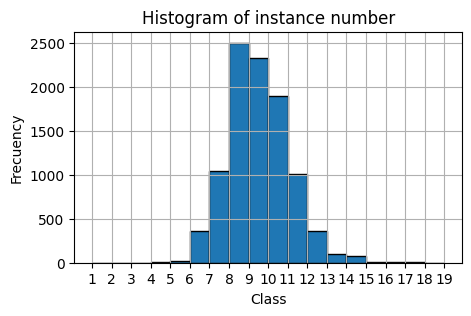

In [ ]:
subdir_df['number_series_id'] = subdir_df['number_series_id'].replace([np.inf, -np.inf], np.nan)
subdir_df = subdir_df.dropna(subset=['number_series_id'])

m = train_merge_T2['instance_number'].min()
M = train_merge_T2['instance_number'].max()

bins = np.arange(m, M, 1)
labels = []
for i in range(m,M):
    labs = i
    labels.append(labs)

plt.figure(figsize=(5, 3))
plt.hist(train_merge_T2['instance_number'], bins=bins, edgecolor='black')

plt.xticks(ticks=np.arange(m, M), labels=labels)

plt.xlabel('Class')
plt.ylabel('Frecuency')
plt.title('Histogram of instance number')
plt.grid(True)
plt.show()

Next we are going to design 5 databases of the condition *Spinal Canal Stenosis* by intervertebral level *L1/L2, L2/L3, L3/L4, L4/L5* and *L5/S1*. These databases will have imputable data.

One way to solve the problem is to apply the *MissForest* method. To do this, let's go by steps. From statements 5 and 6 we know the *level* without labels and also the mislabeled ones for the analysis of the condition *Spinal Canal Stenosis*:

**scs_l1_l2**: {3906279426, 2232794498, 1133158151, 267842058, 3428426893, 1868615696, 344297746, 2256339732, 2548543893, 1292979992, 3151371929, 3637444890, 3515641631, 4072455711, 979209761, 2297295777, 1143209760, 893250212, 1722539301, 2279142182, 434488359, 2336516775, 4127969449, 693432872, 1745732011, 998688940, 3189076268, 267989673, 4137194670, 2839003053, 390498354, 74782131, 4232806580, 1567179188, 934686772, 2615694902, 1047914296, 2239199413, 3221995449, 3084269121, 2966999234, 3284652867, 3537214277, 3973705542, 953218250, 1681401548, 3966998094, 376723024, 1187463765, 4146959702, 1452830936, 3674744025, 1613634521, 296083289, 2213304029, 1395773918, 3850173026, 1557387235, 2566719718, 597329259, 305152236, 293713262, 2907745008, 2040217841, 3167888497, 3936691827, 2397650165, 1431195383, 3711891194, 1400326269, 3824720894}

**scs_l2_l3**: {2232794498, 1133158151, 1868615696, 2256339732, 2548543893, 1292979992, 3637444890, 4072455711, 2297295777, 893250212, 1722539301, 2279142182, 434488359, 2336516775, 390498354, 1567179188, 4232806580, 934686772, 2615694902, 1047914296, 2239199413, 3221995449, 3294654272, 3084269121, 3537214277, 376723024, 1187463765, 3674744025, 1613634521, 2213304029, 3525503074, 1557387235, 3850173026, 2566719718, 293713262, 2907745008, 2040217841, 3167888497, 1431195383, 3711891194, 3824720894})

**scs_l3_l4**: {3294654272, 3637444890}

**scs_l4_l5**: {3294654272, 3637444890, 665627263}

**scs_l5_s1**: {3294654272, 3225351618, 3024532039, 3637444890, 665627263}

Let us note that the two largest bases have differences so it is convenient to take each imputation separately.

In [ ]:

scs_l1_l2 = {3906279426, 2232794498, 1133158151, 267842058, 3428426893, 1868615696, 344297746, 2256339732,
             2548543893, 1292979992, 3151371929, 3637444890, 3515641631, 4072455711, 979209761, 2297295777,
             1143209760, 893250212, 1722539301, 2279142182, 434488359, 2336516775, 4127969449, 693432872,
             1745732011, 998688940, 3189076268, 267989673, 4137194670, 2839003053, 390498354, 74782131,
             4232806580, 1567179188, 934686772, 2615694902, 1047914296, 2239199413, 3221995449, 3084269121,
             2966999234, 3284652867, 3537214277, 3973705542, 953218250, 1681401548, 3966998094, 376723024,
             1187463765, 4146959702, 1452830936, 3674744025, 1613634521, 296083289, 2213304029, 1395773918,
             3850173026, 1557387235, 2566719718, 597329259, 305152236, 293713262, 2907745008, 2040217841,
             3167888497, 3936691827, 2397650165, 1431195383, 3711891194, 1400326269, 3824720894}

scs_l2_l3 = {2232794498, 1133158151, 1868615696, 2256339732, 2548543893, 1292979992, 3637444890, 4072455711,
             2297295777, 893250212, 1722539301, 2279142182, 434488359, 2336516775, 390498354, 1567179188,
             4232806580, 934686772, 2615694902, 1047914296, 2239199413, 3221995449, 3294654272, 3084269121,
             3537214277, 376723024, 1187463765, 3674744025, 1613634521, 2213304029, 3525503074, 1557387235,
             3850173026, 2566719718, 293713262, 2907745008, 2040217841, 3167888497, 1431195383, 3711891194,
             3824720894}

common_elements = scs_l1_l2.intersection(scs_l2_l3)

unique_to_scs_l1_l2 = scs_l1_l2.difference(scs_l2_l3)

unique_to_scs_l2_l3 = scs_l2_l3.difference(scs_l1_l2)

symmetric_difference = scs_l1_l2.symmetric_difference(scs_l2_l3)

print("Common elements:", common_elements)
print("")
print("Common elements in scs_l1_l2:", unique_to_scs_l1_l2)
print("")
print("Common elements in scs_l2_l3:", unique_to_scs_l2_l3)
print("")
print("Common elements:", symmetric_difference)


Common elements: {2232794498, 1133158151, 1868615696, 2256339732, 2548543893, 1292979992, 3637444890, 4072455711, 2297295777, 893250212, 1722539301, 2279142182, 434488359, 2336516775, 390498354, 1567179188, 4232806580, 934686772, 2615694902, 1047914296, 2239199413, 3221995449, 3084269121, 3537214277, 376723024, 1187463765, 3674744025, 1613634521, 2213304029, 3850173026, 1557387235, 2566719718, 293713262, 2907745008, 2040217841, 3167888497, 1431195383, 3711891194, 3824720894}

Common elements in scs_l1_l2: {3906279426, 267842058, 3428426893, 344297746, 3151371929, 3515641631, 1143209760, 979209761, 693432872, 4127969449, 267989673, 1745732011, 3189076268, 998688940, 2839003053, 4137194670, 74782131, 2966999234, 3284652867, 3973705542, 953218250, 1681401548, 3966998094, 4146959702, 1452830936, 296083289, 1395773918, 597329259, 305152236, 3936691827, 2397650165, 1400326269}

Common elements in scs_l2_l3: {3294654272, 3525503074}

Common elements: {3906279426, 267842058, 3428426893, 344297

The process that we will follow in the imputation of the bases *df_scs_l1_l2, df_scs_l2_l3, df_scs_l3_l4, df_scs_l4_l5, df_scs_l5_s1* is the following

🔸 **Step 1**: First, let's build a database with level *L1/L2* from *train_merge_T2* and add to this database in the *study_id* column the values of *scs_l1_l2*.

🔸 **Step 2**: Since the column *spinal_canal_stenosis_l1_l2* of *train* has the diagnostic values of *scs_l1_l2* we can add it to *train_merge_T2*.

🔸 **Step 3**: Since, in the case of the condition *spinal_canal_stenosis*, the *series_description* corresponding to *Sagittal T2/STIR* is used, we can search for the values corresponding to *scs_l1_l2* in the database *train_series_descriptions* and add it to *train_merge_T2*.

🔸 **Step 4**: We apply the *missForest* method to estimate the value of the image used.

🔸 **Step 5**: We apply our model to predict the coordinates of the images we have integrated.

## 2.7.1 spinal_canal_stenosis_l1_l2

In [ ]:
df_scs_l1_l2 = train_merge_T2[train_merge_T2.level == 'L1/L2']
df_scs_l1_l2 = df_scs_l1_l2.reset_index(drop=True)
df_scs_l1_l2

,study_id,series_id,instance_number,condition,level,x,y,series_description
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Sagittal T2/STIR
1,4646740,3666319702,10,Spinal Canal Stenosis,L1/L2,241.700041,156.176471,Sagittal T2/STIR
2,7143189,132939515,9,Spinal Canal Stenosis,L1/L2,177.938468,93.727402,Sagittal T2/STIR
3,8785691,481125819,8,Spinal Canal Stenosis,L1/L2,181.935484,96.487455,Sagittal T2/STIR
4,10728036,3491739931,11,Spinal Canal Stenosis,L1/L2,297.420479,148.915033,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...
1898,4282019580,1547999333,11,Spinal Canal Stenosis,L1/L2,217.588235,104.823529,Sagittal T2/STIR
1899,4283570761,453728183,9,Spinal Canal Stenosis,L1/L2,252.096578,148.066797,Sagittal T2/STIR
1900,4284048608,3767301072,10,Spinal Canal Stenosis,L1/L2,290.154631,203.001570,Sagittal T2/STIR
1901,4287160193,1507070277,8,Spinal Canal Stenosis,L1/L2,391.235190,235.644570,Sagittal T2/STIR


In [ ]:
scs_l1_l2 = [3906279426, 2232794498, 1133158151, 267842058, 3428426893, 1868615696,
             344297746, 2256339732, 2548543893, 1292979992, 3151371929, 3637444890,
             3515641631, 4072455711, 979209761, 2297295777, 1143209760, 893250212,
             1722539301, 2279142182, 434488359, 2336516775, 4127969449, 693432872,
             1745732011, 998688940, 3189076268, 267989673, 4137194670, 2839003053,
             390498354, 74782131, 4232806580, 1567179188, 934686772, 2615694902,
             1047914296, 2239199413, 3221995449, 3084269121, 2966999234, 3284652867,
             3537214277, 3973705542, 953218250, 1681401548, 3966998094, 376723024,
             1187463765, 4146959702, 1452830936, 3674744025, 1613634521, 296083289,
             2213304029, 1395773918, 3850173026, 1557387235, 2566719718, 597329259,
             305152236, 293713262, 2907745008, 2040217841, 3167888497, 3936691827,
             2397650165, 1431195383, 3711891194, 1400326269, 3824720894]
len(scs_l1_l2)

71

In [ ]:
df_scs_l1_l2_sd = train_series_descriptions[train_series_descriptions.series_description == 'Sagittal T2/STIR'].reset_index(drop=True)
scs_l1_l2_sd = []
for i in scs_l1_l2:
    scs_sd = df_scs_l1_l2_sd[df_scs_l1_l2_sd.study_id == i]
    scs_sd = scs_sd.iloc[0,1]
    scs_l1_l2_sd.append(scs_sd)
scs_l1_l2_sd[0:5] # first elements

[3640628768, 2844011887, 992741205, 2575571960, 2836494846]

In [ ]:
# Calculate total number of rows
total_rows = len(df_scs_l1_l2) + len(scs_l1_l2)

# Add missing rows to all columns
df_scs_l1_l2 = df_scs_l1_l2.reindex(range(total_rows))

# Add the values to column 'study_id'
df_scs_l1_l2.iloc[len(df_scs_l1_l2)-len(scs_l1_l2):, 0] = scs_l1_l2
df_scs_l1_l2.iloc[len(df_scs_l1_l2)-len(scs_l1_l2):, 1] = scs_l1_l2_sd
df_scs_l1_l2.iloc[len(df_scs_l1_l2)-len(scs_l1_l2):, 2] = np.nan
df_scs_l1_l2.iloc[len(df_scs_l1_l2)-len(scs_l1_l2):, 3] = 'Spinal Canal Stenosis'
df_scs_l1_l2.iloc[len(df_scs_l1_l2)-len(scs_l1_l2):, 4] = 'L1/L2'
df_scs_l1_l2.iloc[len(df_scs_l1_l2)-len(scs_l1_l2):, 5] = np.nan
df_scs_l1_l2.iloc[len(df_scs_l1_l2)-len(scs_l1_l2):, 6] = np.nan
df_scs_l1_l2.iloc[len(df_scs_l1_l2)-len(scs_l1_l2):, 7] = 'Sagittal T2/STIR'

df_scs_l1_l2['study_id'] = df_scs_l1_l2['study_id'].astype(int)
df_scs_l1_l2['series_id'] = df_scs_l1_l2['series_id'].astype(int)

df_scs_l1_l2

,study_id,series_id,instance_number,condition,level,x,y,series_description
0,4003253,702807833,8.0,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Sagittal T2/STIR
1,4646740,3666319702,10.0,Spinal Canal Stenosis,L1/L2,241.700041,156.176471,Sagittal T2/STIR
2,7143189,132939515,9.0,Spinal Canal Stenosis,L1/L2,177.938468,93.727402,Sagittal T2/STIR
3,8785691,481125819,8.0,Spinal Canal Stenosis,L1/L2,181.935484,96.487455,Sagittal T2/STIR
4,10728036,3491739931,11.0,Spinal Canal Stenosis,L1/L2,297.420479,148.915033,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...
1969,2397650165,605159348,NaN,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR
1970,1431195383,3551899591,NaN,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR
1971,3711891194,521193458,NaN,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR
1972,1400326269,3939069145,NaN,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR


To impute the column *'instance_number'* we extract the following columns

In [ ]:
df_scs_l1_l2_insNum = df_scs_l1_l2.loc[:,['study_id','series_id','instance_number']]
df_scs_l1_l2_insNum

,study_id,series_id,instance_number
0,4003253,702807833,8.0
1,4646740,3666319702,10.0
2,7143189,132939515,9.0
3,8785691,481125819,8.0
4,10728036,3491739931,11.0
...,...,...,...
1969,2397650165,605159348,NaN
1970,1431195383,3551899591,NaN
1971,3711891194,521193458,NaN
1972,1400326269,3939069145,NaN


We apply imputation

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Create an IterativeImputer object
imputer = IterativeImputer()

# Impute missing data
df_scs_l1_l2_insNum_imputed = imputer.fit_transform(df_scs_l1_l2_insNum)

# Show imputed data
df_scs_l1_l2_insNum_imputed = df_scs_l1_l2_insNum_imputed.astype(int)
df_scs_l1_l2_insNum_imputed = pd.DataFrame(df_scs_l1_l2_insNum_imputed)

# we add the imputed data to the database
df_scs_l1_l2.iloc[len(df_scs_l1_l2)-len(scs_l1_l2):, 2] = df_scs_l1_l2_insNum_imputed.iloc[len(df_scs_l1_l2)-len(scs_l1_l2):,2]
df_scs_l1_l2['instance_number'] = df_scs_l1_l2['instance_number'].astype(int)
df_scs_l1_l2

,study_id,series_id,instance_number,condition,level,x,y,series_description
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Sagittal T2/STIR
1,4646740,3666319702,10,Spinal Canal Stenosis,L1/L2,241.700041,156.176471,Sagittal T2/STIR
2,7143189,132939515,9,Spinal Canal Stenosis,L1/L2,177.938468,93.727402,Sagittal T2/STIR
3,8785691,481125819,8,Spinal Canal Stenosis,L1/L2,181.935484,96.487455,Sagittal T2/STIR
4,10728036,3491739931,11,Spinal Canal Stenosis,L1/L2,297.420479,148.915033,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...
1969,2397650165,605159348,9,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR
1970,1431195383,3551899591,9,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR
1971,3711891194,521193458,9,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR
1972,1400326269,3939069145,8,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR


With the proposed model we make the predictions of the last 71 records, extract the coordinates of the intervertebral level 'L1/L2' and add them to the data to impute the missing coordinates.

In [ ]:
df_scs_l1_l2_imp_coordinates = df_scs_l1_l2.iloc[len(df_scs_l1_l2)-len(scs_l1_l2):,]
df_scs_l1_l2_imp_coordinates

,study_id,series_id,instance_number,condition,level,x,y,series_description
1903,3906279426,3640628768,8,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR
1904,2232794498,2844011887,9,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR
1905,1133158151,992741205,9,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR
1906,267842058,2575571960,9,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR
1907,3428426893,2836494846,8,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...
1969,2397650165,605159348,9,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR
1970,1431195383,3551899591,9,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR
1971,3711891194,521193458,9,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR
1972,1400326269,3939069145,8,Spinal Canal Stenosis,L1/L2,NaN,NaN,Sagittal T2/STIR


Let's make the predictions with the ResNet50 model

In [ ]:
# Define the SpineNet class using ResNet50
class SpineNet(nn.Module):
    def __init__(self, pretrained=True):
        super(SpineNet, self).__init__()
        self.backbone = resnet50(weights='DEFAULT' if pretrained else None)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 10)

    def forward(self, x):
        return self.backbone(x)

# Function to load and preprocess DICOM image for prediction
def load_and_preprocess_dicom(image_path):
    try:
        ds = pydicom.dcmread(image_path)
        img = ds.pixel_array
        img = np.stack([img] * 3, axis=-1)  # Convert to RGB

        # Convert to float32 and normalize to [0, 1]
        img = img.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        # Convert to uint8 for compatibility with ToPILImage
        img = (img * 255).astype(np.uint8)

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        return transform(img)
    except pydicom.errors.InvalidDicomError:
        print(f"Invalid DICOM file: {image_path}")
        return None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Function to make a prediction
def predict(image_path, model, device):
    model.eval()
    image = load_and_preprocess_dicom(image_path)
    if image is None:
        print("Failed to load and preprocess the image.")
        return None

    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    try:
        with torch.no_grad():
            output = model(image)
        return output.cpu().numpy().flatten()  # Flatten the output for easier access
    except Exception as e:
        print(f"Error during model prediction: {e}")
        return None

# Function to plot resized image and draw predicted rectangles
def plot_with_predictions(image_path, coordinates):
    # Load the image for display
    ds = pydicom.dcmread(image_path)
    img = ds.pixel_array
    img = np.stack([img] * 3, axis=-1)  # Convert to RGB

    # Convert to float32 and normalize for visualization
    img = img.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    img = img.astype(np.uint8)

    # Convert image to PIL and resize
    img_pil = Image.fromarray(img)
    img_resized = img_pil.resize((224, 224))

    fig, ax = plt.subplots(1, figsize=(4, 4))
    ax.imshow(img_resized)

    # Draw rectangles centered at each predicted coordinate
    for i in range(0, len(coordinates), 2):
        x_center = coordinates[i]
        y_center = coordinates[i + 1]
        rect = patches.Rectangle((x_center - 0, y_center - 0), 5, 5, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('on')
    plt.show()

# Load the trained model
model_path = '/kaggle/working/spinenet_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SpineNet(pretrained=False)
try:
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
except Exception as e:
    print(f"Error loading model: {e}")

# Load the database
df = df_scs_l1_l2_imp_coordinates
image_dir = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'

# Obtain image paths from DataFrame
image_files = df.apply(lambda row: os.path.join(image_dir, f"{row['study_id']}/{row['series_id']}/{row['instance_number']}.dcm"), axis=1).tolist()

def process_and_visualize_image(index):
    try:
        image_path = image_files[index]  # Complete image path
        outputs = predict(image_path, model, device)
        print(f"Predictions for image {image_path}: {outputs}")
        plot_with_predictions(image_path, outputs)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

# Interact for visualization
interact(process_and_visualize_image, index=IntSlider(min=0, max=len(image_files)-1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='index', max=70), Output()), _dom_classes=('widget-intera…

<function __main__.process_and_visualize_image(index)>

Now let's save the coordinates by transforming them to the original size of each image

In [ ]:
# Function to load and preprocess DICOM image for prediction
def load_and_preprocess_dicom(image_path):
    try:
        ds = pydicom.dcmread(image_path)
        img = ds.pixel_array
        img = np.stack([img] * 3, axis=-1)  # Convert to RGB

        # Save original size
        original_size = img.shape[:2]  # (height, width)

        # Convert to float32 and normalize to [0, 1]
        img = img.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        # Convert to uint8 for compatibility with ToPILImage
        img = (img * 255).astype(np.uint8)

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Apply transformation
        resized_image = transform(img)

        # Calculate scale factors
        width_ratio = original_size[1] / 224
        height_ratio = original_size[0] / 224

        return resized_image, original_size, (width_ratio, height_ratio)
    except pydicom.errors.InvalidDicomError:
        print(f"Invalid DICOM file: {image_path}")
        return None, None, None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None, None

# Function to make a prediction and return scaled coordinates
def predict(image_path, model, device):
    model.eval()
    image, original_size, (width_ratio, height_ratio) = load_and_preprocess_dicom(image_path)
    if image is None:
        return None

    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    try:
        with torch.no_grad():
            output = model(image)
        coordinates = output.cpu().numpy().flatten()  # Flatten the output for easier access

        # Scale the coordinates back to original size
        scaled_coordinates = []
        for i in range(0, len(coordinates), 2):
            x = coordinates[i]
            y = coordinates[i + 1]
            x_rescaled = x * width_ratio
            y_rescaled = y * height_ratio
            scaled_coordinates.append((x_rescaled, y_rescaled))

        return scaled_coordinates
    except Exception as e:
        print(f"Error during model prediction: {e}")
        return None

# Load the trained model
model_path = '/kaggle/working/spinenet_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SpineNet(pretrained=False)
try:
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
except Exception as e:
    print(f"Error loading model: {e}")

# Load the database
df = df_scs_l1_l2_imp_coordinates
image_dir = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'

# Obtain image paths from DataFrame
image_files = df.apply(lambda row: os.path.join(image_dir, f"{row['study_id']}/{row['series_id']}/{row['instance_number']}.dcm"), axis=1).tolist()

# Initialize lists to store results
results = []

for image_path in image_files:
    try:
        scaled_coordinates = predict(image_path, model, device)
        if scaled_coordinates is not None:
            # Assuming `scaled_coordinates` contains the rescaled coordinates for L1-L2 vertebrae
            # Adapt based on the specific structure of the output
            results.append({
                'study_id': image_path.split('/')[-3],
                'series_id': image_path.split('/')[-2],
                'L12x': scaled_coordinates[0][0],  # X coordinate of L1-L2
                'L12y': scaled_coordinates[0][1]   # Y coordinate of L1-L2
            })
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

# Create DataFrame with results
df_results = pd.DataFrame(results)
print(df_results)


      study_id   series_id        L12x        L12y
0   3906279426  3640628768  344.026969  213.650665
1   2232794498  2844011887  278.406128  166.985264
2   1133158151   992741205  280.591849  184.858904
3    267842058  2575571960  366.127755  204.218423
4   3428426893  2836494846  300.756138  169.637765
..         ...         ...         ...         ...
66  2397650165   605159348  265.006539  163.462681
67  1431195383  3551899591  281.410522  174.425031
68  3711891194   521193458  480.284232  246.718885
69  1400326269  3939069145  341.293736  174.143851
70  3824720894   691961783  310.036516  158.960432

[71 rows x 4 columns]


Now add this coordinates to the dataframe *df_scs_l1_l2*

In [ ]:
df_scs_l1_l2.iloc[len(df_scs_l1_l2)-len(scs_l1_l2):, 5] = df_results['L12x']
df_scs_l1_l2.iloc[len(df_scs_l1_l2)-len(scs_l1_l2):, 6] = df_results['L12y']

and the final result is the following database

In [ ]:
df_scs_l1_l2

,study_id,series_id,instance_number,condition,level,x,y,series_description
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Sagittal T2/STIR
1,4646740,3666319702,10,Spinal Canal Stenosis,L1/L2,241.700041,156.176471,Sagittal T2/STIR
2,7143189,132939515,9,Spinal Canal Stenosis,L1/L2,177.938468,93.727402,Sagittal T2/STIR
3,8785691,481125819,8,Spinal Canal Stenosis,L1/L2,181.935484,96.487455,Sagittal T2/STIR
4,10728036,3491739931,11,Spinal Canal Stenosis,L1/L2,297.420479,148.915033,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...
1969,2397650165,605159348,9,Spinal Canal Stenosis,L1/L2,265.006539,163.462681,Sagittal T2/STIR
1970,1431195383,3551899591,9,Spinal Canal Stenosis,L1/L2,281.410522,174.425031,Sagittal T2/STIR
1971,3711891194,521193458,9,Spinal Canal Stenosis,L1/L2,480.284232,246.718885,Sagittal T2/STIR
1972,1400326269,3939069145,8,Spinal Canal Stenosis,L1/L2,341.293736,174.143851,Sagittal T2/STIR


#### 🟡 **Afirmation 8**:

The case study_id = 3637444890 has an incorrect label with respect to series_id = 3892989905.

The case study_id = 2905025904 and series_id = 816381378 is mislabeled with respect to coordinates.

The case study_id = 1438760543 and series_id = 737753815 is mislabeled with respect to coordinates.

In [ ]:
path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'
my_study = 3637444890
get_subdir(path,my_study)

/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3637444890/1590743005
/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3637444890/3951475160
/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3637444890/3892989905
/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3637444890/3671685092


In [ ]:
train_series_descriptions[train_series_descriptions.study_id == 3637444890]

,study_id,series_id,series_description
5330,3637444890,1590743005,Axial T2
5331,3637444890,3671685092,Axial T2
5332,3637444890,3892989905,Sagittal T2/STIR
5333,3637444890,3951475160,Sagittal T1


In [ ]:
df_scs_l1_l2[df_scs_l1_l2.study_id == 3637444890]

,study_id,series_id,instance_number,condition,level,x,y,series_description
1914,3637444890,3892989905,8,Spinal Canal Stenosis,L1/L2,144.378259,107.991104,Sagittal T2/STIR


In this case we can use *series_id = 3951475160*

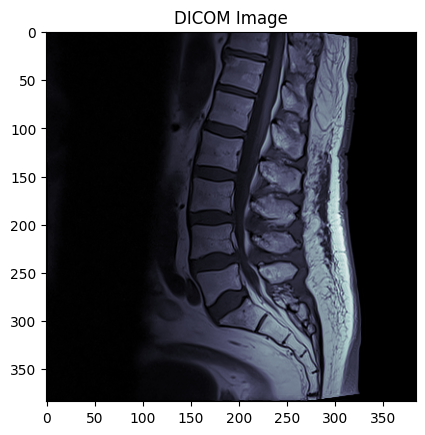

In [ ]:
dicom_file_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3637444890/3951475160/8.dcm'
visualize_dicom_image(dicom_file_path)

and now add the correct labels in the next cases.

This implies that we must review each database to avoid cases similar to those we have reviewed in the case of database *df_scs_l1_l2*

This demostrate **Afirmation 8** 🟨

#### 🟡 **Afirmation 9**:

The databases *df_scs_l1_l2, df_scs_l2_l3,df_scs_l3_l4,df_scs_l4_l5,df_scs_l5_s1 * that combine the referring data by intervertebral level are imputed.

In [ ]:
for i in {737753815, 816381378}:
    print(df_scs_l1_l2[df_scs_l1_l2.series_id == i])

        study_id  series_id  instance_number              condition  level  \
1286  2905025904  816381378               11  Spinal Canal Stenosis  L1/L2   

             x         y series_description  
1286  4.999978  4.999999   Sagittal T2/STIR  
       study_id  series_id  instance_number              condition  level  \
626  1438760543  737753815                9  Spinal Canal Stenosis  L1/L2   

            x         y series_description  
626  5.000042  4.999993   Sagittal T2/STIR  


In [ ]:
image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2905025904/816381378/11.dcm'
#model_path = '/kaggle/working/spinenet50_model.pth'

# Get the predicted coordinates
predicted_coordinates = predict(image_path, model, device)
print(f'Predicted coordinates: {predicted_coordinates}')

Predicted coordinates: [(200.3492954799107, 125.70315946851457), (198.16310773577007, 174.87342044285364), (199.04402814592632, 223.75441932678223), (205.04385811941964, 268.60069002423967), (215.35133579799106, 306.75899505615234)]


In [ ]:
image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1438760543/737753815/9.dcm'
#model_path = '/kaggle/working/spinenet50_model.pth'

# Get the predicted coordinates
predicted_coordinates = predict(image_path, model, device)
print(f'Predicted coordinates: {predicted_coordinates}')


Predicted coordinates: [(238.03236389160156, 140.7323455810547), (225.97256469726562, 194.7596893310547), (223.39427185058594, 248.12081909179688), (236.52972412109375, 296.9696350097656), (261.8086853027344, 335.41552734375)]


In [ ]:
image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3637444890/3951475160/8.dcm'

# Get the predicted coordinates
predicted_coordinates = predict(image_path, model, device)
print(f'Predicted coordinates: {predicted_coordinates}')

Predicted coordinates: [(214.76347569056918, 114.48563494001115), (205.3731733049665, 154.18809291294642), (200.77496337890625, 193.88072858537944), (205.4838605608259, 230.91943359375), (219.5336478097098, 260.081045968192)]


We update the database *df_scs_l1_l2*

In [ ]:
T = df_scs_l1_l2
def update_entry(df_scs_l1_l2, study_id, new_series_id, new_instance_number, new_x, new_y):

    mask = (df_scs_l1_l2['study_id'] == study_id)
    index = df_scs_l1_l2.index[mask].tolist()  #

    if len(index) != 1:
        raise ValueError(f"No single entry was found for study_id {study_id}")

    # Update the values of 'instance_number', 'x' and 'y'
    df_scs_l1_l2.loc[index[0], 'series_id'] = new_series_id
    df_scs_l1_l2.loc[index[0], 'instance_number'] = new_instance_number
    df_scs_l1_l2.loc[index[0], 'x'] = new_x
    df_scs_l1_l2.loc[index[0], 'y'] = new_y
if __name__ == '__main__':
    update_entry(df_scs_l1_l2, T.iloc[1286].iloc[0], 816381378, 11, 214.2267412458147, 109.61395454406738)
    update_entry(df_scs_l1_l2, T.iloc[626].iloc[0], 737753815, 9, 246.69515991210938, 126.09215545654297)
    update_entry(df_scs_l1_l2, T.iloc[1914].iloc[0], 3951475160, 8, 124.27112, 61.668064 )

In [ ]:
#T = df_scs_l1_l2
#def update_entry(df_scs_l1_l2, study_id, series_id, new_instance_number, new_x, new_y):

#    mask = (df_scs_l1_l2['study_id'] == study_id) & (df_scs_l1_l2['series_id'] == series_id)
#    index = df_scs_l1_l2.index[mask].tolist()  #

#    if len(index) != 1:
#        raise ValueError(f"No single entry was found for study_id {study_id} ans series_id {series_id}")

    # Update the values of 'instance_number', 'x' and 'y'
#    df_scs_l1_l2.loc[index[0], 'instance_number'] = new_instance_number
#    df_scs_l1_l2.loc[index[0], 'x'] = new_x
#    df_scs_l1_l2.loc[index[0], 'y'] = new_y
#if __name__ == '__main__':
#    update_entry(df_scs_l1_l2, T.iloc[1286].iloc[0], T.iloc[1286].iloc[1], 11, 214.2267412458147, 109.61395454406738)
#    update_entry(df_scs_l1_l2, T.iloc[626].iloc[0], T.iloc[626].iloc[1], 9, 246.69515991210938, 126.09215545654297)


In [ ]:
train_scs_l1_l2 = train.loc[:,['study_id','spinal_canal_stenosis_l1_l2']]
df_scs_l1_l2 = pd.merge( df_scs_l1_l2,train_scs_l1_l2, on='study_id', how='inner')
df_scs_l1_l2

,study_id,series_id,instance_number,condition,level,x,y,series_description,spinal_canal_stenosis_l1_l2
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Sagittal T2/STIR,Normal/Mild
1,4646740,3666319702,10,Spinal Canal Stenosis,L1/L2,241.700041,156.176471,Sagittal T2/STIR,Normal/Mild
2,7143189,132939515,9,Spinal Canal Stenosis,L1/L2,177.938468,93.727402,Sagittal T2/STIR,Normal/Mild
3,8785691,481125819,8,Spinal Canal Stenosis,L1/L2,181.935484,96.487455,Sagittal T2/STIR,Normal/Mild
4,10728036,3491739931,11,Spinal Canal Stenosis,L1/L2,297.420479,148.915033,Sagittal T2/STIR,Normal/Mild
...,...,...,...,...,...,...,...,...,...
1969,2397650165,605159348,9,Spinal Canal Stenosis,L1/L2,265.006539,163.462681,Sagittal T2/STIR,Normal/Mild
1970,1431195383,3551899591,9,Spinal Canal Stenosis,L1/L2,281.410522,174.425031,Sagittal T2/STIR,Normal/Mild
1971,3711891194,521193458,9,Spinal Canal Stenosis,L1/L2,480.284232,246.718885,Sagittal T2/STIR,Normal/Mild
1972,1400326269,3939069145,8,Spinal Canal Stenosis,L1/L2,341.293736,174.143851,Sagittal T2/STIR,Normal/Mild


## 2.7.2 spinal_canal_stenosis_l2_l3

Based on the above, let's now do the corresponding thing for the 'L2/L3' level

In [ ]:
df_scs_l2_l3 = train_merge_T2[train_merge_T2.level == 'L2/L3']
df_scs_l2_l3 = df_scs_l2_l3.reset_index(drop=True)

scs_l2_l3 = [2232794498, 1133158151, 1868615696, 2256339732, 2548543893, 1292979992, 3637444890, 4072455711, 2297295777,
             893250212, 1722539301, 2279142182, 434488359, 2336516775, 390498354, 1567179188, 4232806580, 934686772,
             2615694902, 1047914296, 2239199413, 3221995449, 3294654272, 3084269121, 3537214277, 376723024, 1187463765,
             3674744025, 1613634521, 2213304029, 3525503074, 1557387235, 3850173026, 2566719718, 293713262, 2907745008,
             2040217841, 3167888497, 1431195383, 3711891194, 3824720894]

df_scs_l2_l3_sd = train_series_descriptions[train_series_descriptions.series_description == 'Sagittal T2/STIR'].reset_index(drop=True)
scs_l2_l3_sd = []
for i in scs_l2_l3:
    scs_sd = df_scs_l2_l3_sd[df_scs_l2_l3_sd.study_id == i]
    scs_sd = scs_sd.iloc[0,1]
    scs_l2_l3_sd.append(scs_sd)

# Calculate total number of rows
total_rows = len(df_scs_l2_l3) + len(scs_l2_l3)

# Add missing rows to all columns
df_scs_l2_l3 = df_scs_l2_l3.reindex(range(total_rows))

# Add the values to column 'study_id'
df_scs_l2_l3.iloc[len(df_scs_l2_l3)-len(scs_l2_l3):, 0] = scs_l2_l3
df_scs_l2_l3.iloc[len(df_scs_l2_l3)-len(scs_l2_l3):, 1] = scs_l2_l3_sd
df_scs_l2_l3.iloc[len(df_scs_l2_l3)-len(scs_l2_l3):, 2] = np.nan
df_scs_l2_l3.iloc[len(df_scs_l2_l3)-len(scs_l2_l3):, 3] = 'Spinal Canal Stenosis'
df_scs_l2_l3.iloc[len(df_scs_l2_l3)-len(scs_l2_l3):, 4] = 'L2/L3'
df_scs_l2_l3.iloc[len(df_scs_l2_l3)-len(scs_l2_l3):, 5] = np.nan
df_scs_l2_l3.iloc[len(df_scs_l2_l3)-len(scs_l2_l3):, 6] = np.nan
df_scs_l2_l3.iloc[len(df_scs_l2_l3)-len(scs_l2_l3):, 7] = 'Sagittal T2/STIR'

df_scs_l2_l3['study_id'] = df_scs_l2_l3['study_id'].astype(int)
df_scs_l2_l3['series_id'] = df_scs_l2_l3['series_id'].astype(int)

df_scs_l2_l3_insNum = df_scs_l2_l3.loc[:,['study_id','series_id','instance_number']]

# Impute missing data
df_scs_l2_l3_insNum_imputed = imputer.fit_transform(df_scs_l2_l3_insNum)

# Show imputed data
df_scs_l2_l3_insNum_imputed = df_scs_l2_l3_insNum_imputed.astype(int)
df_scs_l2_l3_insNum_imputed = pd.DataFrame(df_scs_l2_l3_insNum_imputed)

# we add the imputed data to the database
df_scs_l2_l3.iloc[len(df_scs_l2_l3)-len(scs_l2_l3):, 2] = df_scs_l2_l3_insNum_imputed.iloc[len(df_scs_l2_l3)-len(scs_l2_l3):,2]
df_scs_l2_l3['instance_number'] = df_scs_l2_l3['instance_number'].astype(int)

df_scs_l2_l3_imp_coordinates = df_scs_l2_l3.iloc[len(df_scs_l2_l3)-len(scs_l2_l3):,]

# Function to load and preprocess DICOM image for prediction
def load_and_preprocess_dicom(image_path):
    try:
        ds = pydicom.dcmread(image_path)
        img = ds.pixel_array
        img = np.stack([img] * 3, axis=-1)  # Convert to RGB

        # Save original size
        original_size = img.shape[:2]  # (height, width)

        # Convert to float32 and normalize to [0, 1]
        img = img.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        # Convert to uint8 for compatibility with ToPILImage
        img = (img * 255).astype(np.uint8)

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Apply transformation
        resized_image = transform(img)

        # Calculate scale factors
        width_ratio = original_size[1] / 224
        height_ratio = original_size[0] / 224

        return resized_image, original_size, (width_ratio, height_ratio)
    except pydicom.errors.InvalidDicomError:
        print(f"Invalid DICOM file: {image_path}")
        return None, None, None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None, None

# Function to make a prediction and return scaled coordinates
def predict(image_path, model, device):
    model.eval()
    image, original_size, (width_ratio, height_ratio) = load_and_preprocess_dicom(image_path)
    if image is None:
        return None

    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    try:
        with torch.no_grad():
            output = model(image)
        coordinates = output.cpu().numpy().flatten()  # Flatten the output for easier access

        # Scale the coordinates back to original size
        scaled_coordinates = []
        for i in range(0, len(coordinates), 2):
            x = coordinates[i]
            y = coordinates[i + 1]
            x_rescaled = x * width_ratio
            y_rescaled = y * height_ratio
            scaled_coordinates.append((x_rescaled, y_rescaled))

        return scaled_coordinates
    except Exception as e:
        print(f"Error during model prediction: {e}")
        return None

# Load the trained model
model_path = '/kaggle/working/spinenet_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SpineNet(pretrained=False)
try:
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
except Exception as e:
    print(f"Error loading model: {e}")

# Load the database
df = df_scs_l2_l3_imp_coordinates
image_dir = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'

# Obtain image paths from DataFrame
image_files = df.apply(lambda row: os.path.join(image_dir, f"{row['study_id']}/{row['series_id']}/{row['instance_number']}.dcm"), axis=1).tolist()

# Initialize lists to store results
results = []

for image_path in image_files:
    try:
        scaled_coordinates = predict(image_path, model, device)
        if scaled_coordinates is not None and len(scaled_coordinates) > 1:
            results.append({
                'study_id': image_path.split('/')[-3],
                'series_id': image_path.split('/')[-2],
                'L23x': scaled_coordinates[1][0],
                'L23y': scaled_coordinates[1][1]
            })
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

df_results = pd.DataFrame(results)
#print(df_results)

# Now add this coordinates to the dataframe df_scs_l1_l2
df_scs_l2_l3.iloc[len(df_scs_l2_l3)-len(scs_l2_l3):, 5] = df_results['L23x']
df_scs_l2_l3.iloc[len(df_scs_l2_l3)-len(scs_l2_l3):, 6] = df_results['L23y']

df_scs_l2_l3

,study_id,series_id,instance_number,condition,level,x,y,series_description
0,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Sagittal T2/STIR
1,4646740,3666319702,10,Spinal Canal Stenosis,L2/L3,236.887207,222.593583,Sagittal T2/STIR
2,7143189,132939515,9,Spinal Canal Stenosis,L2/L3,172.153502,130.264034,Sagittal T2/STIR
3,8785691,481125819,8,Spinal Canal Stenosis,L2/L3,172.186380,128.602151,Sagittal T2/STIR
4,10728036,3491739931,11,Spinal Canal Stenosis,L2/L3,296.305011,213.612200,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...
1969,2040217841,3913032764,8,Spinal Canal Stenosis,L2/L3,193.242514,141.747881,Sagittal T2/STIR
1970,3167888497,1992065903,8,Spinal Canal Stenosis,L2/L3,379.786246,347.467329,Sagittal T2/STIR
1971,1431195383,3551899591,8,Spinal Canal Stenosis,L2/L3,271.054565,224.787859,Sagittal T2/STIR
1972,3711891194,521193458,9,Spinal Canal Stenosis,L2/L3,462.966692,350.829058,Sagittal T2/STIR


Let's view the results and notice that the image /3637444890/3892989905/8.dcm is incorrect and as in the previous case, apply a correction

In [ ]:
# Define the SpineNet class using ResNet50
class SpineNet(nn.Module):
    def __init__(self, pretrained=True):
        super(SpineNet, self).__init__()
        self.backbone = resnet50(weights='DEFAULT' if pretrained else None)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 10)

    def forward(self, x):
        return self.backbone(x)
# Function to load and preprocess DICOM image for prediction
def load_and_preprocess_dicom(image_path):
    try:
        ds = pydicom.dcmread(image_path)
        img = ds.pixel_array
        img = np.stack([img] * 3, axis=-1)  # Convert to RGB

        # Convert to float32 and normalize to [0, 1]
        img = img.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        # Convert to uint8 for compatibility with ToPILImage
        img = (img * 255).astype(np.uint8)

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        return transform(img)
    except pydicom.errors.InvalidDicomError:
        print(f"Invalid DICOM file: {image_path}")
        return None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Function to make a prediction
def predict(image_path, model, device):
    model.eval()
    image = load_and_preprocess_dicom(image_path)
    if image is None:
        print("Failed to load and preprocess the image.")
        return None

    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    try:
        with torch.no_grad():
            output = model(image)
        return output.cpu().numpy().flatten()  # Flatten the output for easier access
    except Exception as e:
        print(f"Error during model prediction: {e}")
        return None

# Function to plot resized image and draw predicted rectangles
def plot_with_predictions(image_path, coordinates):
    # Load the image for display
    ds = pydicom.dcmread(image_path)
    img = ds.pixel_array
    img = np.stack([img] * 3, axis=-1)  # Convert to RGB

    # Convert to float32 and normalize for visualization
    img = img.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    img = img.astype(np.uint8)

    # Convert image to PIL and resize
    img_pil = Image.fromarray(img)
    img_resized = img_pil.resize((224, 224))

    fig, ax = plt.subplots(1, figsize=(4, 4))
    ax.imshow(img_resized)

    # Draw rectangles centered at each predicted coordinate
    for i in range(0, len(coordinates), 2):
        x_center = coordinates[i]
        y_center = coordinates[i + 1]
        rect = patches.Rectangle((x_center - 0, y_center - 0), 5, 5, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('on')
    plt.show()

# Load the trained model
model_path = '/kaggle/working/spinenet_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SpineNet(pretrained=False)
try:
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
except Exception as e:
    print(f"Error loading model: {e}")

# Load the database
df = df_scs_l2_l3_imp_coordinates
image_dir = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'

# Obtain image paths from DataFrame
image_files = df.apply(lambda row: os.path.join(image_dir, f"{row['study_id']}/{row['series_id']}/{row['instance_number']}.dcm"), axis=1).tolist()

def process_and_visualize_image(index):
    try:
        image_path = image_files[index]  # Complete image path
        outputs = predict(image_path, model, device)
        print(f"Predictions for image {image_path}: {outputs}")
        plot_with_predictions(image_path, outputs)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

# Interact for visualization
interact(process_and_visualize_image, index=IntSlider(min=0, max=len(image_files)-1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='index', max=40), Output()), _dom_classes=('widget-intera…

<function __main__.process_and_visualize_image(index)>

In [ ]:
 image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1820866003/131094096/7.dcm'
#model_path = '/kaggle/working/spinenet50_model.pth'

# Get the predicted coordinates
predicted_coordinates = predict(image_path, model, device)
print(f'Predicted coordinates: {predicted_coordinates}')

Predicted coordinates: [125.52799   46.773983 120.522026  73.456276 117.07095  100.14112
 118.14251  126.16136  123.67047  147.73863 ]


In [ ]:
 print(df_scs_l2_l3[df_scs_l2_l3.series_id == 131094096])

       study_id  series_id  instance_number              condition  level  \
808  1820866003  131094096                7  Spinal Canal Stenosis  L2/L3   

       x         y series_description  
808  5.0  2.063098   Sagittal T2/STIR  


In [ ]:
image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3637444890/3892989905/8.dcm'

# Get the predicted coordinates
predicted_coordinates = predict(image_path, model, device)
print(f'Predicted coordinates: {predicted_coordinates}')

df_scs_l2_l3[df_scs_l2_l3.study_id == 3637444890]


Predicted coordinates: [101.06478   75.59377   97.058205  99.84535   99.168205 124.2143
 110.28368  145.13994  123.18309  162.4797  ]


,study_id,series_id,instance_number,condition,level,x,y,series_description
1939,3637444890,3892989905,8,Spinal Canal Stenosis,L2/L3,138.654578,142.636217,Sagittal T2/STIR


In [ ]:
T2 = df_scs_l2_l3

if __name__ == '__main__':
    update_entry(df_scs_l2_l3, T2.iloc[808].iloc[0], 131094096, 7, 273.9358956473214, 173.546142578125)
    update_entry(df_scs_l2_l3, T2.iloc[1939].iloc[0], 3892989905, 8, 110.16017, 106.5738)

In [ ]:
train_scs_l2_l3 = train.loc[:,['study_id','spinal_canal_stenosis_l2_l3']]
df_scs_l2_l3 = pd.merge( df_scs_l2_l3,train_scs_l2_l3, on='study_id', how='inner')
df_scs_l2_l3

,study_id,series_id,instance_number,condition,level,x,y,series_description,spinal_canal_stenosis_l2_l3
0,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Sagittal T2/STIR,Normal/Mild
1,4646740,3666319702,10,Spinal Canal Stenosis,L2/L3,236.887207,222.593583,Sagittal T2/STIR,Normal/Mild
2,7143189,132939515,9,Spinal Canal Stenosis,L2/L3,172.153502,130.264034,Sagittal T2/STIR,Normal/Mild
3,8785691,481125819,8,Spinal Canal Stenosis,L2/L3,172.186380,128.602151,Sagittal T2/STIR,Normal/Mild
4,10728036,3491739931,11,Spinal Canal Stenosis,L2/L3,296.305011,213.612200,Sagittal T2/STIR,Normal/Mild
...,...,...,...,...,...,...,...,...,...
1969,2040217841,3913032764,8,Spinal Canal Stenosis,L2/L3,193.242514,141.747881,Sagittal T2/STIR,Normal/Mild
1970,3167888497,1992065903,8,Spinal Canal Stenosis,L2/L3,379.786246,347.467329,Sagittal T2/STIR,Normal/Mild
1971,1431195383,3551899591,8,Spinal Canal Stenosis,L2/L3,271.054565,224.787859,Sagittal T2/STIR,Normal/Mild
1972,3711891194,521193458,9,Spinal Canal Stenosis,L2/L3,462.966692,350.829058,Sagittal T2/STIR,Normal/Mild


## 2.7.3 spinal_canal_stenosis_l3_l4

We follow the same process outlined in the previous cases for the 'L3/L4' level.

In [ ]:
df_scs_l3_l4 = train_merge_T2[train_merge_T2.level == 'L3/L4']
df_scs_l3_l4 = df_scs_l3_l4.reset_index(drop=True)

scs_l3_l4 = [3294654272, 3637444890]

df_scs_l3_l4_sd = train_series_descriptions[train_series_descriptions.series_description == 'Sagittal T2/STIR'].reset_index(drop=True)
scs_l3_l4_sd = []
for i in scs_l3_l4:
    scs_sd = df_scs_l3_l4_sd[df_scs_l3_l4_sd.study_id == i]
    scs_sd = scs_sd.iloc[0,1]
    scs_l3_l4_sd.append(scs_sd)

# Calculate total number of rows
total_rows = len(df_scs_l3_l4) + len(scs_l3_l4)

# Add missing rows to all columns
df_scs_l3_l4 = df_scs_l3_l4.reindex(range(total_rows))

# Add the values to column 'study_id'
df_scs_l3_l4.iloc[len(df_scs_l3_l4)-len(scs_l3_l4):, 0] = scs_l3_l4
df_scs_l3_l4.iloc[len(df_scs_l3_l4)-len(scs_l3_l4):, 1] = scs_l3_l4_sd
df_scs_l3_l4.iloc[len(df_scs_l3_l4)-len(scs_l3_l4):, 2] = np.nan
df_scs_l3_l4.iloc[len(df_scs_l3_l4)-len(scs_l3_l4):, 3] = 'Spinal Canal Stenosis'
df_scs_l3_l4.iloc[len(df_scs_l3_l4)-len(scs_l3_l4):, 4] = 'L3/L4'
df_scs_l3_l4.iloc[len(df_scs_l3_l4)-len(scs_l3_l4):, 5] = np.nan
df_scs_l3_l4.iloc[len(df_scs_l3_l4)-len(scs_l3_l4):, 6] = np.nan
df_scs_l3_l4.iloc[len(df_scs_l3_l4)-len(scs_l3_l4):, 7] = 'Sagittal T2/STIR'

df_scs_l3_l4['study_id'] = df_scs_l3_l4['study_id'].astype(int)
df_scs_l3_l4['series_id'] = df_scs_l3_l4['series_id'].astype(int)

df_scs_l3_l4_insNum = df_scs_l3_l4.loc[:,['study_id','series_id','instance_number']]

# Impute missing data
df_scs_l3_l4_insNum_imputed = imputer.fit_transform(df_scs_l3_l4_insNum)

# Show imputed data
df_scs_l3_l4_insNum_imputed = df_scs_l3_l4_insNum_imputed.astype(int)
df_scs_l3_l4_insNum_imputed = pd.DataFrame(df_scs_l3_l4_insNum_imputed)

# we add the imputed data to the database
df_scs_l3_l4.iloc[len(df_scs_l3_l4)-len(scs_l3_l4):, 2] = df_scs_l3_l4_insNum_imputed.iloc[len(df_scs_l3_l4)-len(scs_l3_l4):,2]
df_scs_l3_l4['instance_number'] = df_scs_l3_l4['instance_number'].astype(int)

df_scs_l3_l4_imp_coordinates = df_scs_l3_l4.iloc[len(df_scs_l3_l4)-len(scs_l3_l4):,]

# Function to load and preprocess DICOM image for prediction
def load_and_preprocess_dicom(image_path):
    try:
        ds = pydicom.dcmread(image_path)
        img = ds.pixel_array
        img = np.stack([img] * 3, axis=-1)  # Convert to RGB

        # Save original size
        original_size = img.shape[:2]  # (height, width)

        # Convert to float32 and normalize to [0, 1]
        img = img.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        # Convert to uint8 for compatibility with ToPILImage
        img = (img * 255).astype(np.uint8)

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Apply transformation
        resized_image = transform(img)

        # Calculate scale factors
        width_ratio = original_size[1] / 224
        height_ratio = original_size[0] / 224

        return resized_image, original_size, (width_ratio, height_ratio)
    except pydicom.errors.InvalidDicomError:
        print(f"Invalid DICOM file: {image_path}")
        return None, None, None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None, None

# Function to make a prediction and return scaled coordinates
def predict(image_path, model, device):
    model.eval()
    image, original_size, (width_ratio, height_ratio) = load_and_preprocess_dicom(image_path)
    if image is None:
        return None

    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    try:
        with torch.no_grad():
            output = model(image)
        coordinates = output.cpu().numpy().flatten()  # Flatten the output for easier access

        # Scale the coordinates back to original size
        scaled_coordinates = []
        for i in range(0, len(coordinates), 2):
            x = coordinates[i]
            y = coordinates[i + 1]
            x_rescaled = x * width_ratio
            y_rescaled = y * height_ratio
            scaled_coordinates.append((x_rescaled, y_rescaled))

        return scaled_coordinates
    except Exception as e:
        print(f"Error during model prediction: {e}")
        return None

# Load the trained model
model_path = '/kaggle/working/spinenet_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SpineNet(pretrained=False)
try:
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
except Exception as e:
    print(f"Error loading model: {e}")

# Load the database
df = df_scs_l3_l4_imp_coordinates
image_dir = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'

# Obtain image paths from DataFrame
image_files = df.apply(lambda row: os.path.join(image_dir, f"{row['study_id']}/{row['series_id']}/{row['instance_number']}.dcm"), axis=1).tolist()

# Initialize lists to store results
results = []


for image_path in image_files:
    try:
        scaled_coordinates = predict(image_path, model, device)
        if scaled_coordinates is not None and len(scaled_coordinates) > 1:
            results.append({
                'study_id': image_path.split('/')[-3],
                'series_id': image_path.split('/')[-2],
                'L34x': scaled_coordinates[2][0],
                'L34y': scaled_coordinates[2][1]
            })
    except Exception as e:
        print(f"Error procesando la imagen {image_path}: {e}")

df_results = pd.DataFrame(results)
#print(df_results)

# Now add this coordinates to the dataframe
df_scs_l3_l4.iloc[len(df_scs_l3_l4)-len(scs_l3_l4):, 5] = df_results['L34x']
df_scs_l3_l4.iloc[len(df_scs_l3_l4)-len(scs_l3_l4):, 6] = df_results['L34y']

df_scs_l3_l4

,study_id,series_id,instance_number,condition,level,x,y,series_description
0,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Sagittal T2/STIR
1,4646740,3666319702,9,Spinal Canal Stenosis,L3/L4,233.036940,271.684492,Sagittal T2/STIR
2,7143189,132939515,9,Spinal Canal Stenosis,L3/L4,166.763096,165.349566,Sagittal T2/STIR
3,8785691,481125819,8,Spinal Canal Stenosis,L3/L4,165.878136,158.996416,Sagittal T2/STIR
4,10728036,3491739931,11,Spinal Canal Stenosis,L3/L4,278.457516,277.193900,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...
1969,4284048608,3767301072,10,Spinal Canal Stenosis,L3/L4,272.974097,335.020408,Sagittal T2/STIR
1970,4287160193,1507070277,8,Spinal Canal Stenosis,L3/L4,373.587800,391.356841,Sagittal T2/STIR
1971,4290709089,3274612423,9,Spinal Canal Stenosis,L3/L4,174.227086,160.656635,Sagittal T2/STIR
1972,3294654272,4147986695,8,Spinal Canal Stenosis,L3/L4,253.531710,334.014509,Sagittal T2/STIR


In [ ]:
image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3637444890/3892989905/8.dcm'

# Get the predicted coordinates
predicted_coordinates = predict(image_path, model, device)
print(f'Predicted coordinates: {predicted_coordinates}')

df_scs_l3_l4[df_scs_l3_l4.study_id == 3637444890]

Predicted coordinates: [(144.37825884137834, 107.99110412597656), (138.65457807268416, 142.63621738978796), (141.66886465890067, 177.44900294712613), (157.5481196812221, 207.342769077846), (175.97584315708707, 232.1138654436384)]


,study_id,series_id,instance_number,condition,level,x,y,series_description
1973,3637444890,3892989905,8,Spinal Canal Stenosis,L3/L4,141.668865,177.449003,Sagittal T2/STIR


In [ ]:
T2 = df_scs_l3_l4

if __name__ == '__main__':
    update_entry(df_scs_l3_l4, T2.iloc[1973].iloc[0], 3892989905, 8, 153.2284872872489, 168.61812046595983)

In [ ]:
train_scs_l3_l4 = train.loc[:,['study_id','spinal_canal_stenosis_l3_l4']]
df_scs_l3_l4 = pd.merge( df_scs_l3_l4,train_scs_l3_l4, on='study_id', how='inner')
df_scs_l3_l4

,study_id,series_id,instance_number,condition,level,x,y,series_description,spinal_canal_stenosis_l3_l4
0,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Sagittal T2/STIR,Normal/Mild
1,4646740,3666319702,9,Spinal Canal Stenosis,L3/L4,233.036940,271.684492,Sagittal T2/STIR,Moderate
2,7143189,132939515,9,Spinal Canal Stenosis,L3/L4,166.763096,165.349566,Sagittal T2/STIR,Normal/Mild
3,8785691,481125819,8,Spinal Canal Stenosis,L3/L4,165.878136,158.996416,Sagittal T2/STIR,Normal/Mild
4,10728036,3491739931,11,Spinal Canal Stenosis,L3/L4,278.457516,277.193900,Sagittal T2/STIR,Normal/Mild
...,...,...,...,...,...,...,...,...,...
1969,4284048608,3767301072,10,Spinal Canal Stenosis,L3/L4,272.974097,335.020408,Sagittal T2/STIR,Normal/Mild
1970,4287160193,1507070277,8,Spinal Canal Stenosis,L3/L4,373.587800,391.356841,Sagittal T2/STIR,Normal/Mild
1971,4290709089,3274612423,9,Spinal Canal Stenosis,L3/L4,174.227086,160.656635,Sagittal T2/STIR,Normal/Mild
1972,3294654272,4147986695,8,Spinal Canal Stenosis,L3/L4,253.531710,334.014509,Sagittal T2/STIR,Normal/Mild


## 2.7.4 spinal_canal_stenosis_l4_l5

We follow the development of previous cases

In [ ]:
df_scs_l4_l5 = train_merge_T2[train_merge_T2.level == 'L4/L5']
df_scs_l4_l5 = df_scs_l4_l5.reset_index(drop=True)

scs_l4_l5 = [3294654272, 3637444890, 665627263]

df_scs_l4_l5_sd = train_series_descriptions[train_series_descriptions.series_description == 'Sagittal T2/STIR'].reset_index(drop=True)
scs_l4_l5_sd = []
for i in scs_l4_l5:
    scs_sd = df_scs_l4_l5_sd[df_scs_l4_l5_sd.study_id == i]
    scs_sd = scs_sd.iloc[0,1]
    scs_l4_l5_sd.append(scs_sd)

# Calculate total number of rows
total_rows = len(df_scs_l4_l5) + len(scs_l4_l5)

# Add missing rows to all columns
df_scs_l4_l5 = df_scs_l4_l5.reindex(range(total_rows))

# Add the values to column 'study_id'
df_scs_l4_l5.iloc[len(df_scs_l4_l5)-len(scs_l4_l5):, 0] = scs_l4_l5
df_scs_l4_l5.iloc[len(df_scs_l4_l5)-len(scs_l4_l5):, 1] = scs_l4_l5_sd
df_scs_l4_l5.iloc[len(df_scs_l4_l5)-len(scs_l4_l5):, 2] = np.nan
df_scs_l4_l5.iloc[len(df_scs_l4_l5)-len(scs_l4_l5):, 3] = 'Spinal Canal Stenosis'
df_scs_l4_l5.iloc[len(df_scs_l4_l5)-len(scs_l4_l5):, 4] = 'L4/L5'
df_scs_l4_l5.iloc[len(df_scs_l4_l5)-len(scs_l4_l5):, 5] = np.nan
df_scs_l4_l5.iloc[len(df_scs_l4_l5)-len(scs_l4_l5):, 6] = np.nan
df_scs_l4_l5.iloc[len(df_scs_l4_l5)-len(scs_l4_l5):, 7] = 'Sagittal T2/STIR'

df_scs_l4_l5['study_id'] = df_scs_l4_l5['study_id'].astype(int)
df_scs_l4_l5['series_id'] = df_scs_l4_l5['series_id'].astype(int)

df_scs_l4_l5_insNum = df_scs_l4_l5.loc[:,['study_id','series_id','instance_number']]

# Impute missing data
df_scs_l4_l5_insNum_imputed = imputer.fit_transform(df_scs_l4_l5_insNum)

# Show imputed data
df_scs_l4_l5_insNum_imputed = df_scs_l4_l5_insNum_imputed.astype(int)
df_scs_l4_l5_insNum_imputed = pd.DataFrame(df_scs_l4_l5_insNum_imputed)

# we add the imputed data to the database
df_scs_l4_l5.iloc[len(df_scs_l4_l5)-len(scs_l4_l5):, 2] = df_scs_l4_l5_insNum_imputed.iloc[len(df_scs_l4_l5)-len(scs_l4_l5):,2]
df_scs_l4_l5['instance_number'] = df_scs_l4_l5['instance_number'].astype(int)

df_scs_l4_l5_imp_coordinates = df_scs_l4_l5.iloc[len(df_scs_l4_l5)-len(scs_l4_l5):,]

# Function to load and preprocess DICOM image for prediction
def load_and_preprocess_dicom(image_path):
    try:
        ds = pydicom.dcmread(image_path)
        img = ds.pixel_array
        img = np.stack([img] * 3, axis=-1)  # Convert to RGB

        # Save original size
        original_size = img.shape[:2]  # (height, width)

        # Convert to float32 and normalize to [0, 1]
        img = img.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        # Convert to uint8 for compatibility with ToPILImage
        img = (img * 255).astype(np.uint8)

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Apply transformation
        resized_image = transform(img)

        # Calculate scale factors
        width_ratio = original_size[1] / 224
        height_ratio = original_size[0] / 224

        return resized_image, original_size, (width_ratio, height_ratio)
    except pydicom.errors.InvalidDicomError:
        print(f"Invalid DICOM file: {image_path}")
        return None, None, None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None, None

# Function to make a prediction and return scaled coordinates
def predict(image_path, model, device):
    model.eval()
    image, original_size, (width_ratio, height_ratio) = load_and_preprocess_dicom(image_path)
    if image is None:
        return None

    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    try:
        with torch.no_grad():
            output = model(image)
        coordinates = output.cpu().numpy().flatten()  # Flatten the output for easier access

        # Scale the coordinates back to original size
        scaled_coordinates = []
        for i in range(0, len(coordinates), 2):
            x = coordinates[i]
            y = coordinates[i + 1]
            x_rescaled = x * width_ratio
            y_rescaled = y * height_ratio
            scaled_coordinates.append((x_rescaled, y_rescaled))

        return scaled_coordinates
    except Exception as e:
        print(f"Error during model prediction: {e}")
        return None

# Load the trained model
model_path = '/kaggle/working/spinenet_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SpineNet(pretrained=False)
try:
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
except Exception as e:
    print(f"Error loading model: {e}")

# Load the database
df = df_scs_l4_l5_imp_coordinates
image_dir = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'

# Obtain image paths from DataFrame
image_files = df.apply(lambda row: os.path.join(image_dir, f"{row['study_id']}/{row['series_id']}/{row['instance_number']}.dcm"), axis=1).tolist()

# Initialize lists to store results
results = []

# Predecir y escalar las coordenadas para las imágenes
for image_path in image_files:
    try:
        scaled_coordinates = predict(image_path, model, device)
        if scaled_coordinates is not None and len(scaled_coordinates) > 1:
            results.append({
                'study_id': image_path.split('/')[-3],
                'series_id': image_path.split('/')[-2],
                'L45x': scaled_coordinates[3][0],
                'L45y': scaled_coordinates[3][1]
            })
    except Exception as e:
        print(f"Error procesando la imagen {image_path}: {e}")

# Crear DataFrame con los resultados
df_results = pd.DataFrame(results)
#print(df_results)

# Now add this coordinates to the dataframe
df_scs_l4_l5.iloc[len(df_scs_l4_l5)-len(scs_l4_l5):, 5] = df_results['L45x']
df_scs_l4_l5.iloc[len(df_scs_l4_l5)-len(scs_l4_l5):, 6] = df_results['L45y']

df_scs_l4_l5

,study_id,series_id,instance_number,condition,level,x,y,series_description
0,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Sagittal T2/STIR
1,4646740,3666319702,10,Spinal Canal Stenosis,L4/L5,241.700041,324.625668,Sagittal T2/STIR
2,7143189,132939515,9,Spinal Canal Stenosis,L4/L5,165.837348,199.602218,Sagittal T2/STIR
3,8785691,481125819,8,Spinal Canal Stenosis,L4/L5,161.863799,191.111111,Sagittal T2/STIR
4,10728036,3491739931,11,Spinal Canal Stenosis,L4/L5,272.880174,337.429194,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...
1969,4287160193,1507070277,8,Spinal Canal Stenosis,L4/L5,397.463681,456.755994,Sagittal T2/STIR
1970,4290709089,3274612423,9,Spinal Canal Stenosis,L4/L5,182.544460,191.299590,Sagittal T2/STIR
1971,3294654272,4147986695,8,Spinal Canal Stenosis,L4/L5,244.090432,398.677604,Sagittal T2/STIR
1972,3637444890,3892989905,8,Spinal Canal Stenosis,L4/L5,157.548120,207.342769,Sagittal T2/STIR


In [ ]:
image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3637444890/3892989905/8.dcm'

# Get the predicted coordinates
predicted_coordinates = predict(image_path, model, device)
print(f'Predicted coordinates: {predicted_coordinates}')

df_scs_l4_l5[df_scs_l4_l5.study_id == 3637444890]

Predicted coordinates: [(144.37825884137834, 107.99110412597656), (138.65457807268416, 142.63621738978796), (141.66886465890067, 177.44900294712613), (157.5481196812221, 207.342769077846), (175.97584315708707, 232.1138654436384)]


,study_id,series_id,instance_number,condition,level,x,y,series_description
1972,3637444890,3892989905,8,Spinal Canal Stenosis,L4/L5,157.54812,207.342769,Sagittal T2/STIR


In [ ]:
T2 = df_scs_l4_l5

if __name__ == '__main__':
    update_entry(df_scs_l4_l5, T2.iloc[1972].iloc[0], 3892989905, 8, 113.44343,135.64023)

In [ ]:
train_scs_l4_l5 = train.loc[:,['study_id','spinal_canal_stenosis_l4_l5']]
df_scs_l4_l5 = pd.merge( df_scs_l4_l5,train_scs_l4_l5, on='study_id', how='inner')
df_scs_l4_l5

,study_id,series_id,instance_number,condition,level,x,y,series_description,spinal_canal_stenosis_l4_l5
0,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Sagittal T2/STIR,Normal/Mild
1,4646740,3666319702,10,Spinal Canal Stenosis,L4/L5,241.700041,324.625668,Sagittal T2/STIR,Severe
2,7143189,132939515,9,Spinal Canal Stenosis,L4/L5,165.837348,199.602218,Sagittal T2/STIR,Normal/Mild
3,8785691,481125819,8,Spinal Canal Stenosis,L4/L5,161.863799,191.111111,Sagittal T2/STIR,Normal/Mild
4,10728036,3491739931,11,Spinal Canal Stenosis,L4/L5,272.880174,337.429194,Sagittal T2/STIR,Normal/Mild
...,...,...,...,...,...,...,...,...,...
1969,4287160193,1507070277,8,Spinal Canal Stenosis,L4/L5,397.463681,456.755994,Sagittal T2/STIR,Normal/Mild
1970,4290709089,3274612423,9,Spinal Canal Stenosis,L4/L5,182.544460,191.299590,Sagittal T2/STIR,Normal/Mild
1971,3294654272,4147986695,8,Spinal Canal Stenosis,L4/L5,244.090432,398.677604,Sagittal T2/STIR,Severe
1972,3637444890,3892989905,8,Spinal Canal Stenosis,L4/L5,113.443430,135.640230,Sagittal T2/STIR,Severe


## 2.7.5 spinal_canal_stenosis_l5_S1

In [ ]:
df_scs_l5_s1 = train_merge_T2[train_merge_T2.level == 'L5/S1']
df_scs_l5_s1 = df_scs_l5_s1.reset_index(drop=True)

scs_l5_s1 = [3294654272, 3225351618, 3024532039, 3637444890, 665627263]

df_scs_l5_s1_sd = train_series_descriptions[train_series_descriptions.series_description == 'Sagittal T2/STIR'].reset_index(drop=True)
scs_l5_s1_sd = []
for i in scs_l5_s1:
    scs_sd = df_scs_l5_s1_sd[df_scs_l5_s1_sd.study_id == i]
    scs_sd = scs_sd.iloc[0,1]
    scs_l5_s1_sd.append(scs_sd)

# Calculate total number of rows
total_rows = len(df_scs_l5_s1) + len(scs_l5_s1)

# Add missing rows to all columns
df_scs_l5_s1= df_scs_l5_s1.reindex(range(total_rows))

# Add the values to column 'study_id'
df_scs_l5_s1.iloc[len(df_scs_l5_s1)-len(scs_l5_s1):, 0] = scs_l5_s1
df_scs_l5_s1.iloc[len(df_scs_l5_s1)-len(scs_l5_s1):, 1] = scs_l5_s1_sd
df_scs_l5_s1.iloc[len(df_scs_l5_s1)-len(scs_l5_s1):, 2] = np.nan
df_scs_l5_s1.iloc[len(df_scs_l5_s1)-len(scs_l5_s1):, 3] = 'Spinal Canal Stenosis'
df_scs_l5_s1.iloc[len(df_scs_l5_s1)-len(scs_l5_s1):, 4] = 'L5/S1'
df_scs_l5_s1.iloc[len(df_scs_l5_s1)-len(scs_l5_s1):, 5] = np.nan
df_scs_l5_s1.iloc[len(df_scs_l5_s1)-len(scs_l5_s1):, 6] = np.nan
df_scs_l5_s1.iloc[len(df_scs_l5_s1)-len(scs_l5_s1):, 7] = 'Sagittal T2/STIR'

df_scs_l5_s1['study_id'] = df_scs_l5_s1['study_id'].astype(int)
df_scs_l5_s1['series_id'] = df_scs_l5_s1['series_id'].astype(int)

df_scs_l5_s1_insNum = df_scs_l5_s1.loc[:,['study_id','series_id','instance_number']]

# Impute missing data
df_scs_l5_s1_insNum_imputed = imputer.fit_transform(df_scs_l5_s1_insNum)

# Show imputed data
df_scs_l5_s1_insNum_imputed = df_scs_l5_s1_insNum_imputed.astype(int)
df_scs_l5_s1_insNum_imputed = pd.DataFrame(df_scs_l5_s1_insNum_imputed)

# we add the imputed data to the database
df_scs_l5_s1.iloc[len(df_scs_l5_s1)-len(scs_l5_s1):, 2] = df_scs_l5_s1_insNum_imputed.iloc[len(df_scs_l5_s1)-len(scs_l5_s1):,2]
df_scs_l5_s1['instance_number'] = df_scs_l5_s1['instance_number'].astype(int)

df_scs_l5_s1_imp_coordinates = df_scs_l5_s1.iloc[len(df_scs_l5_s1)-len(scs_l5_s1):,]

# Function to load and preprocess DICOM image for prediction
def load_and_preprocess_dicom(image_path):
    try:
        ds = pydicom.dcmread(image_path)
        img = ds.pixel_array
        img = np.stack([img] * 3, axis=-1)  # Convert to RGB

        # Save original size
        original_size = img.shape[:2]  # (height, width)

        # Convert to float32 and normalize to [0, 1]
        img = img.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        # Convert to uint8 for compatibility with ToPILImage
        img = (img * 255).astype(np.uint8)

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Apply transformation
        resized_image = transform(img)

        # Calculate scale factors
        width_ratio = original_size[1] / 224
        height_ratio = original_size[0] / 224

        return resized_image, original_size, (width_ratio, height_ratio)
    except pydicom.errors.InvalidDicomError:
        print(f"Invalid DICOM file: {image_path}")
        return None, None, None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None, None

# Function to make a prediction and return scaled coordinates
def predict(image_path, model, device):
    model.eval()
    image, original_size, (width_ratio, height_ratio) = load_and_preprocess_dicom(image_path)
    if image is None:
        return None

    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    try:
        with torch.no_grad():
            output = model(image)
        coordinates = output.cpu().numpy().flatten()  # Flatten the output for easier access

        # Scale the coordinates back to original size
        scaled_coordinates = []
        for i in range(0, len(coordinates), 2):
            x = coordinates[i]
            y = coordinates[i + 1]
            x_rescaled = x * width_ratio
            y_rescaled = y * height_ratio
            scaled_coordinates.append((x_rescaled, y_rescaled))

        return scaled_coordinates
    except Exception as e:
        print(f"Error during model prediction: {e}")
        return None

# Load the trained model
model_path = '/kaggle/working/spinenet_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SpineNet(pretrained=False)
try:
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
except Exception as e:
    print(f"Error loading model: {e}")

# Load the database
df = df_scs_l5_s1_imp_coordinates
image_dir = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'

# Obtain image paths from DataFrame
image_files = df.apply(lambda row: os.path.join(image_dir, f"{row['study_id']}/{row['series_id']}/{row['instance_number']}.dcm"), axis=1).tolist()

# Initialize lists to store results
results = []

for image_path in image_files:
    try:
        scaled_coordinates = predict(image_path, model, device)
        if scaled_coordinates is not None and len(scaled_coordinates) > 1:
            results.append({
                'study_id': image_path.split('/')[-3],
                'series_id': image_path.split('/')[-2],
                'L51x': scaled_coordinates[4][0],
                'L51y': scaled_coordinates[4][1]
            })
    except Exception as e:
        print(f"Error procesando la imagen {image_path}: {e}")

df_results = pd.DataFrame(results)
#print(df_results)

# Now add this coordinates to the dataframe
df_scs_l5_s1.iloc[len(df_scs_l5_s1)-len(scs_l5_s1):, 5] = df_results['L51x']
df_scs_l5_s1.iloc[len(df_scs_l5_s1)-len(scs_l5_s1):, 6] = df_results['L51y']

df_scs_l5_s1

,study_id,series_id,instance_number,condition,level,x,y,series_description
0,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Sagittal T2/STIR
1,4646740,3666319702,11,Spinal Canal Stenosis,L5/S1,259.026244,370.828877,Sagittal T2/STIR
2,7143189,132939515,9,Spinal Canal Stenosis,L5/S1,175.094822,228.917551,Sagittal T2/STIR
3,8785691,481125819,8,Spinal Canal Stenosis,L5/S1,170.465950,215.197133,Sagittal T2/STIR
4,10728036,3491739931,11,Spinal Canal Stenosis,L5/S1,295.189542,387.625272,Sagittal T2/STIR
...,...,...,...,...,...,...,...,...
1969,3294654272,4147986695,8,Spinal Canal Stenosis,L5/S1,243.826976,457.658138,Sagittal T2/STIR
1970,3225351618,4245678886,8,Spinal Canal Stenosis,L5/S1,284.739537,385.279227,Sagittal T2/STIR
1971,3024532039,3157189845,8,Spinal Canal Stenosis,L5/S1,164.923499,207.624708,Sagittal T2/STIR
1972,3637444890,3892989905,8,Spinal Canal Stenosis,L5/S1,175.975843,232.113865,Sagittal T2/STIR


In [ ]:
image_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/3637444890/3892989905/8.dcm'

# Get the predicted coordinates
predicted_coordinates = predict(image_path, model, device)
print(f'Predicted coordinates: {predicted_coordinates}')

df_scs_l5_s1[df_scs_l5_s1.study_id == 3637444890]

Predicted coordinates: [(144.37825884137834, 107.99110412597656), (138.65457807268416, 142.63621738978796), (141.66886465890067, 177.44900294712613), (157.5481196812221, 207.342769077846), (175.97584315708707, 232.1138654436384)]


,study_id,series_id,instance_number,condition,level,x,y,series_description
1972,3637444890,3892989905,8,Spinal Canal Stenosis,L5/S1,175.975843,232.113865,Sagittal T2/STIR


In [ ]:
T2 = df_scs_l5_s1

if __name__ == '__main__':
    update_entry(df_scs_l5_s1, T2.iloc[1972].iloc[0], 3892989905, 8, 113.44343,135.64023)

In [ ]:
train_scs_l5_s1 = train.loc[:,['study_id','spinal_canal_stenosis_l5_s1']]
df_scs_l5_s1 = pd.merge( df_scs_l5_s1,train_scs_l5_s1, on='study_id', how='inner')
df_scs_l5_s1

,study_id,series_id,instance_number,condition,level,x,y,series_description,spinal_canal_stenosis_l5_s1
0,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Sagittal T2/STIR,Normal/Mild
1,4646740,3666319702,11,Spinal Canal Stenosis,L5/S1,259.026244,370.828877,Sagittal T2/STIR,Normal/Mild
2,7143189,132939515,9,Spinal Canal Stenosis,L5/S1,175.094822,228.917551,Sagittal T2/STIR,Normal/Mild
3,8785691,481125819,8,Spinal Canal Stenosis,L5/S1,170.465950,215.197133,Sagittal T2/STIR,Normal/Mild
4,10728036,3491739931,11,Spinal Canal Stenosis,L5/S1,295.189542,387.625272,Sagittal T2/STIR,Normal/Mild
...,...,...,...,...,...,...,...,...,...
1969,3294654272,4147986695,8,Spinal Canal Stenosis,L5/S1,243.826976,457.658138,Sagittal T2/STIR,Normal/Mild
1970,3225351618,4245678886,8,Spinal Canal Stenosis,L5/S1,284.739537,385.279227,Sagittal T2/STIR,Normal/Mild
1971,3024532039,3157189845,8,Spinal Canal Stenosis,L5/S1,164.923499,207.624708,Sagittal T2/STIR,Normal/Mild
1972,3637444890,3892989905,8,Spinal Canal Stenosis,L5/S1,113.443430,135.640230,Sagittal T2/STIR,Normal/Mild


## 2.8 Pain prediction

The objective is to design five specialized models focused on each of the vertebrae and a general model that integrates all the images. From this we will design a model that makes two evaluations: one where each vertebra is evaluated using the specialized or local model and another the general one. Based on these evaluations, make a weighting.

Primero segmentamos las imágenes. Combinamos las bases de datos de datos para segmentar todas las imágenes.

In [ ]:
df_scs_l1_l2 = pd.merge(df_scs_l1_l2,train[['study_id','spinal_canal_stenosis_l1_l2']])
df_scs_l2_l3 = pd.merge(df_scs_l2_l3,train[['study_id','spinal_canal_stenosis_l2_l3']])
df_scs_l3_l4 = pd.merge(df_scs_l3_l4,train[['study_id','spinal_canal_stenosis_l3_l4']])
df_scs_l4_l5 = pd.merge(df_scs_l4_l5,train[['study_id','spinal_canal_stenosis_l4_l5']])
df_scs_l5_s1 = pd.merge(df_scs_l5_s1,train[['study_id','spinal_canal_stenosis_l5_s1']])

Let's make a change in the nomenclature

In [ ]:
df_scs_l1_l2['level'] = df_scs_l1_l2['level'].str.replace('L1/L2', 'l1_l2')
df_scs_l2_l3['level'] = df_scs_l2_l3['level'].str.replace('L2/L3', 'l2_l3')
df_scs_l3_l4['level'] = df_scs_l3_l4['level'].str.replace('L3/L4', 'l3_l4')
df_scs_l4_l5['level'] = df_scs_l4_l5['level'].str.replace('L4/L5', 'l4_l5')
df_scs_l5_s1['level'] = df_scs_l5_s1['level'].str.replace('L5/S1', 'l5_s1')

df_scs_l1_l2.to_csv('train_merge_spinal_canal_stenosis_l1_l2.csv')
df_scs_l2_l3.to_csv('train_merge_spinal_canal_stenosis_l2_l3.csv')
df_scs_l3_l4.to_csv('train_merge_spinal_canal_stenosis_l3_l4.csv')
df_scs_l4_l5.to_csv('train_merge_spinal_canal_stenosis_l4_l5.csv')
df_scs_l5_s1.to_csv('train_merge_spinal_canal_stenosis_l5_s1.csv')

Let's do the segmentations with respect to the 'L1/L2, L2/L3, L3/L4, L4/L5, L5/S1' levels and save the segmented images

In [ ]:
input_base_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'
output_base_path = '/kaggle/working/train_ima_scsl1l2'
output_csv_path = '/kaggle/working/train_merge_spinal_canal_stenosis_l1_l2_transf.csv'

os.makedirs(output_base_path, exist_ok=True)
new_coordinates_list = []

def process_and_save_image(row):
    try:
        study_id = row['study_id']
        series_id = row['series_id']
        instance_number = row['instance_number']
        x = int(row['x'])
        y = int(row['y'])
        level = str(row['level'])
        pain = str(row['spinal_canal_stenosis_l1_l2'])

        dicom_path = os.path.join(input_base_path, str(study_id), str(series_id), f'{instance_number}.dcm')
        ds = pydicom.dcmread(dicom_path)

        img = ds.pixel_array
        img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
        img_normalized = img_normalized.astype(np.uint8)
        img_pil = Image.fromarray(img_normalized)
        img_resized = img_pil.resize((224, 224), Image.LANCZOS)

        scale_x = 224 / img.shape[1]
        scale_y = 224 / img.shape[0]
        new_x = int(x * scale_x)
        new_y = int(y * scale_y)

        img_rotated = img_resized.rotate(0, center=(new_x, new_y))
        img_rotated_np = np.array(img_rotated)

        x_min = int(max(0, new_x - 37-3))
        x_max = int(min(224, new_x + 37-3))
        y_min = int(max(0, new_y - 20))
        y_max = int(min(224, new_y + 20))

        img_cropped = img_rotated_np[y_min:y_max, x_min:x_max]
        img_cropped_pil = Image.fromarray(img_cropped)
        padding_color = 0
        padded_img = ImageOps.expand(img_cropped_pil, border=((224 - img_cropped.shape[1]) // 2, (224 - img_cropped.shape[0]) // 2), fill=padding_color)

        output_path = os.path.join(output_base_path, f'{study_id}_{series_id}_{instance_number}_{level}.jpg')
        padded_img.save(output_path, "JPEG")
        new_coordinates_list.append([study_id, series_id, instance_number, pain, level, new_x, new_y])
        #print(f'transformation of image save on {output_path}')
    except Exception as e:
        print(f"Error processing file {dicom_path}: {e}")

for _, row in tqdm(df_scs_l1_l2.iterrows(), total=df_scs_l1_l2.shape[0]):
    process_and_save_image(row)

df_new_coordinates = pd.DataFrame(new_coordinates_list, columns=['study_id', 'series_id', 'instance_number', 'pain', 'level', 'x', 'y'])
df_new_coordinates.to_csv(output_csv_path, index=False)
print(f'The new coordinates have been saved in {output_csv_path}')

In [ ]:
input_base_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'
output_base_path = '/kaggle/working/train_ima_scsl2l3'
output_csv_path = '/kaggle/working/train_merge_spinal_canal_stenosis_l2_l3_transf.csv'

os.makedirs(output_base_path, exist_ok=True)
new_coordinates_list = []

def process_and_save_image(row):
    try:
        study_id = row['study_id']
        series_id = row['series_id']
        instance_number = row['instance_number']
        x = int(row['x'])
        y = int(row['y'])
        level = str(row['level'])
        pain = str(row['spinal_canal_stenosis_l2_l3'])

        dicom_path = os.path.join(input_base_path, str(study_id), str(series_id), f'{instance_number}.dcm')
        ds = pydicom.dcmread(dicom_path)

        img = ds.pixel_array
        img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
        img_normalized = img_normalized.astype(np.uint8)
        img_pil = Image.fromarray(img_normalized)
        img_resized = img_pil.resize((224, 224), Image.LANCZOS)

        scale_x = 224 / img.shape[1]
        scale_y = 224 / img.shape[0]
        new_x = int(x * scale_x)
        new_y = int(y * scale_y)

        img_rotated = img_resized.rotate(0, center=(new_x, new_y))
        img_rotated_np = np.array(img_rotated)

        x_min = int(max(0, new_x - 37-3))
        x_max = int(min(224, new_x + 37-3))
        y_min = int(max(0, new_y - 20))
        y_max = int(min(224, new_y + 20))

        img_cropped = img_rotated_np[y_min:y_max, x_min:x_max]
        img_cropped_pil = Image.fromarray(img_cropped)
        padding_color = 0
        padded_img = ImageOps.expand(img_cropped_pil, border=((224 - img_cropped.shape[1]) // 2, (224 - img_cropped.shape[0]) // 2), fill=padding_color)

        output_path = os.path.join(output_base_path, f'{study_id}_{series_id}_{instance_number}_{level}.jpg')
        padded_img.save(output_path, "JPEG")
        new_coordinates_list.append([study_id, series_id, instance_number, pain, level, new_x, new_y])
        #print(f'transformation of image save on {output_path}')
    except Exception as e:
        print(f"Error processing file {dicom_path}: {e}")

for _, row in tqdm(df_scs_l2_l3.iterrows(), total=df_scs_l2_l3.shape[0]):
    process_and_save_image(row)

df_new_coordinates = pd.DataFrame(new_coordinates_list, columns=['study_id', 'series_id', 'instance_number', 'pain', 'level', 'x', 'y'])
df_new_coordinates.to_csv(output_csv_path, index=False)
print(f'The new coordinates have been saved in {output_csv_path}')

In [ ]:
input_base_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'
output_base_path = '/kaggle/working/train_ima_scsl3l4'
output_csv_path = '/kaggle/working/train_merge_spinal_canal_stenosis_l3_l4_transf.csv'

os.makedirs(output_base_path, exist_ok=True)
new_coordinates_list = []

def process_and_save_image(row):
    try:
        study_id = row['study_id']
        series_id = row['series_id']
        instance_number = row['instance_number']
        x = int(row['x'])
        y = int(row['y'])
        level = str(row['level'])
        pain = str(row['spinal_canal_stenosis_l3_l4'])

        dicom_path = os.path.join(input_base_path, str(study_id), str(series_id), f'{instance_number}.dcm')
        ds = pydicom.dcmread(dicom_path)

        img = ds.pixel_array
        img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
        img_normalized = img_normalized.astype(np.uint8)
        img_pil = Image.fromarray(img_normalized)
        img_resized = img_pil.resize((224, 224), Image.LANCZOS)

        scale_x = 224 / img.shape[1]
        scale_y = 224 / img.shape[0]
        new_x = int(x * scale_x)
        new_y = int(y * scale_y)

        img_rotated = img_resized.rotate(0, center=(new_x, new_y))
        img_rotated_np = np.array(img_rotated)

        x_min = int(max(0, new_x - 37-3))
        x_max = int(min(224, new_x + 37-3))
        y_min = int(max(0, new_y - 20))
        y_max = int(min(224, new_y + 20))

        img_cropped = img_rotated_np[y_min:y_max, x_min:x_max]
        img_cropped_pil = Image.fromarray(img_cropped)
        padding_color = 0
        padded_img = ImageOps.expand(img_cropped_pil, border=((224 - img_cropped.shape[1]) // 2, (224 - img_cropped.shape[0]) // 2), fill=padding_color)

        output_path = os.path.join(output_base_path, f'{study_id}_{series_id}_{instance_number}_{level}.jpg')
        padded_img.save(output_path, "JPEG")
        new_coordinates_list.append([study_id, series_id, instance_number, pain, level, new_x, new_y])
        #print(f'transformation of image save on {output_path}')
    except Exception as e:
        print(f"Error processing file {dicom_path}: {e}")

for _, row in tqdm(df_scs_l3_l4.iterrows(), total=df_scs_l3_l4.shape[0]):
    process_and_save_image(row)

df_new_coordinates = pd.DataFrame(new_coordinates_list, columns=['study_id', 'series_id', 'instance_number', 'pain', 'level', 'x', 'y'])
df_new_coordinates.to_csv(output_csv_path, index=False)
print(f'The new coordinates have been saved in {output_csv_path}')

In [ ]:
input_base_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'
output_base_path = '/kaggle/working/train_ima_scsl4l5'
output_csv_path = '/kaggle/working/train_merge_spinal_canal_stenosis_l4_l5_transf.csv'

os.makedirs(output_base_path, exist_ok=True)
new_coordinates_list = []

def process_and_save_image(row):
    try:
        study_id = row['study_id']
        series_id = row['series_id']
        instance_number = row['instance_number']
        x = int(row['x'])
        y = int(row['y'])
        level = str(row['level'])
        pain = str(row['spinal_canal_stenosis_l4_l5'])

        dicom_path = os.path.join(input_base_path, str(study_id), str(series_id), f'{instance_number}.dcm')
        ds = pydicom.dcmread(dicom_path)

        img = ds.pixel_array
        img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
        img_normalized = img_normalized.astype(np.uint8)
        img_pil = Image.fromarray(img_normalized)
        img_resized = img_pil.resize((224, 224), Image.LANCZOS)

        scale_x = 224 / img.shape[1]
        scale_y = 224 / img.shape[0]
        new_x = int(x * scale_x)
        new_y = int(y * scale_y)

        img_rotated = img_resized.rotate(0, center=(new_x, new_y))
        img_rotated_np = np.array(img_rotated)

        x_min = int(max(0, new_x - 37-3))
        x_max = int(min(224, new_x + 37-3))
        y_min = int(max(0, new_y - 20))
        y_max = int(min(224, new_y + 20))

        img_cropped = img_rotated_np[y_min:y_max, x_min:x_max]
        img_cropped_pil = Image.fromarray(img_cropped)
        padding_color = 0
        padded_img = ImageOps.expand(img_cropped_pil, border=((224 - img_cropped.shape[1]) // 2, (224 - img_cropped.shape[0]) // 2), fill=padding_color)

        output_path = os.path.join(output_base_path, f'{study_id}_{series_id}_{instance_number}_{level}.jpg')
        padded_img.save(output_path, "JPEG")
        new_coordinates_list.append([study_id, series_id, instance_number, pain, level, new_x, new_y])
        #print(f'transformation of image save on {output_path}')
    except Exception as e:
        print(f"Error processing file {dicom_path}: {e}")

for _, row in tqdm(df_scs_l4_l5.iterrows(), total=df_scs_l4_l5.shape[0]):
    process_and_save_image(row)

df_new_coordinates = pd.DataFrame(new_coordinates_list, columns=['study_id', 'series_id', 'instance_number', 'pain', 'level', 'x', 'y'])
df_new_coordinates.to_csv(output_csv_path, index=False)
print(f'The new coordinates have been saved in {output_csv_path}')

In [ ]:
input_base_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'
output_base_path = '/kaggle/working/train_ima_scsl5s1'
output_csv_path = '/kaggle/working/train_merge_spinal_canal_stenosis_l5_s1_transf.csv'

os.makedirs(output_base_path, exist_ok=True)
new_coordinates_list = []

def process_and_save_image(row):
    try:
        study_id = row['study_id']
        series_id = row['series_id']
        instance_number = row['instance_number']
        x = int(row['x'])
        y = int(row['y'])
        level = str(row['level'])
        pain = str(row['spinal_canal_stenosis_l5_s1'])

        dicom_path = os.path.join(input_base_path, str(study_id), str(series_id), f'{instance_number}.dcm')
        ds = pydicom.dcmread(dicom_path)

        img = ds.pixel_array
        img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
        img_normalized = img_normalized.astype(np.uint8)
        img_pil = Image.fromarray(img_normalized)
        img_resized = img_pil.resize((224, 224), Image.LANCZOS)

        scale_x = 224 / img.shape[1]
        scale_y = 224 / img.shape[0]
        new_x = int(x * scale_x)
        new_y = int(y * scale_y)

        img_rotated = img_resized.rotate(0, center=(new_x, new_y))
        img_rotated_np = np.array(img_rotated)

        x_min = int(max(0, new_x - 37-3))
        x_max = int(min(224, new_x + 37-3))
        y_min = int(max(0, new_y - 20))
        y_max = int(min(224, new_y + 20))

        img_cropped = img_rotated_np[y_min:y_max, x_min:x_max]
        img_cropped_pil = Image.fromarray(img_cropped)
        padding_color = 0
        padded_img = ImageOps.expand(img_cropped_pil, border=((224 - img_cropped.shape[1]) // 2, (224 - img_cropped.shape[0]) // 2), fill=padding_color)

        output_path = os.path.join(output_base_path, f'{study_id}_{series_id}_{instance_number}_{level}.jpg')
        padded_img.save(output_path, "JPEG")
        new_coordinates_list.append([study_id, series_id, instance_number, pain, level, new_x, new_y])
        #print(f'transformation of image save on {output_path}')
    except Exception as e:
        print(f"Error processing file {dicom_path}: {e}")

for _, row in tqdm(df_scs_l5_s1.iterrows(), total=df_scs_l5_s1.shape[0]):
    process_and_save_image(row)

df_new_coordinates = pd.DataFrame(new_coordinates_list, columns=['study_id', 'series_id', 'instance_number', 'pain', 'level', 'x', 'y'])
df_new_coordinates.to_csv(output_csv_path, index=False)
print(f'The new coordinates have been saved in {output_csv_path}')

In [ ]:
csv_files = [
    'train_merge_spinal_canal_stenosis_l5_s1_transf.csv',
    'train_merge_spinal_canal_stenosis_l4_l5_transf.csv',
    'train_merge_spinal_canal_stenosis_l3_l4_transf.csv',
    'train_merge_spinal_canal_stenosis_l2_l3_transf.csv',
    'train_merge_spinal_canal_stenosis_l1_l2_transf.csv']

csv_dir = '/kaggle/working/'

dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(csv_dir, file))
    df['database'] = os.path.splitext(file)[0]
    dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)
merged_df.to_csv('/kaggle/working/merged_dataset.csv', index=False)
print(f"Combined DataFrame Dimensions: {merged_df.shape}")
merged_df

We generate the database *images_merged_dataset* that has the labels associated with all levels

In [ ]:
merged_dataset = pd.read_csv('/kaggle/working/merged_dataset.csv')
merged_dataset = merged_dataset.drop(columns=['database'])
merged_dataset#.to_csv('/kaggle/working/merged_dataset_full.cvs')

In [ ]:
input_base_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'
output_base_path = '/kaggle/working/images_merged_dataset'
output_csv_path = '/kaggle/working/merged_dataset_transf.csv'

os.makedirs(output_base_path, exist_ok=True)

new_coordinates_list = []

def process_and_save_image(row):
    try:
        study_id = row['study_id']
        series_id = row['series_id']
        instance_number = row['instance_number']
        x = int(row['x'])
        y = int(row['y'])
        level = str(row['level'])
        pain = str(row['pain'])

        dicom_path = os.path.join(input_base_path, str(study_id), str(series_id), f'{instance_number}.dcm')

        ds = pydicom.dcmread(dicom_path)

        img = ds.pixel_array

        img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
        img_normalized = img_normalized.astype(np.uint8)

        img_pil = Image.fromarray(img_normalized)

        img_resized = img_pil.resize((224, 224), Image.LANCZOS)

        scale_x = 224 / img.shape[1]
        scale_y = 224 / img.shape[0]
        new_x = int(x) #Don´t change coordinates
        new_y = int(y)

        img_rotated = img_resized.rotate(0, center=(new_x, new_y))

        img_rotated_np = np.array(img_rotated)

        x_min = int(max(0, new_x - 35-5))
        x_max = int(min(224, new_x + 35-5))
        y_min = int(max(0, new_y - 20))
        y_max = int(min(224, new_y + 20))

        img_cropped = img_rotated_np[y_min:y_max, x_min:x_max]

        img_cropped_pil = Image.fromarray(img_cropped)

        padding_color = 0
        padded_img = ImageOps.expand(img_cropped_pil, border=((224 - img_cropped.shape[1]) // 2, (224 - img_cropped.shape[0]) // 2), fill=padding_color)

        output_path = os.path.join(output_base_path, f'{study_id}_{series_id}_{instance_number}_{level}.jpg')
        padded_img.save(output_path, "JPEG")

        new_coordinates_list.append([study_id, series_id, instance_number, pain, level, new_x, new_y])

    except Exception as e:
        print(f"Error processing file {dicom_path}: {e}")

for _, row in tqdm(merged_dataset.iterrows(), total=merged_dataset.shape[0]):
    process_and_save_image(row)

df_new_coordinates = pd.DataFrame(new_coordinates_list, columns=['study_id', 'series_id', 'instance_number', 'pain', 'level', 'x', 'y'])
df_new_coordinates.to_csv(output_csv_path, index=False)

print(f'The new coordinates have been saved in {output_csv_path}')

Now let's define the database with the images of all intervertebral levels and what is necessary for training the general model

In [ ]:
train_data = pd.read_csv('/kaggle/working/merged_dataset_transf.csv')
train_data

We now train a ResNet50 model to classify spine images, incorporating data augmentation, K-fold cross-validation, and class weighting techniques to handle class imbalance. We save the model as *resnet_scs_all.pth* for later use.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models  # Import the torchvision models module
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader, Dataset, Subset, random_split, WeightedRandomSampler
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Entry and exit routes
train_images_dir = '/kaggle/working/images_merged_dataset'
model_save_path = '/kaggle/working/resnet_scs_all.pth'
checkpoint_path = '/kaggle/working/checkpointAll.pth'

# Convert level labels to numeric
label_encoder = LabelEncoder()
train_data['pain_encoded'] = label_encoder.fit_transform(train_data['pain'])

# Custom dataset for uploading JPG images
class SpineDataset(Dataset):
    def __init__(self, images_dir, dataframe, transform=None):
        self.data = dataframe
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        study_id = str(self.data.iloc[idx]['study_id'])
        series_id = str(self.data.iloc[idx]['series_id'])
        instance_number = str(self.data.iloc[idx]['instance_number'])
        level = str(self.data.iloc[idx]['level'])
        condition_label = self.data.iloc[idx]['pain_encoded']

        img_path = os.path.join(self.images_dir, f'{study_id}_{series_id}_{instance_number}_{level}.jpg')

        if os.path.exists(img_path):
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, condition_label
        else:
            print(f'File not found: {img_path}')
            return None, None

# Transformations for images with data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the full dataset
dataset = SpineDataset(train_images_dir, train_data)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f'Number of images in training: {train_size}')
print(f'Number of images in validation: {val_size}')
print(f'Number of images in test: {test_size}')

# Assign transformations
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define ResNet50 model with Dropout
class ResNet50WithDropout(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ResNet50WithDropout, self).__init__()
        self.model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, 3)  # Assuming 3 classes
        )

    def forward(self, x):
        return self.model(x)

# Function to save the checkpoint
def save_checkpoint(model, optimizer, epoch, loss, checkpoint_path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)

# Function to load the checkpoint
def load_checkpoint(model, optimizer, checkpoint_path):
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, weights_only=True)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        return epoch, loss
    else:
        return 0, float('inf')
N = 5

# Function to train the model and store losses
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=N, checkpoint_path=checkpoint_path):
    start_epoch, prev_loss = load_checkpoint(model, optimizer, checkpoint_path)

    train_losses = []
    val_losses = []

    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_train_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))

        for i, (images, labels) in progress_bar:
            if images is None or labels is None:
                continue
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_train_loss / (i + 1):.4f}')

        # Calcular la pérdida de entrenamiento promedio en la época actual
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluar el modelo en el conjunto de validación
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels).item()
                total_val_loss += val_loss

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Validation Loss: {avg_val_loss:.4f}')

        # Guardar el checkpoint
        save_checkpoint(model, optimizer, epoch+1, avg_val_loss, checkpoint_path)

    # Mostrar las gráficas de pérdida
    plt.figure(figsize=(5, 3))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Configure the model, criterion, and optimizer
model = ResNet50WithDropout(dropout_rate=0.3).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
class_counts = np.bincount(train_data['pain_encoded'])
class_weights = 1. / class_counts
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

# Train the model and display the loss graph
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=N, checkpoint_path=checkpoint_path)

# Save the trained model
torch.save(model.state_dict(), model_save_path)
print(f"Model trained and saved in: {model_save_path}")

# Mostrar características del modelo final
print(f'Model size: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M parameters')

let's make a prediction

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from sklearn.preprocessing import LabelEncoder

# Configuración de paths y dispositivo
image_dir = '/kaggle/working/train_ima_scsl1l2/'
model_save_path = '/kaggle/working/resnet_scs_all.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definir la arquitectura del modelo ResNet50 con capa de Dropout
class ResNet50WithDropout(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ResNet50WithDropout, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, 3)  # Suponiendo 3 clases
        )

    def forward(self, x):
        return self.model(x)

# Cargar el modelo entrenado
model = ResNet50WithDropout(dropout_rate=0.5)
model.load_state_dict(torch.load(model_save_path, map_location=device, weights_only=True))
model.to(device)
model.eval()

# Codificador de etiquetas
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['Moderate', 'Normal/Mild', 'Severe'])

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Lista para almacenar las probabilidades predichas
probabilities_list = []

# Función para procesar y visualizar una imagen
def process_and_visualize_image(index):
    try:
        image_path = os.path.join(image_dir, image_files[index])
        img = Image.open(image_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')

        img_transformed = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(img_transformed)
            logits = outputs
            probabilities = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

        predicted_class = logits.argmax(1).item()
        predicted_label = label_encoder.inverse_transform([predicted_class])[0]

        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f'Imagen: {image_files[index]}, ETIQUETA PREDICHA: {predicted_label}\n')
        plt.axis('off')
        plt.show()

        for i, class_name in enumerate(label_encoder.classes_):
            print(f'{class_name}: {100*probabilities[0][i]:.4f} %')

        condition_name = os.path.splitext(os.path.basename(image_path))[0]
        probabilities_row = [condition_name] + [f"{100*prob:.4f} %" for prob in probabilities[0]]
        probabilities_list.append(probabilities_row)

    except Exception as e:
        print(f"Error al procesar la imagen {image_path}: {e}")

# Obtener la lista de archivos de imagen
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

# Interactuar con el slider para seleccionar imágenes
interact(process_and_visualize_image, index=IntSlider(min=0, max=len(image_files)-1, step=1, value=0))


In [ ]:
dat_a = pd.read_csv('/kaggle/working/train_merge_spinal_canal_stenosis_l1_l2_transf.csv')
dat_a[dat_a.pain == 'Moderate']

Now let's generate the models for each level trained with images segmented around the coordinates of each intervertebral level

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directorio de imágenes y archivos CSV
train_images_dir = '/kaggle/working/images_merged_dataset'
csv_files = [
    '/kaggle/working/train_merge_spinal_canal_stenosis_l1_l2_transf.csv',
    '/kaggle/working/train_merge_spinal_canal_stenosis_l2_l3_transf.csv',
    '/kaggle/working/train_merge_spinal_canal_stenosis_l3_l4_transf.csv',
    '/kaggle/working/train_merge_spinal_canal_stenosis_l4_l5_transf.csv',
    '/kaggle/working/train_merge_spinal_canal_stenosis_l5_s1_transf.csv'
]
model_save_paths = [
    '/kaggle/working/resnet50_scs_l1l2.pth',
    '/kaggle/working/resnet50_scs_l2l3.pth',
    '/kaggle/working/resnet50_scs_l3l4.pth',
    '/kaggle/working/resnet50_scs_l4l5.pth',
    '/kaggle/working/resnet50_scs_l5s1.pth'
]

# Dataset personalizado
class SpineDataset(Dataset):
    def __init__(self, images_dir, dataframe, transform=None):
        self.data = dataframe
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        study_id = str(self.data.iloc[idx]['study_id'])
        series_id = str(self.data.iloc[idx]['series_id'])
        instance_number = str(self.data.iloc[idx]['instance_number'])
        level = str(self.data.iloc[idx]['level'])
        condition_label = self.data.iloc[idx]['pain_encoded']

        img_path = os.path.join(self.images_dir, f'{study_id}_{series_id}_{instance_number}_{level}.jpg')

        if os.path.exists(img_path):
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, condition_label
        else:
            print(f'File not found: {img_path}')
            return None, None

# Transformaciones
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Definir modelo ResNet50 con Dropout
class ResNet50WithDropout(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ResNet50WithDropout, self).__init__()
        self.model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, 3)  # Suponiendo 3 clases
        )

    def forward(self, x):
        return self.model(x)

# Función para guardar el checkpoint
def save_checkpoint(model, optimizer, epoch, loss, checkpoint_path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)

# Función para cargar el checkpoint
def load_checkpoint(model, optimizer, checkpoint_path):
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, weights_only=True)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        return epoch, loss
    else:
        return 0, float('inf')

# Función para entrenar el modelo
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, checkpoint_path=None):
    start_epoch, prev_loss = load_checkpoint(model, optimizer, checkpoint_path) if checkpoint_path else (0, float('inf'))

    train_losses = []
    val_losses = []

    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_train_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))

        for i, (images, labels) in progress_bar:
            if images is None or labels is None:
                continue
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_train_loss / (i + 1):.4f}')

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels).item()
                total_val_loss += val_loss

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Validation Loss: {avg_val_loss:.4f}')

        if checkpoint_path:
            save_checkpoint(model, optimizer, epoch+1, avg_val_loss, checkpoint_path)

    plt.figure(figsize=(5, 3))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Iterar sobre los archivos CSV
for csv_file, model_save_path in zip(csv_files, model_save_paths):
    print(f"Training model for: {csv_file}")

    # Cargar los datos
    train_data = pd.read_csv(csv_file)

    # Codificar las etiquetas de la condición
    label_encoder = LabelEncoder()
    train_data['pain_encoded'] = label_encoder.fit_transform(train_data['pain'])

    # Crear el dataset completo
    dataset = SpineDataset(train_images_dir, train_data)

    # Dividir el dataset
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Asignar transformaciones
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform
    test_dataset.dataset.transform = val_transform

    # Crear loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Configurar el modelo, criterio y optimizador
    model = ResNet50WithDropout(dropout_rate=0.3).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    class_counts = np.bincount(train_data['pain_encoded'])
    class_weights = 1. / class_counts
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

    # Entrenar el modelo
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

    # Guardar el modelo entrenado
    torch.save(model.state_dict(), model_save_path)
    print(f"Model trained and saved in: {model_save_path}")

    # Mostrar características del modelo final
    print(f'Model size: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M parameters')


Let's do some tests with the generated models

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from sklearn.preprocessing import LabelEncoder

# Configuración de paths y dispositivo
image_dir = '/kaggle/working/train_ima_scsl1l2/'
model_save_path = '/kaggle/working/resnet_scs_l1l2.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definir la arquitectura del modelo ResNet50 con capa de Dropout
class ResNet50WithDropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ResNet50WithDropout, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, 3)  # Suponiendo 3 clases
        )

    def forward(self, x):
        return self.model(x)

# Cargar el modelo entrenado
model = ResNet50WithDropout(dropout_rate=0.5)
model.load_state_dict(torch.load(model_save_path, map_location=device, weights_only=True))
model.to(device)
model.eval()

# Codificador de etiquetas
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['Moderate', 'Normal/Mild', 'Severe'])

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Lista para almacenar las probabilidades predichas
probabilities_list = []

# Función para procesar y visualizar una imagen
def process_and_visualize_image(index):
    try:
        image_path = os.path.join(image_dir, image_files[index])
        img = Image.open(image_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')

        img_transformed = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(img_transformed)
            logits = outputs
            probabilities = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

        predicted_class = logits.argmax(1).item()
        predicted_label = label_encoder.inverse_transform([predicted_class])[0]

        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f'Imagen: {image_files[index]}, ETIQUETA PREDICHA: {predicted_label}\n')
        plt.axis('off')
        plt.show()

        for i, class_name in enumerate(label_encoder.classes_):
            print(f'{class_name}: {100*probabilities[0][i]:.4f} %')

        condition_name = os.path.splitext(os.path.basename(image_path))[0]
        probabilities_row = [condition_name] + [f"{100*prob:.4f} %" for prob in probabilities[0]]
        probabilities_list.append(probabilities_row)

    except Exception as e:
        print(f"Error al procesar la imagen {image_path}: {e}")

# Obtener la lista de archivos de imagen
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

# Interactuar con el slider para seleccionar imágenes
interact(process_and_visualize_image, index=IntSlider(min=0, max=len(image_files)-1, step=1, value=0))


Finally we are going to evaluate the images of the test_images directory. First we calculate the coordinates

In [ ]:
import numpy as np
import pandas as pd
import pydicom
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
import torch.nn as nn

# Define the SpineNet class using ResNet50
class SpineNet(nn.Module):
    def __init__(self, pretrained=True):
        super(SpineNet, self).__init__()
        self.backbone = resnet50(weights='DEFAULT' if pretrained else None)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 10)  # Example: 10 output classes

    def forward(self, x):
        return self.backbone(x)

# Function to load and preprocess DICOM image for prediction
def load_and_preprocess_dicom(image_path):
    try:
        ds = pydicom.dcmread(image_path)
        img = ds.pixel_array
        img = np.stack([img] * 3, axis=-1)  # Convert to RGB

        # Convert to float32 and normalize to [0, 1]
        img = img.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        # Convert to uint8 for compatibility with ToPILImage
        img = (img * 255).astype(np.uint8)

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        return transform(img)
    except pydicom.errors.InvalidDicomError:
        print(f"Invalid DICOM file: {image_path}")
        return None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Function to make a prediction
def predict(image_path, model, device):
    model.eval()
    image = load_and_preprocess_dicom(image_path)
    if image is None:
        print("Failed to load and preprocess the image.")
        return None

    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    try:
        with torch.no_grad():
            output = model(image)
        return output.cpu().numpy().flatten()  # Flatten the output for easier access
    except Exception as e:
        print(f"Error during model prediction: {e}")
        return None

# Function to plot resized image and draw predicted rectangles
def plot_with_predictions(image_path, coordinates):
    # Load the image for display
    ds = pydicom.dcmread(image_path)
    img = ds.pixel_array
    img = np.stack([img] * 3, axis=-1)  # Convert to RGB

    # Convert to float32 and normalize for visualization
    img = img.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    img = img.astype(np.uint8)

    # Convert image to PIL and resize
    img_pil = Image.fromarray(img)
    img_resized = img_pil.resize((224, 224))

    fig, ax = plt.subplots(1, figsize=(3, 3))
    ax.imshow(img_resized)

    # Draw rectangles centered at each predicted coordinate
    for i in range(0, len(coordinates), 2):
        x_center = coordinates[i]
        y_center = coordinates[i + 1]
        rect = patches.Rectangle((x_center - 0, y_center - 0), 5, 5, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.title(f"Predictions for {os.path.basename(image_path)}")
    plt.axis('on')
    plt.show()

# Load the trained model
model_path = '/kaggle/working/spinenet_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SpineNet(pretrained=False)
try:
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
except Exception as e:
    print(f"Error loading model: {e}")

# Directory containing test images
image_dir = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/3844393089/'

# Obtain all image paths from the test directory
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.dcm')]

# Prepare to save prediction results
results = []

for image_path in image_files:
    try:
        outputs = predict(image_path, model, device)
        if outputs is not None:
            print(f"Predictions for image {image_path}: {outputs}")

            # Plot the predictions (assuming they are coordinates)
            plot_with_predictions(image_path, outputs)

            # Parse the instance number from the image path
            instance_number = os.path.basename(image_path).split('.')[0]

            # Prepare the result dictionary
            result_dict = {'instance_number': instance_number}
            for i in range(0, len(outputs), 2):
                level = f"L{(i // 2) + 1}"
                result_dict[f"{level}x"] = outputs[i]
                result_dict[f"{level}y"] = outputs[i + 1]

            # Save the predictions to the results list
            results.append(result_dict)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

# Save the results to a CSV file
results_df = pd.DataFrame(results)
results_csv_path = '/kaggle/working/predictions.csv'
results_df.to_csv(results_csv_path, index=False)
print(f"Predictions saved to {results_csv_path}")

In [ ]:
results_csv_path = '/kaggle/working/predictions.csv'
results_df = pd.read_csv(results_csv_path)
# Ordenar el DataFrame por la columna 'instance_number'
sorted_results_df = results_df.sort_values(by='instance_number')

# Resetear el índice del DataFrame
sorted_results_df = sorted_results_df.reset_index(drop=True)

# Imprimir el DataFrame con el índice reseteado
sorted_results_df


In [ ]:
import os
import numpy as np
import pydicom
from PIL import Image, ImageOps
import pandas as pd
from tqdm import tqdm

# Define the base paths
input_base_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/3844393089'
output_base_path = '/kaggle/working/test_ima_scs'
os.makedirs(output_base_path, exist_ok=True)

# Define the output CSV path
output_csv_path = '/kaggle/working/new_coordinates.csv'

# List to store new coordinates
new_coordinates_list = []

def process_and_save_segmented_images(filename, coordinates):
    try:
        dicom_path = os.path.join(input_base_path, f'{filename}.dcm')
        ds = pydicom.dcmread(dicom_path)

        img = ds.pixel_array
        img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
        img_normalized = img_normalized.astype(np.uint8)
        img_pil = Image.fromarray(img_normalized)
        img_resized = img_pil.resize((224, 224), Image.LANCZOS)

        scale_x = 1#224 / img.shape[1]
        scale_y = 1#224 / img.shape[0]

        for i, (x, y) in enumerate(coordinates):
            new_x = int(x * scale_x)
            new_y = int(y * scale_y)

            x_min = int(max(0, new_x - 37 - 3))
            x_max = int(min(224, new_x + 37 - 3))
            y_min = int(max(0, new_y - 20))
            y_max = int(min(224, new_y + 20))

            img_cropped = img_resized.crop((x_min, y_min, x_max, y_max))
            padded_img = ImageOps.expand(img_cropped, border=((224 - img_cropped.width) // 2, (224 - img_cropped.height) // 2), fill=0)

            output_path = os.path.join(output_base_path, f'{filename}_L{i+1}.jpg')
            padded_img.save(output_path, "JPEG")
            new_coordinates_list.append([filename, f'L{i+1}', new_x, new_y])
           # print(f'Segment {i+1} saved to {output_path}')

    except Exception as e:
        print(f"Error processing file {dicom_path}: {e}")

# Iterate over sorted_results_df
for _, row in tqdm(sorted_results_df.iterrows(), total=sorted_results_df.shape[0]):
    filename = int(row['instance_number'])
    coordinates = [(row[f'L{i}x'], row[f'L{i}y']) for i in range(1, 6)]
    process_and_save_segmented_images(filename, coordinates)

# Save new coordinates to CSV
df_new_coordinates = pd.DataFrame(new_coordinates_list, columns=['instance_number', 'level', 'x', 'y'])
df_new_coordinates.to_csv(output_csv_path, index=False)
print(f'The new coordinates have been saved in {output_csv_path}')

In [ ]:
df_new_coordinates

In [ ]:
filtered_df = df_new_coordinates[df_new_coordinates['instance_number'] == 12]
filtered_df

In [ ]:
import torch
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from ipywidgets import interact, IntSlider

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the ResNet50 model
model = models.resnet50(pretrained=False, num_classes=3)  # Adjust num_classes according to your case
model_save_path = '/kaggle/working/resnet_scs_all.pth'
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path, map_location=device))  # Load weights correctly
else:
    raise FileNotFoundError("Model weights file not found.")
model = model.to(device)
model.eval()

# Label encoder for class names
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['Moderate', 'Normal/Mild', 'Severe'])

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to process and visualize the image
def process_and_visualize_image(index):
    try:
        image_path = os.path.join(image_dir, image_files[index])
        img = Image.open(image_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img_transformed = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(img_transformed)
            probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()

        predicted_class = outputs.argmax(1).item()
        predicted_label = label_encoder.inverse_transform([predicted_class])[0]

        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f'Image: {image_files[index]}, PREDICTED LABEL: {predicted_label}\n')
        plt.axis('off')
        plt.show()

        for i, class_name in enumerate(label_encoder.classes_):
            print(f'{class_name}: {100 * probabilities[0][i]:.4f} %')

        condition_name = os.path.splitext(os.path.basename(image_path))[0]
        probabilities_row = [condition_name] + [f"{100 * prob:.4f} %" for prob in probabilities[0]]
        probabilities_list.append(probabilities_row)

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

# Directory and image files
image_dir = '/kaggle/working/test_ima_scs'
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

# Initialize list to store probabilities
probabilities_list = []

# Interactive widget for image selection
interact(process_and_visualize_image, index=IntSlider(min=0, max=len(image_files)-1, step=1, value=0))


Probemos el modelo scs_all

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from sklearn.preprocessing import LabelEncoder

# Configuración de paths y dispositivo
image_dir = '/kaggle/working/train_ima_scsl2l3/'
model_save_path = '/kaggle/working/resnet_scs_l2l3.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definir la arquitectura del modelo ResNet50 con capa de Dropout
class ResNet50WithDropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ResNet50WithDropout, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, 3)  # Suponiendo 3 clases
        )

    def forward(self, x):
        return self.model(x)

# Cargar el modelo entrenado
model = ResNet50WithDropout(dropout_rate=0.5)
model.load_state_dict(torch.load(model_save_path, map_location=device, weights_only=True))
model.to(device)
model.eval()

# Codificador de etiquetas
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['Moderate', 'Normal/Mild', 'Severe'])

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Lista para almacenar las probabilidades predichas
probabilities_list = []

# Función para procesar y visualizar una imagen
def process_and_visualize_image(index):
    try:
        image_path = os.path.join(image_dir, image_files[index])
        img = Image.open(image_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')

        img_transformed = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(img_transformed)
            logits = outputs
            probabilities = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

        predicted_class = logits.argmax(1).item()
        predicted_label = label_encoder.inverse_transform([predicted_class])[0]

        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f'Imagen: {image_files[index]}, ETIQUETA PREDICHA: {predicted_label}\n')
        plt.axis('off')
        plt.show()

        for i, class_name in enumerate(label_encoder.classes_):
            print(f'{class_name}: {100*probabilities[0][i]:.4f} %')

        condition_name = os.path.splitext(os.path.basename(image_path))[0]
        probabilities_row = [condition_name] + [f"{100*prob:.4f} %" for prob in probabilities[0]]
        probabilities_list.append(probabilities_row)

    except Exception as e:
        print(f"Error al procesar la imagen {image_path}: {e}")

# Obtener la lista de archivos de imagen
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

# Interactuar con el slider para seleccionar imágenes
interact(process_and_visualize_image, index=IntSlider(min=0, max=len(image_files)-1, step=1, value=0))